<a href="https://colab.research.google.com/github/tabba98/neural-network/blob/main/VoxNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the Libraries

In [1]:
#common libraries
import numpy as np
import os
import math
import random
from collections import OrderedDict

#torch package
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
!pip install torchmetrics
from torchmetrics.classification import Accuracy
from torchmetrics import ConfusionMatrix
from torch.optim import SGD, Adam
from torch.nn import BCEWithLogitsLoss

#to manage OFF files and transform to voxel grid
!pip install open3d;
import open3d as o3d

#for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix

import scipy
from scipy.ndimage import rotate

#to manage with progression and time in train and evaluate phase 
import time
from tqdm import tqdm

!pip install Pillow==9.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 4.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 420.5/420.5 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 61.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.3/138.3 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 49.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 93.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 79.9 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: wid

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 24.9 MB/s eta 0:00:00
  Attempting uninstall: Pillow
    Found existing installation: Pillow 9.5.0
    Uninstalling Pillow-9.5.0:
      Successfully uninstalled Pillow-9.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
open3d 0.17.0 requires pillow>=9.3.0, but you have pillow 9.0.0 which is incompatible.


# Download and unzip the dataset ModelNet10

In [2]:
!wget http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip

--2023-06-07 09:59:41--  http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip
Resolving 3dvision.princeton.edu (3dvision.princeton.edu)... 128.112.136.74
Connecting to 3dvision.princeton.edu (3dvision.princeton.edu)|128.112.136.74|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip [following]
--2023-06-07 09:59:42--  https://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip
Connecting to 3dvision.princeton.edu (3dvision.princeton.edu)|128.112.136.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 473402300 (451M) [application/zip]
Saving to: ‘ModelNet10.zip’

ModelNet10.zip      100%[===================>] 451.47M  69.1MB/s    in 6.6s    

2023-06-07 09:59:49 (67.9 MB/s) - ‘ModelNet10.zip’ saved [473402300/473402300]



In [3]:
!unzip -q ModelNet10.zip;

# Voxelization of the off. files in dataset

In [ ]:
ROOT = '/content/ModelNet10/'
CLASSES = ['bathtub', 'bed', 'chair', 'desk', 'dresser', 'monitor', 'night_stand', 'sofa', 'table', 'toilet']
ROTATIONS = ['0', '45', '90', '135', '180', '225', '270', '315']

#rotations matrix
r45 = np.array([[math.sqrt(2)/2,-math.sqrt(2)/2,0], [math.sqrt(2)/2,math.sqrt(2)/2,0], [0,0,1]], np.float64)
r90 = np.array([[0,-1,0], [1,0,0], [0,0,1]], np.float64)
r135 = np.array([[-math.sqrt(2)/2,-math.sqrt(2)/2,0], [math.sqrt(2)/2,-math.sqrt(2)/2,0], [0,0,1]], np.float64)
r180 = np.array([[-1,0,0], [0,-1,0], [0,0,1]], np.float64)
r225 = np.array([[-math.sqrt(2)/2,math.sqrt(2)/2,0], [-math.sqrt(2)/2,-math.sqrt(2)/2,0], [0,0,1]], np.float64)
r270 = np.array([[0,1,0], [-1,0,0], [0,0,1]], np.float64)
r315 = np.array([[math.sqrt(2)/2,math.sqrt(2)/2,0], [-math.sqrt(2)/2,math.sqrt(2)/2,0], [0,0,1]], np.float64)

X = {'train': [], 'test': []}
Y = {'train': [], 'test': []}
Z = {'train': [], 'test': []}

rot = 0

for label, cl in enumerate(CLASSES):
    for split in ['train', 'test']:
        examples_dir = os.path.join(ROOT, cl, split)
        for example in tqdm(os.listdir(examples_dir)):
          voxel_index = []
          if 'off' in example:
            mesh = o3d.io.read_triangle_mesh(examples_dir+'/'+example)
            if (rot%8)==0:
              mesh = mesh
              rotat = 0
              rot +=1
            elif (rot%8)==1:
              mesh.rotate(r45)
              rotat = 1
              rot +=1
            elif (rot%8)==2:
              mesh.rotate(r90)
              rotat = 2
              rot +=1
            elif (rot%8)==3:
              mesh.rotate(r135) 
              rotat = 3 
              rot +=1
            elif (rot%8)==4:
              mesh.rotate(r180)
              rotat = 4
              rot +=1
            elif (rot%8)==5:
              mesh.rotate(r225)
              rotat = 5
              rot +=1
            elif (rot%8)==6:
              mesh.rotate(r270)
              rotat = 6
              rot+=1
            else:
              mesh.rotate(r315)
              rotat = 7
              rot+=1
            mesh.scale(1 / np.max(mesh.get_max_bound() - mesh.get_min_bound()), center=mesh.get_center())
            voxel_grid = o3d.geometry.VoxelGrid.create_from_triangle_mesh(mesh, voxel_size=0.05)
            
            X[split].append(voxel_grid)
            Y[split].append(label)
            Z[split].append(rotat)

100%|██████████| 101/101 [00:03<00:00, 29.65it/s]


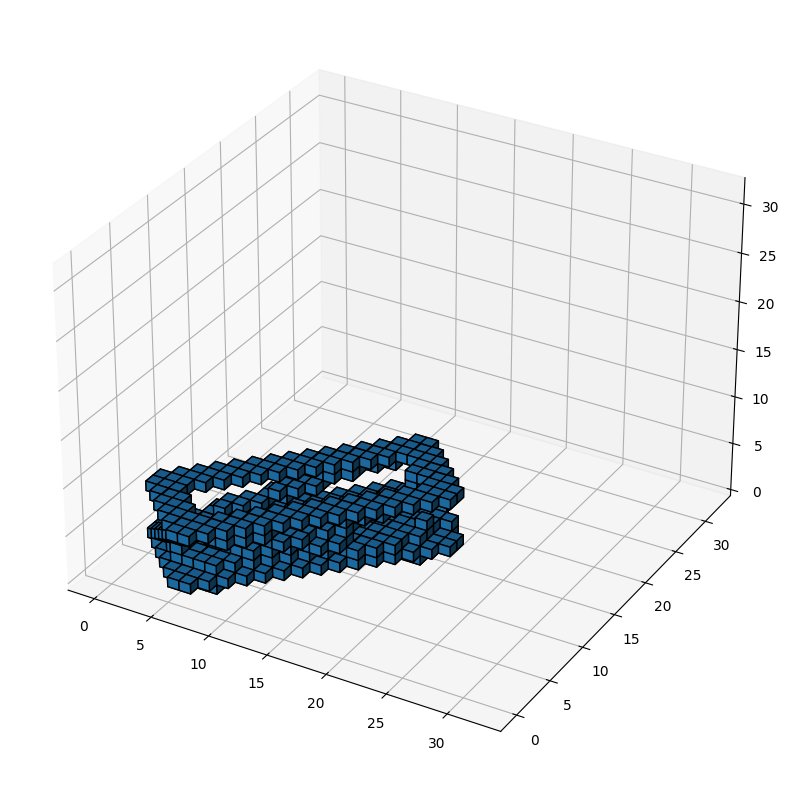

In [ ]:
mesh = o3d.io.read_triangle_mesh('/content/ModelNet10/bathtub/train/bathtub_0003.off')
mesh.rotate(r315)
              
mesh.scale(1 / np.max(mesh.get_max_bound() - mesh.get_min_bound()), center=mesh.get_center())
voxel_grid = o3d.geometry.VoxelGrid.create_from_triangle_mesh(mesh, voxel_size=0.05)

vox_grid = voxel_grid.get_voxels()
vox_g = np.zeros((32, 32, 32), dtype=np.int32)
for i in range (len(vox_grid)):
  voxel_index = vox_grid[i].grid_index
  vox_g[voxel_index[0],voxel_index[1],voxel_index[2]] = 1


ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
ax.voxels(vox_g, edgecolor='k')
plt.show()

# Dataset setup and Trainer

In [ ]:
class Network_Dataset(Dataset):
    def __init__(self, train = True):
      if train:
          self.data = X['train']
          self.label1 = Y['train']
          self.label2 = Z['train']
      else:
          self.data = X['test']
          self.label1 = Y['test']
          self.label2 = Z['test']
        
                
    def __len__(self):
        return len(self.label1)

    def __preproc__(self, voxels):
        
        voxel_grid = voxels.get_voxels()
        vox_g = np.zeros((32, 32, 32), dtype=np.int32)
        for i in range (len(voxel_grid)):
          voxel_index = voxel_grid[i].grid_index
          vox_g[voxel_index[0],voxel_index[1],voxel_index[2]] = 1
        
        return vox_g.copy()

    def __getitem__(self, idx):
        label1 = self.label1[idx]
        label2 = self.label2[idx]
        voxels = self.data[idx]
        voxels = self.__preproc__(voxels)
        voxels = np.expand_dims(voxels, axis=0)
        voxels = torch.tensor(voxels).float()
        return voxels, label1, label2

In [ ]:
class Network_Trainer():
  def __init__(self, hyperparameters):
      #Hypreparameters
      self.learning_rate = hyperparameters["learning_rate"]
      self.batch_size_train = hyperparameters["train_batch_size"]
      self.batch_size_test = hyperparameters["valid_batch_size"]
      self.data_size = hyperparameters["data_size"]
      self.sgd_momentum = hyperparameters["sgd_momentum"]
      self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
      self.epochs = hyperparameters["epochs"]
      self.name_model = hyperparameters["model"]
      self.best_acc = 0
      self.alpha = 2/3
      
      #Dataset
      self.initDataset()
      self.class_names = ["bathtub", "bed", "chair", "desk", "dresser", "monitor", "night_stand", "sofa", "table", "toilet"]
      self.rotation_names = ['0', '45', '90', '135', '180', '225', '270', '315']
      self.num_classes = len(self.class_names)
      self.num_rotations = len(self.rotation_names)

      #Model
      self.lr_scheduler_step = hyperparameters["lr_scheduler_step"]
      self.lr_scheduler_gamma = hyperparameters["lr_scheduler_gamma"]
      self.initModel()
  
  def initDataset(self):
      self.train_ds = Network_Dataset(train=True)
      self.test_ds = Network_Dataset(train=False)
      self.train_dataloader = DataLoader(dataset=self.train_ds, batch_size=self.batch_size_train, shuffle=True, drop_last=True)
      self.test_dataloader = DataLoader(dataset=self.test_ds, batch_size=self.batch_size_test)

  def initModel(self):
      if self.name_model == "VoxNet":
          self.model = VoxNet()
          os.mkdir('/content/'+str(self.name_model))
          print("model VoxNet was chosen")
      elif self.name_model == "ORION":
          self.model = ORION()
          os.mkdir('/content/'+str(self.name_model))
          print("model ORION was chosen")
      else:
        self.model = DMPORION()
        os.mkdir('/content/'+str(self.name_model))
        print('model DMPORION was choosen')
      self.device = "cuda" if torch.cuda.is_available() else "cpu"
      self.model.to(self.device)
      
      self.opt = SGD(self.model.parameters(), lr=self.learning_rate, momentum=self.sgd_momentum)
      self.loss_fn = nn.CrossEntropyLoss()
      self.lr_scheduler = torch.optim.lr_scheduler.StepLR(self.opt, step_size=self.lr_scheduler_step, gamma=self.lr_scheduler_gamma)
      
  def train(self):
      self.pred_conf, self.y_conf = [], []                                                           
      train_loss_history, valid_loss_history = [], []
      train_acc_history1, valid_acc_history1 = [], []
      train_acc_history2, valid_acc_history2 = [], []
      train_accuracy1 = Accuracy(task='multiclass', num_classes=self.num_classes)
      valid_accuracy1 = Accuracy(task='multiclass', num_classes=self.num_classes)
      train_accuracy2 = Accuracy(task='multiclass', num_classes=self.num_rotations)
      valid_accuracy2 = Accuracy(task='multiclass', num_classes=self.num_rotations)
   

      self.num_batch = len(self.train_ds) / self.batch_size_train
      print(self.num_batch)

      total_time = time.time()

      for epoch in range(self.epochs):
          t = time.time()

          #track training loss
          train_loss = []
          valid_loss = []

          #training phase
          self.model.train()
          iterator = tqdm(enumerate(self.train_dataloader, 0))
          for i, data in iterator:
              inputs, labels1, labels2 = data[0], data[1], data[2]
              inputs = inputs.to(self.device)
              labels1 = labels1.to(self.device)
              labels2 = labels2.to(self.device)

              self.opt.zero_grad()
              pred1, pred2 = self.model(inputs)  # torch.Size([256, 10])
              loss = self.alpha*self.loss_fn(pred1, labels1) + (1-self.alpha)*self.loss_fn(pred2, labels2)
              train_loss.append(loss.cpu().data)
              train_accuracy1.update(torch.argmax(pred1, 1).cpu(), labels1.cpu()) 
              train_accuracy2.update(torch.argmax(pred2, 1).cpu(), labels2.cpu()) 
            
              loss.backward()
              self.opt.step()
              iterator.set_description(f"Train loss: {loss.cpu().data}")
              
          self.lr_scheduler.step()
                      
          #test phase
          with torch.no_grad():
            self.model.eval()
            pred_test1 = []       
            pred_test2 = []  
            for j, sample in tqdm(enumerate(self.test_dataloader, 0)):    
                inputs_test, labels_test1, labels_test2 = sample[0], sample[1], sample[2]
                inputs_test = inputs_test.to(self.device)
                labels_test1 = labels_test1.to(self.device)
                labels_test2 = labels_test2.to(self.device)
                inputs_test = inputs_test.float()  
               
                pred_test1, pred_test2 = self.model(inputs_test)  # torch.Size([256, 10])
                loss_test = self.alpha*self.loss_fn(pred_test1, labels_test1) + (1-self.alpha)*self.loss_fn(pred_test2, labels_test2)
                valid_loss.append(loss_test.cpu().data)
                valid_accuracy1.update(torch.argmax(pred_test1, 1).cpu(), labels_test1.cpu()) 
                valid_accuracy2.update(torch.argmax(pred_test2, 1).cpu(), labels_test2.cpu()) 
                
                #correct_test = pred_choice_test.eq(labels_test.data).cpu().sum()
                self.pred_conf.append(torch.argmax(pred_test1, 1))
                self.y_conf.append(labels_test1)
      

          # total accuracy over all batches
          total_train_accuracy1 = train_accuracy1.compute()
          total_train_accuracy2 = train_accuracy2.compute()
          total_valid_accuracy1 = valid_accuracy1.compute()
          total_valid_accuracy2 = valid_accuracy2.compute()
          train_accuracy1.reset()
          valid_accuracy1.reset()
          train_accuracy2.reset()
          valid_accuracy2.reset()
            
          #track loss and acc for plotting
          train_loss_history.append(torch.mean(torch.tensor(train_loss)))
          valid_loss_history.append(torch.mean(torch.tensor(valid_loss)))
          train_acc_history1.append(total_train_accuracy1)
          train_acc_history2.append(total_train_accuracy2)
          valid_acc_history1.append(total_valid_accuracy1)
          valid_acc_history2.append(total_valid_accuracy2)
          
            
          elapsed_time_epoch = time.time() - t   
            
          tmp0 = "epoch:{:3d} /{:3d}".format(epoch+1, self.epochs)
          tmp1 = "time: {:.2f} seconds".format(elapsed_time_epoch)
          tmp2 = "train-loss: {:4.2f}, train-acc-object: {:.2%}, train-acc-pose: {:.2%}".format(train_loss_history[epoch], train_acc_history1[epoch].item(), train_acc_history2[epoch].item())
          tmp3 = "valid-loss: {:4.2f}, valid-acc-object: {:.2%}, train-acc-pose: {:.2%}\n".format(valid_loss_history[epoch], valid_acc_history1[epoch].item(), valid_acc_history2[epoch].item())
          print(tmp0, tmp1, tmp2, tmp3, sep="\n")


          ##save best model 
          if total_valid_accuracy1.numpy()>self.best_acc:
              self.best_acc = total_valid_accuracy1.numpy()
              torch.save({'epoch': epoch+1,
                          'model_state_dict': self.model.state_dict(),
                          'optimizer_state_dict': self.opt.state_dict(),
                          'loss': valid_loss_history[-1], 
                          'accuracy': total_valid_accuracy1},
	                        '/content/'+str(self.name_model)+'/best_model.pth')

          
          #save history
          self.history = {"train_loss": torch.tensor(train_loss_history), "train_acc1": torch.tensor(train_acc_history1), "train_acc2": torch.tensor(train_acc_history2), 
                          "valid_loss": torch.tensor(valid_loss_history), "valid_acc1": torch.tensor(valid_acc_history1), "valid_acc2": torch.tensor(valid_acc_history2)}
           
  def getHistory(self):
      return self.history

  def generateConfusionMatrix(self):
      ##load the model
      checkpoint = torch.load('/content/'+str(self.name_model)+'/best_model.pth')
      self.model.load_state_dict(checkpoint['model_state_dict'])
      self.opt.load_state_dict(checkpoint['optimizer_state_dict'])
      loss = checkpoint['loss']
      epoch = checkpoint['epoch']
      acc = checkpoint['accuracy']
      print('best model was trained at epoch: '+str(epoch))
      print('with a validation loss of: '+str(loss.numpy())+' and a validation accuracy of: '+str(acc.numpy()*100))
  
      ##compute confusion matrix
      self.model.eval()
      a = torch.cat(self.pred_conf).cpu()
      b = torch.cat(self.y_conf).cpu()
      confmat = ConfusionMatrix(task='multiclass', num_classes=10, normalize="true")
      self.conf_matrix = confmat(a, b)
      self.conf_matrix = torch.round(self.conf_matrix, decimals=2)

      fig=plt.figure(figsize = (12,7))
      sns.heatmap(self.conf_matrix, annot=True, fmt='g', linewidths=.4, cbar=False)
      tick_marks = np.arange(len(self.class_names))
      plt.xticks(tick_marks, self.class_names, rotation=45)
      plt.yticks(tick_marks, self.class_names, rotation=0)
      plt.title("Confusion Matrix")     

  def getPerClassAccuracy(self):
      per_class_accuracy = 100 * torch.diag(self.conf_matrix) / torch.sum(self.conf_matrix, 1)
      tmp = {}
      for i, x in enumerate(self.class_names):
        tmp[x] = per_class_accuracy[i].item()
      print(tmp)
    
  def showResults(self):
      eps = range(0, len(self.history["train_loss"].cpu()))
        
      sns.set_theme()
      fig, ax = plt.subplots(1, 2, figsize=(14, 4))
      fig.suptitle('Results')
        
      ax[0].plot(eps, smooth(self.history["train_loss"].cpu()), 'g', label='Training Loss')
      ax[0].plot(eps, smooth(self.history["valid_loss"].cpu()), 'b', label='Valid Loss')
      ax[0].set_title('Loss History')
      ax[0].set(xlabel='Epochs', ylabel='Loss')
      ax[0].legend()
        
      ax[1].plot(eps, smooth(self.history["train_acc1"].cpu()), 'g', label='Training Accuracy object')
      ax[1].plot(eps, smooth(self.history["train_acc2"].cpu()), 'k', label='Training Accuracy pose')
      ax[1].plot(eps, smooth(self.history["valid_acc1"].cpu()), 'b', label='Valid Accuracy object')
      ax[1].plot(eps, smooth(self.history["valid_acc2"].cpu()), 'r', label='Valid Accuracy pose')
      ax[1].set_title('Accuracy History')
      ax[1].set(xlabel='Epochs', ylabel='Accuracy')
      ax[1].legend()

  def draw_voxels(self):
      mesh = next(iter(self.train_dataloader))
      mesh = mesh[0][0][0]
        
      ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
      ax.voxels(mesh, edgecolor='k')
      plt.show()
        
  def test_on_missing_data(self, missing_rate=0.5):
      test_accuracy = Accuracy(task='multiclass', num_classes=self.num_classes)

      ##load the model
      checkpoint = torch.load('/content/'+str(self.name_model)+'/best_model.pth')
      self.model.load_state_dict(checkpoint['model_state_dict'])
      self.opt.load_state_dict(checkpoint['optimizer_state_dict'])
      loss = checkpoint['loss']
      epoch = checkpoint['epoch']
      acc = checkpoint['accuracy']
  
      self.model.eval()
      for x, y, z in self.test_dataloader:
          x, y, z = x.to(self.device), y.to(self.device), z.to(self.device)
            
          idc = np.random.choice(32**3, size=(int(32**3*missing_rate)), replace=False)
          idc_x = idc%32
          idc_y = np.floor_divide(idc, 32)%32
          idc_z = np.floor_divide(idc, 32*32)%32
          x[:, :, idc_x, idc_y, idc_z] = 0
            
          pred = self.model(x)[0]
          test_accuracy.update(torch.argmax(pred, 1).cpu(), y.cpu())
            
      return test_accuracy.compute()
    
  def missing_data_test(self):
      acc = []
      delta = 200
      eps = np.linspace(0,0.99,delta)

      ##load the model
      checkpoint = torch.load('/content/'+str(self.name_model)+'/best_model.pth')
      self.model.load_state_dict(checkpoint['model_state_dict'])
      self.opt.load_state_dict(checkpoint['optimizer_state_dict'])
      loss = checkpoint['loss']
      epoch = checkpoint['epoch']
      accu = checkpoint['accuracy']
      print('best model was trained at epoch: '+str(epoch))
      print('with a validation loss of: '+str(loss.numpy())+' and a validation accuracy of: '+str(accu.numpy()*100))

      for x in eps:
          tmp = self.test_on_missing_data(x)
          acc.append(tmp)
            
            
      sns.set_theme()
      plt.figure(figsize=(8, 4))
      plt.plot(eps, smooth(acc))
      plt.title("Missing Data Test", size=20, y=1.05)
      plt.xlabel("missing point ratio", size=15)
      plt.ylabel("accuracy", size=15)
      plt.show()

# VoxNet

In [12]:
class VoxNet(nn.Module):
    def __init__(self):
        super(VoxNet, self).__init__()
        n_classes = 10
        n_rotations = 8
        input_shape = (32,32,32)
        self.feat = torch.nn.Sequential(OrderedDict([
            ('conv3d_1', torch.nn.Conv3d(in_channels=1, out_channels=32, kernel_size=5, stride=2)),
            ('batch1', torch.nn.BatchNorm3d(32)),
            ('relu1', torch.nn.ReLU()),
            ('drop1', torch.nn.Dropout(p=0.2)),
            ('conv3d_2', torch.nn.Conv3d(in_channels=32, out_channels=32, kernel_size=3, stride=1)),
            ('batch1', torch.nn.BatchNorm3d(32)),
            ('relu2', torch.nn.ReLU()),
            ('pool1', torch.nn.MaxPool3d(kernel_size=2, stride=2)),
            ('drop2', torch.nn.Dropout(p=0.3))
        ]))
        
        x = self.feat(torch.autograd.Variable(torch.rand((1, 1) + input_shape)))
        dim_feat = 1
        for n in x.size()[1:]:
            dim_feat *= n

        self.mlp = torch.nn.Sequential(OrderedDict([
            ('fc1', torch.nn.Linear(dim_feat, 128)),
            ('relu1', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.4)),
            ('fc2', torch.nn.Linear(128, n_classes))
        ]))

        self.mlp2 = torch.nn.Sequential(OrderedDict([
            ('fc1', torch.nn.Linear(dim_feat, 128)),
            ('relu1', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.4)),
            ('fc2', torch.nn.Linear(128, n_rotations))
        ]))

        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.feat(x)
        x = x.view(x.size(0), -1)
        x1 = self.mlp(x)
        x2 = self.mlp2(x)
        return self.logsoftmax(x1), self.logsoftmax(x2)

**VoxNet** training

In [ ]:
training_hyperparameters = {
    "learning_rate": 0.01,
    "sgd_momentum": 0.9,
    "data_size": 32,
    "epochs": 50,
    "lr_scheduler_step": 5,
    "lr_scheduler_gamma": 0.5,
    "train_batch_size": 64,
    "valid_batch_size": 32,
    "model" : 'VoxNet'
}    

trainer1 = Network_Trainer(training_hyperparameters)
trainer1.train()

model VoxNet was chosen
62.359375


Train loss: 1.0548269748687744: : 62it [00:17,  3.63it/s]
29it [00:01, 15.89it/s]


epoch:  1 / 50
time: 18.91 seconds
train-loss: 1.45, train-acc-object: 50.10%, train-acc-pose: 39.64%
valid-loss: 1.17, valid-acc-object: 54.41%, train-acc-pose: 56.50%



Train loss: 0.7616387605667114: : 62it [00:10,  6.08it/s]
29it [00:01, 15.82it/s]


epoch:  2 / 50
time: 12.04 seconds
train-loss: 0.90, train-acc-object: 70.11%, train-acc-pose: 60.69%
valid-loss: 0.82, valid-acc-object: 70.48%, train-acc-pose: 62.78%



Train loss: 0.7834546566009521: : 62it [00:10,  6.04it/s]
29it [00:01, 15.72it/s]


epoch:  3 / 50
time: 12.13 seconds
train-loss: 0.72, train-acc-object: 77.09%, train-acc-pose: 68.62%
valid-loss: 0.75, valid-acc-object: 71.48%, train-acc-pose: 65.31%



Train loss: 0.6682876348495483: : 62it [00:10,  6.05it/s]
29it [00:01, 15.88it/s]


epoch:  4 / 50
time: 12.09 seconds
train-loss: 0.59, train-acc-object: 81.05%, train-acc-pose: 72.86%
valid-loss: 0.69, valid-acc-object: 75.22%, train-acc-pose: 67.95%



Train loss: 0.47880738973617554: : 62it [00:10,  6.08it/s]
29it [00:01, 15.97it/s]


epoch:  5 / 50
time: 12.03 seconds
train-loss: 0.52, train-acc-object: 83.77%, train-acc-pose: 74.57%
valid-loss: 0.67, valid-acc-object: 76.98%, train-acc-pose: 68.61%



Train loss: 0.3409971594810486: : 62it [00:10,  6.09it/s]
29it [00:01, 15.76it/s]


epoch:  6 / 50
time: 12.04 seconds
train-loss: 0.43, train-acc-object: 87.15%, train-acc-pose: 77.67%
valid-loss: 0.60, valid-acc-object: 79.85%, train-acc-pose: 72.25%



Train loss: 0.38720202445983887: : 62it [00:09,  6.21it/s]
29it [00:02, 12.90it/s]


epoch:  7 / 50
time: 12.24 seconds
train-loss: 0.40, train-acc-object: 87.68%, train-acc-pose: 79.59%
valid-loss: 0.59, valid-acc-object: 80.95%, train-acc-pose: 72.47%



Train loss: 0.33648645877838135: : 62it [00:09,  6.50it/s]
29it [00:02, 10.08it/s]


epoch:  8 / 50
time: 12.44 seconds
train-loss: 0.37, train-acc-object: 89.77%, train-acc-pose: 80.29%
valid-loss: 0.57, valid-acc-object: 80.62%, train-acc-pose: 74.45%



Train loss: 0.32521769404411316: : 62it [00:09,  6.73it/s]
29it [00:02, 10.15it/s]


epoch:  9 / 50
time: 12.09 seconds
train-loss: 0.33, train-acc-object: 90.60%, train-acc-pose: 81.45%
valid-loss: 0.59, valid-acc-object: 80.73%, train-acc-pose: 74.78%



Train loss: 0.3330223262310028: : 62it [00:09,  6.63it/s]
29it [00:02, 13.90it/s]


epoch: 10 / 50
time: 11.45 seconds
train-loss: 0.31, train-acc-object: 91.33%, train-acc-pose: 82.03%
valid-loss: 0.59, valid-acc-object: 80.84%, train-acc-pose: 73.68%



Train loss: 0.21804940700531006: : 62it [00:10,  6.18it/s]
29it [00:01, 15.62it/s]


epoch: 11 / 50
time: 11.90 seconds
train-loss: 0.28, train-acc-object: 92.59%, train-acc-pose: 84.98%
valid-loss: 0.57, valid-acc-object: 81.50%, train-acc-pose: 76.21%



Train loss: 0.37595897912979126: : 62it [00:10,  6.06it/s]
29it [00:01, 15.51it/s]


epoch: 12 / 50
time: 12.11 seconds
train-loss: 0.27, train-acc-object: 92.52%, train-acc-pose: 84.65%
valid-loss: 0.56, valid-acc-object: 82.49%, train-acc-pose: 75.55%



Train loss: 0.21038676798343658: : 62it [00:10,  5.98it/s]
29it [00:01, 16.07it/s]


epoch: 13 / 50
time: 12.19 seconds
train-loss: 0.24, train-acc-object: 93.80%, train-acc-pose: 85.11%
valid-loss: 0.57, valid-acc-object: 83.15%, train-acc-pose: 75.55%



Train loss: 0.2594171166419983: : 62it [00:10,  5.98it/s]
29it [00:01, 15.60it/s]


epoch: 14 / 50
time: 12.25 seconds
train-loss: 0.24, train-acc-object: 93.09%, train-acc-pose: 86.67%
valid-loss: 0.56, valid-acc-object: 82.38%, train-acc-pose: 75.88%



Train loss: 0.13265404105186462: : 62it [00:10,  6.00it/s]
29it [00:01, 15.56it/s]


epoch: 15 / 50
time: 12.22 seconds
train-loss: 0.24, train-acc-object: 93.52%, train-acc-pose: 85.94%
valid-loss: 0.58, valid-acc-object: 82.27%, train-acc-pose: 75.44%



Train loss: 0.13961482048034668: : 62it [00:10,  5.94it/s]
29it [00:01, 15.60it/s]


epoch: 16 / 50
time: 12.32 seconds
train-loss: 0.22, train-acc-object: 94.25%, train-acc-pose: 87.30%
valid-loss: 0.58, valid-acc-object: 82.82%, train-acc-pose: 76.43%



Train loss: 0.1801653653383255: : 62it [00:10,  5.93it/s]
29it [00:01, 15.13it/s]


epoch: 17 / 50
time: 12.39 seconds
train-loss: 0.21, train-acc-object: 94.83%, train-acc-pose: 87.27%
valid-loss: 0.57, valid-acc-object: 83.04%, train-acc-pose: 75.44%



Train loss: 0.1787809431552887: : 62it [00:10,  6.12it/s]
29it [00:02, 12.76it/s]


epoch: 18 / 50
time: 12.42 seconds
train-loss: 0.21, train-acc-object: 94.63%, train-acc-pose: 86.95%
valid-loss: 0.57, valid-acc-object: 83.48%, train-acc-pose: 75.88%



Train loss: 0.14444641768932343: : 62it [00:09,  6.45it/s]
29it [00:02, 10.25it/s]


epoch: 19 / 50
time: 12.46 seconds
train-loss: 0.21, train-acc-object: 94.25%, train-acc-pose: 87.45%
valid-loss: 0.57, valid-acc-object: 82.82%, train-acc-pose: 75.88%



Train loss: 0.1870519369840622: : 62it [00:09,  6.73it/s]
29it [00:03,  9.48it/s]


epoch: 20 / 50
time: 12.29 seconds
train-loss: 0.20, train-acc-object: 95.04%, train-acc-pose: 87.47%
valid-loss: 0.58, valid-acc-object: 82.60%, train-acc-pose: 76.54%



Train loss: 0.2796284556388855: : 62it [00:09,  6.52it/s]
29it [00:02, 12.36it/s]


epoch: 21 / 50
time: 11.87 seconds
train-loss: 0.19, train-acc-object: 95.14%, train-acc-pose: 88.36%
valid-loss: 0.58, valid-acc-object: 82.82%, train-acc-pose: 75.99%



Train loss: 0.15369287133216858: : 62it [00:10,  6.16it/s]
29it [00:01, 15.34it/s]


epoch: 22 / 50
time: 11.97 seconds
train-loss: 0.19, train-acc-object: 95.41%, train-acc-pose: 88.61%
valid-loss: 0.58, valid-acc-object: 83.15%, train-acc-pose: 76.10%



Train loss: 0.193386510014534: : 62it [00:10,  5.96it/s]
29it [00:01, 15.36it/s]


epoch: 23 / 50
time: 12.30 seconds
train-loss: 0.19, train-acc-object: 95.31%, train-acc-pose: 87.98%
valid-loss: 0.58, valid-acc-object: 83.15%, train-acc-pose: 76.21%



Train loss: 0.20881569385528564: : 62it [00:10,  5.91it/s]
29it [00:01, 15.21it/s]


epoch: 24 / 50
time: 12.42 seconds
train-loss: 0.19, train-acc-object: 95.41%, train-acc-pose: 88.53%
valid-loss: 0.57, valid-acc-object: 83.81%, train-acc-pose: 76.21%



Train loss: 0.15676067769527435: : 62it [00:10,  5.87it/s]
29it [00:01, 15.10it/s]


epoch: 25 / 50
time: 12.49 seconds
train-loss: 0.19, train-acc-object: 95.64%, train-acc-pose: 88.51%
valid-loss: 0.58, valid-acc-object: 83.48%, train-acc-pose: 77.09%



Train loss: 0.20596261322498322: : 62it [00:10,  5.88it/s]
29it [00:01, 15.20it/s]


epoch: 26 / 50
time: 12.47 seconds
train-loss: 0.18, train-acc-object: 95.97%, train-acc-pose: 88.94%
valid-loss: 0.59, valid-acc-object: 83.37%, train-acc-pose: 76.65%



Train loss: 0.218172088265419: : 62it [00:10,  5.90it/s]
29it [00:01, 15.41it/s]


epoch: 27 / 50
time: 12.41 seconds
train-loss: 0.18, train-acc-object: 95.34%, train-acc-pose: 88.61%
valid-loss: 0.58, valid-acc-object: 83.81%, train-acc-pose: 76.43%



Train loss: 0.17506706714630127: : 62it [00:10,  5.94it/s]
29it [00:01, 15.06it/s]


epoch: 28 / 50
time: 12.38 seconds
train-loss: 0.18, train-acc-object: 95.51%, train-acc-pose: 89.11%
valid-loss: 0.58, valid-acc-object: 83.15%, train-acc-pose: 76.43%



Train loss: 0.18338921666145325: : 62it [00:10,  5.98it/s]
29it [00:01, 15.03it/s]


epoch: 29 / 50
time: 12.32 seconds
train-loss: 0.18, train-acc-object: 95.87%, train-acc-pose: 89.14%
valid-loss: 0.58, valid-acc-object: 83.81%, train-acc-pose: 76.32%



Train loss: 0.20593926310539246: : 62it [00:10,  5.92it/s]
29it [00:01, 15.29it/s]


epoch: 30 / 50
time: 12.39 seconds
train-loss: 0.18, train-acc-object: 95.54%, train-acc-pose: 88.86%
valid-loss: 0.58, valid-acc-object: 83.59%, train-acc-pose: 76.54%



Train loss: 0.2268628478050232: : 62it [00:10,  6.19it/s]
29it [00:02, 12.20it/s]


epoch: 31 / 50
time: 12.41 seconds
train-loss: 0.17, train-acc-object: 95.94%, train-acc-pose: 89.64%
valid-loss: 0.59, valid-acc-object: 83.59%, train-acc-pose: 76.21%



Train loss: 0.15424016118049622: : 62it [00:09,  6.58it/s]
29it [00:03,  9.45it/s]


epoch: 32 / 50
time: 12.51 seconds
train-loss: 0.18, train-acc-object: 94.96%, train-acc-pose: 89.54%
valid-loss: 0.59, valid-acc-object: 83.59%, train-acc-pose: 76.21%



Train loss: 0.16392041742801666: : 62it [00:09,  6.73it/s]
29it [00:02,  9.93it/s]


epoch: 33 / 50
time: 12.15 seconds
train-loss: 0.17, train-acc-object: 96.09%, train-acc-pose: 88.81%
valid-loss: 0.58, valid-acc-object: 83.70%, train-acc-pose: 76.54%



Train loss: 0.16596347093582153: : 62it [00:09,  6.38it/s]
29it [00:02, 12.35it/s]


epoch: 34 / 50
time: 12.09 seconds
train-loss: 0.17, train-acc-object: 95.72%, train-acc-pose: 89.42%
valid-loss: 0.58, valid-acc-object: 83.92%, train-acc-pose: 76.10%



Train loss: 0.11629247665405273: : 62it [00:10,  6.12it/s]
29it [00:01, 15.24it/s]


epoch: 35 / 50
time: 12.05 seconds
train-loss: 0.17, train-acc-object: 96.04%, train-acc-pose: 89.74%
valid-loss: 0.59, valid-acc-object: 83.37%, train-acc-pose: 76.54%



Train loss: 0.12857800722122192: : 62it [00:10,  5.95it/s]
29it [00:01, 15.01it/s]


epoch: 36 / 50
time: 12.38 seconds
train-loss: 0.18, train-acc-object: 95.19%, train-acc-pose: 89.39%
valid-loss: 0.58, valid-acc-object: 83.92%, train-acc-pose: 76.43%



Train loss: 0.16539083421230316: : 62it [00:10,  5.88it/s]
29it [00:01, 15.20it/s]


epoch: 37 / 50
time: 12.48 seconds
train-loss: 0.18, train-acc-object: 95.72%, train-acc-pose: 88.21%
valid-loss: 0.58, valid-acc-object: 83.37%, train-acc-pose: 76.54%



Train loss: 0.1672295778989792: : 62it [00:10,  5.95it/s]
29it [00:01, 15.13it/s]


epoch: 38 / 50
time: 12.35 seconds
train-loss: 0.17, train-acc-object: 95.84%, train-acc-pose: 89.79%
valid-loss: 0.58, valid-acc-object: 83.81%, train-acc-pose: 76.76%



Train loss: 0.15874722599983215: : 62it [00:10,  5.94it/s]
29it [00:01, 15.08it/s]


epoch: 39 / 50
time: 12.38 seconds
train-loss: 0.17, train-acc-object: 95.64%, train-acc-pose: 89.74%
valid-loss: 0.58, valid-acc-object: 83.81%, train-acc-pose: 76.54%



Train loss: 0.18182870745658875: : 62it [00:10,  5.84it/s]
29it [00:01, 15.22it/s]


epoch: 40 / 50
time: 12.54 seconds
train-loss: 0.18, train-acc-object: 95.84%, train-acc-pose: 88.23%
valid-loss: 0.58, valid-acc-object: 83.70%, train-acc-pose: 76.54%



Train loss: 0.1720128208398819: : 62it [00:10,  5.88it/s]
29it [00:01, 14.84it/s]


epoch: 41 / 50
time: 12.52 seconds
train-loss: 0.18, train-acc-object: 95.59%, train-acc-pose: 88.36%
valid-loss: 0.58, valid-acc-object: 83.70%, train-acc-pose: 76.43%



Train loss: 0.14137166738510132: : 62it [00:10,  5.90it/s]
29it [00:01, 14.94it/s]


epoch: 42 / 50
time: 12.47 seconds
train-loss: 0.18, train-acc-object: 95.74%, train-acc-pose: 89.29%
valid-loss: 0.58, valid-acc-object: 83.70%, train-acc-pose: 76.32%



Train loss: 0.17728875577449799: : 62it [00:10,  5.91it/s]
29it [00:01, 15.03it/s]


epoch: 43 / 50
time: 12.44 seconds
train-loss: 0.17, train-acc-object: 95.82%, train-acc-pose: 89.42%
valid-loss: 0.58, valid-acc-object: 83.59%, train-acc-pose: 76.43%



Train loss: 0.13883528113365173: : 62it [00:10,  5.83it/s]
29it [00:02, 14.06it/s]


epoch: 44 / 50
time: 12.71 seconds
train-loss: 0.17, train-acc-object: 95.72%, train-acc-pose: 89.57%
valid-loss: 0.58, valid-acc-object: 83.92%, train-acc-pose: 76.32%



Train loss: 0.2501133680343628: : 62it [00:10,  6.17it/s]
29it [00:02, 11.26it/s]


epoch: 45 / 50
time: 12.65 seconds
train-loss: 0.17, train-acc-object: 95.79%, train-acc-pose: 89.42%
valid-loss: 0.58, valid-acc-object: 83.81%, train-acc-pose: 76.54%



Train loss: 0.19792166352272034: : 62it [00:09,  6.37it/s]
29it [00:02,  9.75it/s]


epoch: 46 / 50
time: 12.72 seconds
train-loss: 0.17, train-acc-object: 95.72%, train-acc-pose: 89.16%
valid-loss: 0.58, valid-acc-object: 83.81%, train-acc-pose: 76.21%



Train loss: 0.20511329174041748: : 62it [00:09,  6.41it/s]
29it [00:03,  8.35it/s]


epoch: 47 / 50
time: 13.16 seconds
train-loss: 0.17, train-acc-object: 95.46%, train-acc-pose: 88.91%
valid-loss: 0.59, valid-acc-object: 83.92%, train-acc-pose: 76.32%



Train loss: 0.18503957986831665: : 62it [00:09,  6.40it/s]
29it [00:03,  9.46it/s]


epoch: 48 / 50
time: 12.76 seconds
train-loss: 0.18, train-acc-object: 95.56%, train-acc-pose: 89.44%
valid-loss: 0.58, valid-acc-object: 83.92%, train-acc-pose: 76.21%



Train loss: 0.17553789913654327: : 62it [00:09,  6.34it/s]
29it [00:02, 10.66it/s]


epoch: 49 / 50
time: 12.52 seconds
train-loss: 0.17, train-acc-object: 95.94%, train-acc-pose: 88.81%
valid-loss: 0.58, valid-acc-object: 83.81%, train-acc-pose: 76.21%



Train loss: 0.1533929407596588: : 62it [00:10,  6.15it/s]
29it [00:02, 12.76it/s]

epoch: 50 / 50
time: 12.37 seconds
train-loss: 0.17, train-acc-object: 95.92%, train-acc-pose: 88.79%
valid-loss: 0.58, valid-acc-object: 83.92%, train-acc-pose: 76.21%



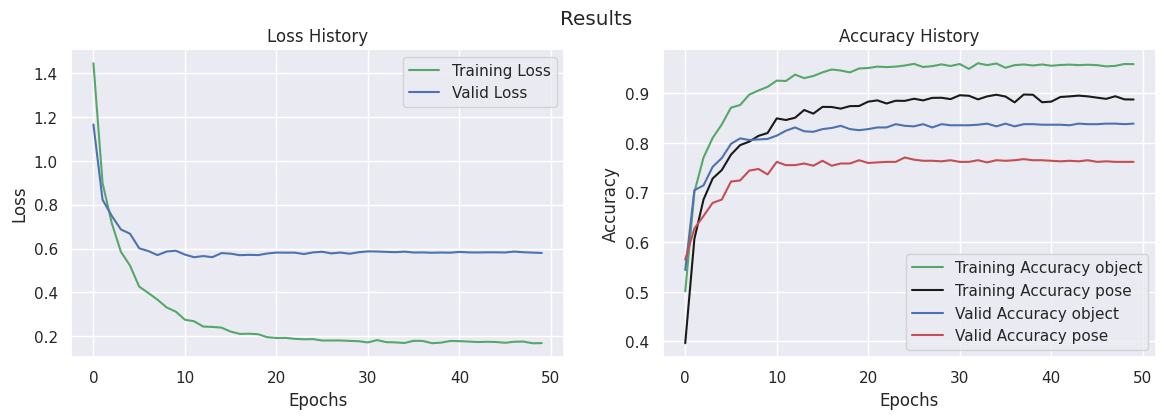

In [ ]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
      smoothed_val = w * last + (1 - w) * point
      smoothed.append(smoothed_val)
      ast = smoothed_val
          
    return smoothed

history1 = trainer1.getHistory()
trainer1.showResults()

best model was trained at epoch: 34
with a validation loss of: 0.58351034 and a validation accuracy of: 83.92070531845093


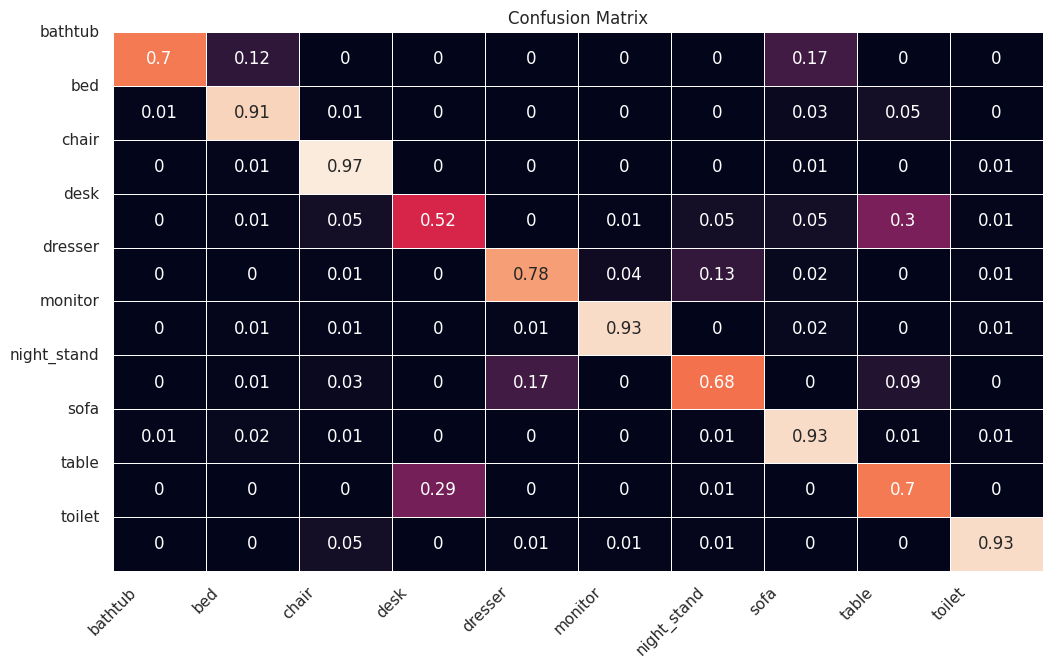

In [ ]:
trainer1.generateConfusionMatrix()

best model was trained at epoch: 34
with a validation loss of: 0.58351034 and a validation accuracy of: 83.92070531845093


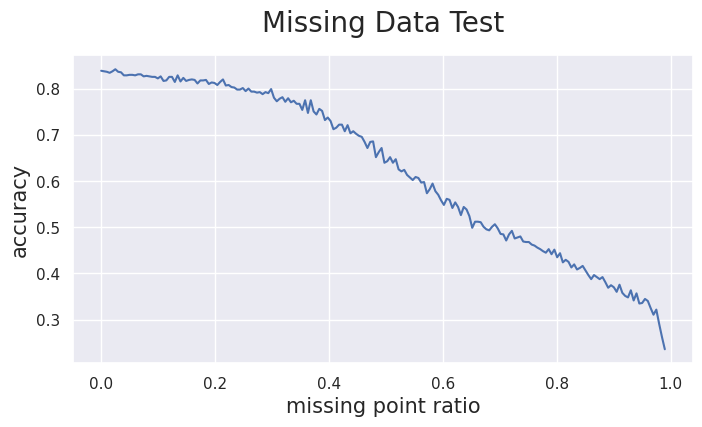

In [ ]:
trainer1.missing_data_test()

# ORION

In [13]:
class ORION(nn.Module):
    def __init__(self):
        super(ORION, self).__init__()
        n_classes = 10
        n_rotations = 8
        input_shape = (32,32,32)
        self.feat = torch.nn.Sequential(OrderedDict([
            ('conv3d_1', torch.nn.Conv3d(in_channels=1, out_channels=32, kernel_size=3, stride=2)),
            ('batch1', torch.nn.BatchNorm3d(32)),
            ('relu1', torch.nn.ReLU()),
            ('drop1', torch.nn.Dropout(p=0.2)),
            ('conv3d_2', torch.nn.Conv3d(in_channels=32, out_channels=64, kernel_size=3, stride=1)),
            ('batch2', torch.nn.BatchNorm3d(64)),
            ('relu2', torch.nn.ReLU()),
            ('drop2', torch.nn.Dropout(p=0.3)),
            ('conv3d_3', torch.nn.Conv3d(in_channels=64, out_channels=128, kernel_size=3, stride=1)),
            ('batch3', torch.nn.BatchNorm3d(128)),
            ('relu3', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.3)),
            ('conv3d_4', torch.nn.Conv3d(in_channels=128, out_channels=256, kernel_size=3, stride=1)),
            ('relu4', torch.nn.ReLU()),
            ('pool1', torch.nn.MaxPool3d(kernel_size=2, stride=2)),
            ('drop4', torch.nn.Dropout(p=0.3))            
        ]))
        
        x = self.feat(torch.autograd.Variable(torch.rand((1, 1) + input_shape)))
        dim_feat = 1
        for n in x.size()[1:]:
            dim_feat *= n

        self.mlp = torch.nn.Sequential(OrderedDict([
            ('fc1', torch.nn.Linear(dim_feat, 128)),
            ('relu1', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.4)),
            ('fc2', torch.nn.Linear(128, n_classes))
        ]))

        self.mlp2 = torch.nn.Sequential(OrderedDict([
            ('fc1', torch.nn.Linear(dim_feat, 128)),
            ('relu1', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.4)),
            ('fc2', torch.nn.Linear(128, n_rotations))
        ]))

        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.feat(x)
        x = x.view(x.size(0), -1)
        x1 = self.mlp(x)
        x2 = self.mlp2(x)
        return self.logsoftmax(x1), self.logsoftmax(x2)

**BatchNormVoxNet** Training 

In [ ]:
training_hyperparameters = {
    "learning_rate": 0.01,
    "sgd_momentum": 0.9,
    "data_size": 32,
    "epochs": 50,
    "lr_scheduler_step": 5,
    "lr_scheduler_gamma": 0.5,
    "train_batch_size": 64,
    "valid_batch_size": 32,
    "model" : 'ORION'
}    

trainer2 = Network_Trainer(training_hyperparameters)
trainer2.train()

model BatchNormVoxNet was chosen
62.359375


Train loss: 1.1999561786651611: : 62it [00:16,  3.67it/s]
29it [00:02, 13.63it/s]


epoch:  1 / 50
time: 19.06 seconds
train-loss: 1.53, train-acc-object: 48.51%, train-acc-pose: 36.01%
valid-loss: 1.20, valid-acc-object: 62.67%, train-acc-pose: 54.85%



Train loss: 0.809472918510437: : 62it [00:16,  3.69it/s]
29it [00:03,  8.49it/s]


epoch:  2 / 50
time: 20.24 seconds
train-loss: 0.96, train-acc-object: 69.41%, train-acc-pose: 56.48%
valid-loss: 0.88, valid-acc-object: 69.71%, train-acc-pose: 61.01%



Train loss: 0.5984687805175781: : 62it [00:16,  3.71it/s]
29it [00:02, 13.53it/s]


epoch:  3 / 50
time: 18.85 seconds
train-loss: 0.75, train-acc-object: 76.03%, train-acc-pose: 65.90%
valid-loss: 0.74, valid-acc-object: 72.69%, train-acc-pose: 66.96%



Train loss: 0.6206256747245789: : 62it [00:16,  3.70it/s]
29it [00:03,  8.65it/s]


epoch:  4 / 50
time: 20.12 seconds
train-loss: 0.62, train-acc-object: 79.99%, train-acc-pose: 71.45%
valid-loss: 0.66, valid-acc-object: 78.41%, train-acc-pose: 68.39%



Train loss: 0.46685630083084106: : 62it [00:16,  3.65it/s]
29it [00:02, 13.50it/s]


epoch:  5 / 50
time: 19.15 seconds
train-loss: 0.51, train-acc-object: 84.12%, train-acc-pose: 75.03%
valid-loss: 0.71, valid-acc-object: 73.90%, train-acc-pose: 69.82%



Train loss: 0.4012671709060669: : 62it [00:16,  3.69it/s]
29it [00:03,  9.36it/s]


epoch:  6 / 50
time: 19.93 seconds
train-loss: 0.43, train-acc-object: 86.90%, train-acc-pose: 78.05%
valid-loss: 0.57, valid-acc-object: 80.95%, train-acc-pose: 71.59%



Train loss: 0.43294602632522583: : 62it [00:17,  3.64it/s]
29it [00:02, 12.93it/s]


epoch:  7 / 50
time: 19.30 seconds
train-loss: 0.38, train-acc-object: 88.43%, train-acc-pose: 80.14%
valid-loss: 0.57, valid-acc-object: 80.95%, train-acc-pose: 72.47%



Train loss: 0.34619224071502686: : 62it [00:16,  3.69it/s]
29it [00:02, 11.64it/s]


epoch:  8 / 50
time: 19.29 seconds
train-loss: 0.35, train-acc-object: 89.36%, train-acc-pose: 80.02%
valid-loss: 0.56, valid-acc-object: 81.17%, train-acc-pose: 72.47%



Train loss: 0.3988409638404846: : 62it [00:17,  3.59it/s]
29it [00:02, 13.50it/s]


epoch:  9 / 50
time: 19.45 seconds
train-loss: 0.32, train-acc-object: 90.62%, train-acc-pose: 81.96%
valid-loss: 0.52, valid-acc-object: 83.48%, train-acc-pose: 75.00%



Train loss: 0.34699302911758423: : 62it [00:16,  3.69it/s]
29it [00:02, 13.58it/s]


epoch: 10 / 50
time: 18.94 seconds
train-loss: 0.31, train-acc-object: 91.28%, train-acc-pose: 81.63%
valid-loss: 0.56, valid-acc-object: 81.61%, train-acc-pose: 74.01%



Train loss: 0.20406031608581543: : 62it [00:17,  3.51it/s]
29it [00:02, 13.29it/s]


epoch: 11 / 50
time: 19.87 seconds
train-loss: 0.28, train-acc-object: 92.21%, train-acc-pose: 83.59%
valid-loss: 0.52, valid-acc-object: 83.70%, train-acc-pose: 75.33%



Train loss: 0.2853178381919861: : 62it [00:16,  3.72it/s]
29it [00:02, 13.45it/s]


epoch: 12 / 50
time: 18.85 seconds
train-loss: 0.26, train-acc-object: 92.62%, train-acc-pose: 84.78%
valid-loss: 0.51, valid-acc-object: 84.25%, train-acc-pose: 77.75%



Train loss: 0.18752163648605347: : 62it [00:17,  3.55it/s]
29it [00:02, 13.30it/s]


epoch: 13 / 50
time: 19.66 seconds
train-loss: 0.24, train-acc-object: 94.00%, train-acc-pose: 84.75%
valid-loss: 0.53, valid-acc-object: 84.58%, train-acc-pose: 76.54%



Train loss: 0.18006005883216858: : 62it [00:16,  3.69it/s]
29it [00:02, 13.46it/s]


epoch: 14 / 50
time: 18.97 seconds
train-loss: 0.24, train-acc-object: 93.72%, train-acc-pose: 84.50%
valid-loss: 0.55, valid-acc-object: 82.60%, train-acc-pose: 75.22%



Train loss: 0.1881401240825653: : 62it [00:17,  3.57it/s]
29it [00:02, 11.40it/s]


epoch: 15 / 50
time: 19.93 seconds
train-loss: 0.23, train-acc-object: 93.65%, train-acc-pose: 86.01%
valid-loss: 0.53, valid-acc-object: 84.69%, train-acc-pose: 76.65%



Train loss: 0.24886742234230042: : 62it [00:16,  3.68it/s]
29it [00:02, 12.89it/s]


epoch: 16 / 50
time: 19.10 seconds
train-loss: 0.21, train-acc-object: 94.96%, train-acc-pose: 86.59%
valid-loss: 0.53, valid-acc-object: 83.81%, train-acc-pose: 77.09%



Train loss: 0.21234086155891418: : 62it [00:17,  3.58it/s]
29it [00:02, 10.23it/s]


epoch: 17 / 50
time: 20.15 seconds
train-loss: 0.21, train-acc-object: 94.98%, train-acc-pose: 86.14%
valid-loss: 0.53, valid-acc-object: 84.80%, train-acc-pose: 76.98%



Train loss: 0.15105672180652618: : 62it [00:16,  3.68it/s]
29it [00:02, 12.85it/s]


epoch: 18 / 50
time: 19.11 seconds
train-loss: 0.20, train-acc-object: 94.71%, train-acc-pose: 86.67%
valid-loss: 0.54, valid-acc-object: 83.92%, train-acc-pose: 76.43%



Train loss: 0.22112804651260376: : 62it [00:17,  3.64it/s]
29it [00:03,  9.19it/s]


epoch: 19 / 50
time: 20.21 seconds
train-loss: 0.21, train-acc-object: 94.61%, train-acc-pose: 86.97%
valid-loss: 0.53, valid-acc-object: 84.36%, train-acc-pose: 77.31%



Train loss: 0.25073379278182983: : 62it [00:16,  3.68it/s]
29it [00:02, 13.24it/s]


epoch: 20 / 50
time: 19.03 seconds
train-loss: 0.20, train-acc-object: 94.96%, train-acc-pose: 87.58%
valid-loss: 0.53, valid-acc-object: 84.14%, train-acc-pose: 76.98%



Train loss: 0.16724519431591034: : 62it [00:16,  3.69it/s]
29it [00:03,  8.16it/s]


epoch: 21 / 50
time: 20.37 seconds
train-loss: 0.18, train-acc-object: 95.51%, train-acc-pose: 87.80%
valid-loss: 0.53, valid-acc-object: 84.47%, train-acc-pose: 77.20%



Train loss: 0.18201911449432373: : 62it [00:17,  3.65it/s]
29it [00:02, 13.32it/s]


epoch: 22 / 50
time: 19.20 seconds
train-loss: 0.18, train-acc-object: 95.74%, train-acc-pose: 87.80%
valid-loss: 0.53, valid-acc-object: 84.80%, train-acc-pose: 76.76%



Train loss: 0.14117363095283508: : 62it [00:17,  3.63it/s]
29it [00:03,  8.62it/s]


epoch: 23 / 50
time: 20.44 seconds
train-loss: 0.18, train-acc-object: 95.24%, train-acc-pose: 87.83%
valid-loss: 0.54, valid-acc-object: 84.14%, train-acc-pose: 77.75%



Train loss: 0.16590052843093872: : 62it [00:16,  3.68it/s]
29it [00:02, 13.27it/s]


epoch: 24 / 50
time: 19.05 seconds
train-loss: 0.17, train-acc-object: 96.02%, train-acc-pose: 88.61%
valid-loss: 0.54, valid-acc-object: 84.91%, train-acc-pose: 77.20%



Train loss: 0.15586206316947937: : 62it [00:17,  3.64it/s]
29it [00:03,  8.38it/s]


epoch: 25 / 50
time: 20.50 seconds
train-loss: 0.18, train-acc-object: 95.79%, train-acc-pose: 88.10%
valid-loss: 0.54, valid-acc-object: 84.91%, train-acc-pose: 76.65%



Train loss: 0.2309914231300354: : 62it [00:16,  3.67it/s]
29it [00:02, 13.02it/s]


epoch: 26 / 50
time: 19.16 seconds
train-loss: 0.17, train-acc-object: 96.09%, train-acc-pose: 87.93%
valid-loss: 0.54, valid-acc-object: 84.58%, train-acc-pose: 76.98%



Train loss: 0.1622941941022873: : 62it [00:16,  3.71it/s]
29it [00:03,  8.27it/s]


epoch: 27 / 50
time: 20.25 seconds
train-loss: 0.18, train-acc-object: 95.69%, train-acc-pose: 88.94%
valid-loss: 0.54, valid-acc-object: 85.02%, train-acc-pose: 77.20%



Train loss: 0.1576642394065857: : 62it [00:16,  3.66it/s]
29it [00:02, 13.13it/s]


epoch: 28 / 50
time: 19.18 seconds
train-loss: 0.18, train-acc-object: 95.84%, train-acc-pose: 88.38%
valid-loss: 0.54, valid-acc-object: 84.91%, train-acc-pose: 77.75%



Train loss: 0.19097712635993958: : 62it [00:17,  3.64it/s]
29it [00:03,  8.16it/s]


epoch: 29 / 50
time: 20.58 seconds
train-loss: 0.17, train-acc-object: 96.07%, train-acc-pose: 88.79%
valid-loss: 0.54, valid-acc-object: 85.24%, train-acc-pose: 77.42%



Train loss: 0.1318686604499817: : 62it [00:17,  3.64it/s]
29it [00:02, 13.26it/s]


epoch: 30 / 50
time: 19.24 seconds
train-loss: 0.18, train-acc-object: 95.41%, train-acc-pose: 88.71%
valid-loss: 0.53, valid-acc-object: 84.69%, train-acc-pose: 78.30%



Train loss: 0.23908214271068573: : 62it [00:16,  3.66it/s]
29it [00:03,  8.34it/s]


epoch: 31 / 50
time: 20.44 seconds
train-loss: 0.17, train-acc-object: 95.77%, train-acc-pose: 89.29%
valid-loss: 0.54, valid-acc-object: 84.91%, train-acc-pose: 77.75%



Train loss: 0.20572173595428467: : 62it [00:17,  3.62it/s]
29it [00:02, 13.12it/s]


epoch: 32 / 50
time: 19.36 seconds
train-loss: 0.17, train-acc-object: 95.77%, train-acc-pose: 88.33%
valid-loss: 0.54, valid-acc-object: 84.80%, train-acc-pose: 78.19%



Train loss: 0.21779337525367737: : 62it [00:16,  3.66it/s]
29it [00:03,  8.35it/s]


epoch: 33 / 50
time: 20.42 seconds
train-loss: 0.17, train-acc-object: 95.89%, train-acc-pose: 88.94%
valid-loss: 0.54, valid-acc-object: 85.13%, train-acc-pose: 78.08%



Train loss: 0.15620680153369904: : 62it [00:17,  3.63it/s]
29it [00:02, 12.91it/s]


epoch: 34 / 50
time: 19.36 seconds
train-loss: 0.17, train-acc-object: 95.72%, train-acc-pose: 89.16%
valid-loss: 0.53, valid-acc-object: 85.24%, train-acc-pose: 78.08%



Train loss: 0.20890890061855316: : 62it [00:17,  3.64it/s]
29it [00:03,  8.13it/s]


epoch: 35 / 50
time: 20.62 seconds
train-loss: 0.16, train-acc-object: 96.30%, train-acc-pose: 88.58%
valid-loss: 0.54, valid-acc-object: 85.24%, train-acc-pose: 77.75%



Train loss: 0.1710507869720459: : 62it [00:17,  3.63it/s]
29it [00:02, 13.15it/s]


epoch: 36 / 50
time: 19.32 seconds
train-loss: 0.16, train-acc-object: 96.04%, train-acc-pose: 89.26%
valid-loss: 0.54, valid-acc-object: 84.91%, train-acc-pose: 77.64%



Train loss: 0.1645345836877823: : 62it [00:17,  3.59it/s]
29it [00:03,  8.68it/s]


epoch: 37 / 50
time: 20.62 seconds
train-loss: 0.17, train-acc-object: 95.82%, train-acc-pose: 88.38%
valid-loss: 0.54, valid-acc-object: 85.13%, train-acc-pose: 77.64%



Train loss: 0.20249253511428833: : 62it [00:17,  3.61it/s]
29it [00:02, 12.80it/s]


epoch: 38 / 50
time: 19.44 seconds
train-loss: 0.17, train-acc-object: 95.94%, train-acc-pose: 88.51%
valid-loss: 0.54, valid-acc-object: 85.24%, train-acc-pose: 77.64%



Train loss: 0.17211222648620605: : 62it [00:17,  3.62it/s]
29it [00:03,  8.88it/s]


epoch: 39 / 50
time: 20.43 seconds
train-loss: 0.16, train-acc-object: 96.24%, train-acc-pose: 89.21%
valid-loss: 0.54, valid-acc-object: 85.24%, train-acc-pose: 77.86%



Train loss: 0.27675068378448486: : 62it [00:17,  3.63it/s]
29it [00:02, 12.84it/s]


epoch: 40 / 50
time: 19.34 seconds
train-loss: 0.17, train-acc-object: 95.87%, train-acc-pose: 88.76%
valid-loss: 0.54, valid-acc-object: 85.24%, train-acc-pose: 77.97%



Train loss: 0.08242544531822205: : 62it [00:17,  3.56it/s]
29it [00:03,  8.87it/s]


epoch: 41 / 50
time: 20.69 seconds
train-loss: 0.16, train-acc-object: 96.50%, train-acc-pose: 88.58%
valid-loss: 0.54, valid-acc-object: 84.91%, train-acc-pose: 77.75%



Train loss: 0.18178889155387878: : 62it [00:17,  3.63it/s]
29it [00:02, 12.86it/s]


epoch: 42 / 50
time: 19.34 seconds
train-loss: 0.16, train-acc-object: 95.97%, train-acc-pose: 89.57%
valid-loss: 0.54, valid-acc-object: 84.91%, train-acc-pose: 77.86%



Train loss: 0.14404597878456116: : 62it [00:17,  3.51it/s]
29it [00:02, 10.23it/s]


epoch: 43 / 50
time: 20.50 seconds
train-loss: 0.17, train-acc-object: 96.17%, train-acc-pose: 89.19%
valid-loss: 0.54, valid-acc-object: 85.13%, train-acc-pose: 77.64%



Train loss: 0.17988713085651398: : 62it [00:17,  3.61it/s]
29it [00:02, 13.09it/s]


epoch: 44 / 50
time: 19.40 seconds
train-loss: 0.16, train-acc-object: 96.32%, train-acc-pose: 89.24%
valid-loss: 0.54, valid-acc-object: 84.91%, train-acc-pose: 77.53%



Train loss: 0.14483237266540527: : 62it [00:17,  3.55it/s]
29it [00:02, 10.42it/s]


epoch: 45 / 50
time: 20.26 seconds
train-loss: 0.16, train-acc-object: 95.99%, train-acc-pose: 89.69%
valid-loss: 0.54, valid-acc-object: 85.24%, train-acc-pose: 77.53%



Train loss: 0.14370565116405487: : 62it [00:17,  3.61it/s]
29it [00:02, 12.82it/s]


epoch: 46 / 50
time: 19.45 seconds
train-loss: 0.17, train-acc-object: 95.87%, train-acc-pose: 88.53%
valid-loss: 0.54, valid-acc-object: 85.02%, train-acc-pose: 77.64%



Train loss: 0.16716480255126953: : 62it [00:17,  3.50it/s]
29it [00:02, 10.25it/s]


epoch: 47 / 50
time: 20.54 seconds
train-loss: 0.16, train-acc-object: 96.22%, train-acc-pose: 89.16%
valid-loss: 0.54, valid-acc-object: 84.91%, train-acc-pose: 77.64%



Train loss: 0.10872259736061096: : 62it [00:17,  3.61it/s]
29it [00:02, 12.88it/s]


epoch: 48 / 50
time: 19.45 seconds
train-loss: 0.17, train-acc-object: 96.32%, train-acc-pose: 88.79%
valid-loss: 0.54, valid-acc-object: 84.91%, train-acc-pose: 77.42%



Train loss: 0.09421999752521515: : 62it [00:17,  3.52it/s]
29it [00:02, 10.91it/s]


epoch: 49 / 50
time: 20.28 seconds
train-loss: 0.16, train-acc-object: 96.37%, train-acc-pose: 88.84%
valid-loss: 0.54, valid-acc-object: 85.02%, train-acc-pose: 77.42%



Train loss: 0.1785765290260315: : 62it [00:17,  3.61it/s]
29it [00:02, 12.82it/s]

epoch: 50 / 50
time: 19.45 seconds
train-loss: 0.17, train-acc-object: 95.67%, train-acc-pose: 88.94%
valid-loss: 0.54, valid-acc-object: 85.02%, train-acc-pose: 77.64%



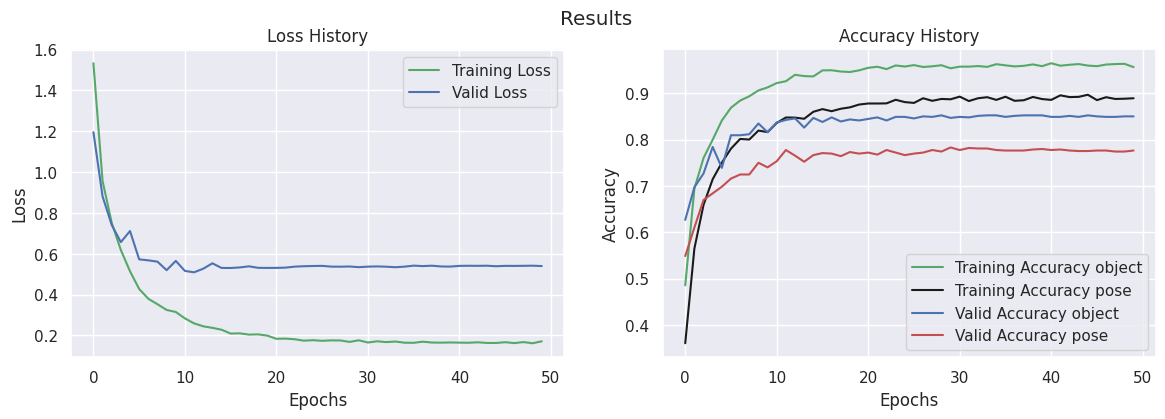

In [ ]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
      smoothed_val = w * last + (1 - w) * point
      smoothed.append(smoothed_val)
      ast = smoothed_val
          
    return smoothed

history2 = trainer2.getHistory()
trainer2.showResults()

best model was trained at epoch: 29
with a validation loss of: 0.53762907 and a validation accuracy of: 85.24228930473328


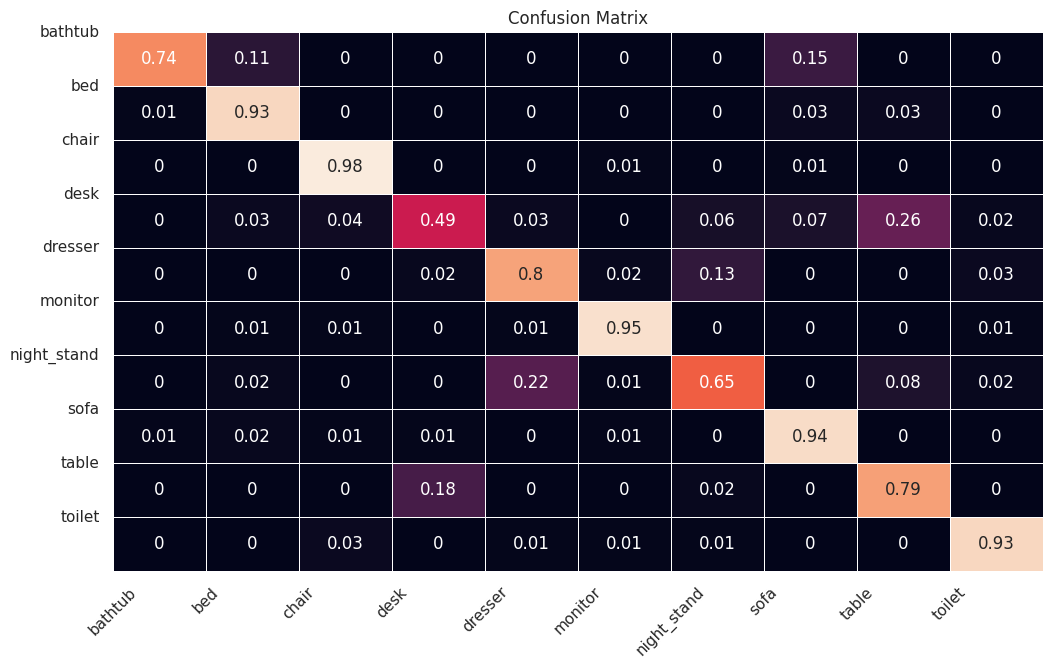

In [ ]:
trainer2.generateConfusionMatrix()

best model was trained at epoch: 29
with a validation loss of: 0.53762907 and a validation accuracy of: 85.24228930473328


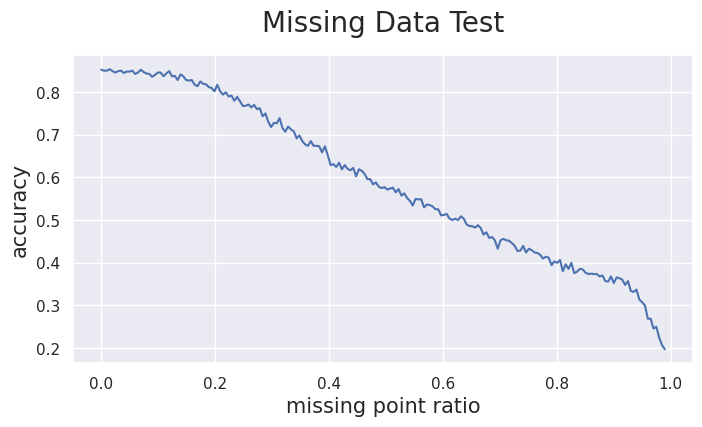

In [ ]:
trainer2.missing_data_test()

# DMPORION (double-max-pooling ORION)

In [14]:
class DMPORION(nn.Module):
    def __init__(self):
        super(DMPORION, self).__init__()
        n_classes = 10
        n_rotations = 8
        input_shape = (32,32,32)
        self.feat = torch.nn.Sequential(OrderedDict([
            ('conv3d_1', torch.nn.Conv3d(in_channels=1, out_channels=32, kernel_size=3, stride=1)),
            ('batch1', torch.nn.BatchNorm3d(32)),
            ('relu1', torch.nn.ReLU()),
            ('drop1', torch.nn.Dropout(p=0.2)),
            ('conv3d_2', torch.nn.Conv3d(in_channels=32, out_channels=64, kernel_size=3, stride=1)),
            ('relu2', torch.nn.ReLU()),
            ('drop2', torch.nn.Dropout(p=0.2)),
            ('pool2', torch.nn.MaxPool3d(2)),
            ('conv3d_3', torch.nn.Conv3d(in_channels=64, out_channels=128, kernel_size=3, stride=1)),
            ('relu3', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.3)),
            ('pool3', torch.nn.MaxPool3d(2)),
            ('conv3d_4', torch.nn.Conv3d(in_channels=128, out_channels=256,kernel_size=3, stride=1)),
            ('relu4', torch.nn.ReLU()),
            ('drop4', torch.nn.Dropout(p=0.4)),
            ('pool4', torch.nn.MaxPool3d(2))
        ]))
        
        x = self.feat(torch.autograd.Variable(torch.rand((1, 1) + input_shape)))
        dim_feat = 1
        for n in x.size()[1:]:
            dim_feat *= n

        self.mlp = torch.nn.Sequential(OrderedDict([
            ('fc1', torch.nn.Linear(dim_feat, 128)),
            ('relu1', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.4)),
            ('fc2', torch.nn.Linear(128, n_classes))
        ]))

        self.mlp2 = torch.nn.Sequential(OrderedDict([
            ('fc1', torch.nn.Linear(dim_feat, 128)),
            ('relu1', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.4)),
            ('fc2', torch.nn.Linear(128, n_rotations))
        ]))

        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.feat(x)
        x = x.view(x.size(0), -1)
        x1 = self.mlp(x)
        x2 = self.mlp2(x)
        return self.logsoftmax(x1), self.logsoftmax(x2)

**DMPVoxNet** training

In [ ]:
training_hyperparameters = {
    "learning_rate": 0.01,
    "sgd_momentum": 0.9,
    "data_size": 32,
    "epochs": 50,
    "lr_scheduler_step": 5,
    "lr_scheduler_gamma": 0.5,
    "train_batch_size": 64,
    "valid_batch_size": 32,
    "model" : 'DMPORION'
}    

trainer3 = Network_Trainer(training_hyperparameters)
trainer3.train()

model DMPVoxNet was choosen
62.359375


Train loss: 1.1532361507415771: : 62it [00:27,  2.27it/s]
29it [00:03,  7.62it/s]


epoch:  1 / 50
time: 31.11 seconds
train-loss: 1.56, train-acc-object: 47.56%, train-acc-pose: 35.56%
valid-loss: 1.53, valid-acc-object: 53.63%, train-acc-pose: 50.11%



Train loss: 0.6632782220840454: : 62it [00:26,  2.33it/s]
29it [00:02, 11.27it/s]


epoch:  2 / 50
time: 29.24 seconds
train-loss: 0.98, train-acc-object: 67.49%, train-acc-pose: 58.04%
valid-loss: 1.11, valid-acc-object: 70.26%, train-acc-pose: 62.33%



Train loss: 0.8250601887702942: : 62it [00:26,  2.32it/s]
29it [00:02, 11.13it/s]


epoch:  3 / 50
time: 29.37 seconds
train-loss: 0.73, train-acc-object: 76.23%, train-acc-pose: 67.82%
valid-loss: 1.00, valid-acc-object: 74.23%, train-acc-pose: 69.27%



Train loss: 0.5309044122695923: : 62it [00:26,  2.30it/s]
29it [00:02, 11.00it/s]


epoch:  4 / 50
time: 29.57 seconds
train-loss: 0.60, train-acc-object: 80.72%, train-acc-pose: 72.28%
valid-loss: 0.81, valid-acc-object: 75.33%, train-acc-pose: 66.52%



Train loss: 0.5498602390289307: : 62it [00:26,  2.31it/s]
29it [00:03,  7.63it/s]


epoch:  5 / 50
time: 30.62 seconds
train-loss: 0.54, train-acc-object: 81.80%, train-acc-pose: 74.57%
valid-loss: 0.89, valid-acc-object: 78.19%, train-acc-pose: 67.84%



Train loss: 0.3069379925727844: : 62it [00:26,  2.31it/s]
29it [00:02, 11.06it/s]


epoch:  6 / 50
time: 29.46 seconds
train-loss: 0.42, train-acc-object: 87.47%, train-acc-pose: 75.66%
valid-loss: 0.68, valid-acc-object: 81.94%, train-acc-pose: 72.91%



Train loss: 0.3799387514591217: : 62it [00:27,  2.29it/s]
29it [00:02, 10.91it/s]


epoch:  7 / 50
time: 29.74 seconds
train-loss: 0.38, train-acc-object: 88.46%, train-acc-pose: 78.30%
valid-loss: 0.63, valid-acc-object: 82.60%, train-acc-pose: 72.80%



Train loss: 0.31438279151916504: : 62it [00:26,  2.30it/s]
29it [00:02,  9.80it/s]


epoch:  8 / 50
time: 29.96 seconds
train-loss: 0.34, train-acc-object: 89.92%, train-acc-pose: 79.01%
valid-loss: 0.61, valid-acc-object: 79.19%, train-acc-pose: 73.90%



Train loss: 0.35299623012542725: : 62it [00:27,  2.27it/s]
29it [00:03,  9.48it/s]


epoch:  9 / 50
time: 30.40 seconds
train-loss: 0.32, train-acc-object: 90.57%, train-acc-pose: 80.75%
valid-loss: 0.64, valid-acc-object: 81.50%, train-acc-pose: 73.57%



Train loss: 0.3405115008354187: : 62it [00:27,  2.28it/s]
29it [00:02, 11.02it/s]


epoch: 10 / 50
time: 29.81 seconds
train-loss: 0.31, train-acc-object: 90.80%, train-acc-pose: 81.12%
valid-loss: 0.57, valid-acc-object: 82.60%, train-acc-pose: 75.66%



Train loss: 0.3281441926956177: : 62it [00:27,  2.29it/s]
29it [00:02, 11.08it/s]


epoch: 11 / 50
time: 29.75 seconds
train-loss: 0.27, train-acc-object: 92.24%, train-acc-pose: 82.74%
valid-loss: 0.56, valid-acc-object: 82.05%, train-acc-pose: 76.65%



Train loss: 0.19782957434654236: : 62it [00:27,  2.29it/s]
29it [00:03,  7.60it/s]


epoch: 12 / 50
time: 30.90 seconds
train-loss: 0.25, train-acc-object: 93.02%, train-acc-pose: 82.64%
valid-loss: 0.55, valid-acc-object: 84.03%, train-acc-pose: 77.09%



Train loss: 0.28876709938049316: : 62it [00:27,  2.29it/s]
29it [00:02, 11.00it/s]


epoch: 13 / 50
time: 29.72 seconds
train-loss: 0.24, train-acc-object: 93.42%, train-acc-pose: 84.53%
valid-loss: 0.50, valid-acc-object: 85.13%, train-acc-pose: 77.42%



Train loss: 0.20925870537757874: : 62it [00:27,  2.29it/s]
29it [00:02, 11.05it/s]


epoch: 14 / 50
time: 29.77 seconds
train-loss: 0.24, train-acc-object: 93.20%, train-acc-pose: 83.57%
valid-loss: 0.52, valid-acc-object: 84.58%, train-acc-pose: 77.31%



Train loss: 0.1695936620235443: : 62it [00:27,  2.29it/s]
29it [00:02, 10.46it/s]


epoch: 15 / 50
time: 29.85 seconds
train-loss: 0.23, train-acc-object: 93.65%, train-acc-pose: 84.07%
valid-loss: 0.51, valid-acc-object: 83.70%, train-acc-pose: 77.97%



Train loss: 0.22841677069664001: : 62it [00:27,  2.27it/s]
29it [00:03,  8.93it/s]


epoch: 16 / 50
time: 30.60 seconds
train-loss: 0.20, train-acc-object: 95.01%, train-acc-pose: 85.56%
valid-loss: 0.47, valid-acc-object: 85.90%, train-acc-pose: 77.97%



Train loss: 0.17161151766777039: : 62it [00:27,  2.29it/s]
29it [00:02, 11.09it/s]


epoch: 17 / 50
time: 29.68 seconds
train-loss: 0.19, train-acc-object: 95.49%, train-acc-pose: 86.21%
valid-loss: 0.49, valid-acc-object: 84.25%, train-acc-pose: 77.86%



Train loss: 0.15493923425674438: : 62it [00:27,  2.28it/s]
29it [00:02, 11.12it/s]


epoch: 18 / 50
time: 29.77 seconds
train-loss: 0.19, train-acc-object: 95.97%, train-acc-pose: 85.81%
valid-loss: 0.48, valid-acc-object: 84.58%, train-acc-pose: 77.86%



Train loss: 0.18654708564281464: : 62it [00:26,  2.30it/s]
29it [00:03,  7.99it/s]


epoch: 19 / 50
time: 30.63 seconds
train-loss: 0.18, train-acc-object: 95.26%, train-acc-pose: 86.52%
valid-loss: 0.48, valid-acc-object: 83.92%, train-acc-pose: 77.64%



Train loss: 0.14518016576766968: : 62it [00:27,  2.28it/s]
29it [00:02, 10.90it/s]


epoch: 20 / 50
time: 29.85 seconds
train-loss: 0.18, train-acc-object: 95.61%, train-acc-pose: 86.64%
valid-loss: 0.47, valid-acc-object: 85.02%, train-acc-pose: 77.31%



Train loss: 0.22177530825138092: : 62it [00:27,  2.28it/s]
29it [00:02, 11.13it/s]


epoch: 21 / 50
time: 29.78 seconds
train-loss: 0.17, train-acc-object: 95.97%, train-acc-pose: 87.50%
valid-loss: 0.47, valid-acc-object: 84.91%, train-acc-pose: 78.19%



Train loss: 0.1930902600288391: : 62it [00:27,  2.28it/s]
29it [00:02, 10.10it/s]


epoch: 22 / 50
time: 30.08 seconds
train-loss: 0.17, train-acc-object: 95.87%, train-acc-pose: 86.95%
valid-loss: 0.46, valid-acc-object: 85.90%, train-acc-pose: 78.08%



Train loss: 0.13855493068695068: : 62it [00:27,  2.24it/s]
29it [00:03,  8.65it/s]


epoch: 23 / 50
time: 31.09 seconds
train-loss: 0.16, train-acc-object: 96.50%, train-acc-pose: 87.30%
valid-loss: 0.47, valid-acc-object: 85.57%, train-acc-pose: 77.86%



Train loss: 0.19273877143859863: : 62it [00:27,  2.26it/s]
29it [00:02, 10.84it/s]


epoch: 24 / 50
time: 30.10 seconds
train-loss: 0.16, train-acc-object: 96.24%, train-acc-pose: 87.27%
valid-loss: 0.47, valid-acc-object: 84.47%, train-acc-pose: 77.31%



Train loss: 0.3144233822822571: : 62it [00:27,  2.27it/s]
29it [00:02, 10.93it/s]


epoch: 25 / 50
time: 29.95 seconds
train-loss: 0.16, train-acc-object: 96.65%, train-acc-pose: 88.03%
valid-loss: 0.47, valid-acc-object: 85.46%, train-acc-pose: 77.97%



Train loss: 0.18128350377082825: : 62it [00:27,  2.28it/s]
29it [00:03,  7.54it/s]


epoch: 26 / 50
time: 31.09 seconds
train-loss: 0.16, train-acc-object: 96.14%, train-acc-pose: 88.00%
valid-loss: 0.46, valid-acc-object: 85.13%, train-acc-pose: 77.86%



Train loss: 0.14995048940181732: : 62it [00:27,  2.26it/s]
29it [00:02, 10.43it/s]


epoch: 27 / 50
time: 30.18 seconds
train-loss: 0.15, train-acc-object: 96.62%, train-acc-pose: 87.85%
valid-loss: 0.46, valid-acc-object: 85.24%, train-acc-pose: 77.20%



Train loss: 0.1277441531419754: : 62it [00:27,  2.27it/s]
29it [00:02, 10.82it/s]


epoch: 28 / 50
time: 29.98 seconds
train-loss: 0.15, train-acc-object: 97.00%, train-acc-pose: 88.58%
valid-loss: 0.46, valid-acc-object: 85.35%, train-acc-pose: 78.08%



Train loss: 0.1848839968442917: : 62it [00:27,  2.28it/s]
29it [00:03,  8.58it/s]


epoch: 29 / 50
time: 30.63 seconds
train-loss: 0.15, train-acc-object: 96.93%, train-acc-pose: 88.46%
valid-loss: 0.47, valid-acc-object: 85.02%, train-acc-pose: 78.19%



Train loss: 0.1606462597846985: : 62it [00:27,  2.25it/s]
29it [00:02, 10.62it/s]


epoch: 30 / 50
time: 30.35 seconds
train-loss: 0.15, train-acc-object: 96.93%, train-acc-pose: 88.89%
valid-loss: 0.46, valid-acc-object: 84.80%, train-acc-pose: 77.75%



Train loss: 0.1546492576599121: : 62it [00:27,  2.27it/s]
29it [00:02, 10.41it/s]


epoch: 31 / 50
time: 30.14 seconds
train-loss: 0.14, train-acc-object: 97.35%, train-acc-pose: 88.46%
valid-loss: 0.46, valid-acc-object: 85.13%, train-acc-pose: 77.53%



Train loss: 0.1322241723537445: : 62it [00:27,  2.26it/s]
29it [00:02, 10.23it/s]


epoch: 32 / 50
time: 30.30 seconds
train-loss: 0.14, train-acc-object: 96.85%, train-acc-pose: 88.86%
valid-loss: 0.46, valid-acc-object: 84.80%, train-acc-pose: 78.19%



Train loss: 0.1595926284790039: : 62it [00:27,  2.23it/s]
29it [00:03,  8.93it/s]


epoch: 33 / 50
time: 31.02 seconds
train-loss: 0.14, train-acc-object: 97.05%, train-acc-pose: 88.76%
valid-loss: 0.46, valid-acc-object: 85.02%, train-acc-pose: 77.53%



Train loss: 0.10195235908031464: : 62it [00:27,  2.25it/s]
29it [00:02, 10.42it/s]


epoch: 34 / 50
time: 30.35 seconds
train-loss: 0.14, train-acc-object: 96.95%, train-acc-pose: 88.86%
valid-loss: 0.46, valid-acc-object: 85.79%, train-acc-pose: 78.41%



Train loss: 0.1843222826719284: : 62it [00:27,  2.25it/s]
29it [00:02, 10.48it/s]


epoch: 35 / 50
time: 30.36 seconds
train-loss: 0.14, train-acc-object: 96.95%, train-acc-pose: 88.79%
valid-loss: 0.46, valid-acc-object: 85.24%, train-acc-pose: 78.19%



Train loss: 0.08159582316875458: : 62it [00:27,  2.25it/s]
29it [00:03,  7.62it/s]


epoch: 36 / 50
time: 31.35 seconds
train-loss: 0.14, train-acc-object: 97.15%, train-acc-pose: 88.79%
valid-loss: 0.46, valid-acc-object: 85.13%, train-acc-pose: 78.08%



Train loss: 0.13500261306762695: : 62it [00:27,  2.26it/s]
29it [00:02, 10.64it/s]


epoch: 37 / 50
time: 30.19 seconds
train-loss: 0.14, train-acc-object: 97.18%, train-acc-pose: 88.86%
valid-loss: 0.46, valid-acc-object: 85.13%, train-acc-pose: 77.97%



Train loss: 0.08810944855213165: : 62it [00:27,  2.25it/s]
29it [00:02, 10.62it/s]


epoch: 38 / 50
time: 30.27 seconds
train-loss: 0.14, train-acc-object: 97.25%, train-acc-pose: 88.33%
valid-loss: 0.46, valid-acc-object: 85.46%, train-acc-pose: 78.19%



Train loss: 0.15796121954917908: : 62it [00:27,  2.26it/s]
29it [00:04,  7.19it/s]


epoch: 39 / 50
time: 31.52 seconds
train-loss: 0.14, train-acc-object: 97.40%, train-acc-pose: 88.66%
valid-loss: 0.46, valid-acc-object: 85.13%, train-acc-pose: 78.19%



Train loss: 0.12684312462806702: : 62it [00:27,  2.25it/s]
29it [00:02, 10.36it/s]


epoch: 40 / 50
time: 30.31 seconds
train-loss: 0.13, train-acc-object: 97.83%, train-acc-pose: 88.79%
valid-loss: 0.46, valid-acc-object: 85.46%, train-acc-pose: 78.30%



Train loss: 0.16726712882518768: : 62it [00:27,  2.25it/s]
29it [00:02, 10.46it/s]


epoch: 41 / 50
time: 30.35 seconds
train-loss: 0.14, train-acc-object: 96.90%, train-acc-pose: 88.53%
valid-loss: 0.46, valid-acc-object: 85.79%, train-acc-pose: 78.41%



Train loss: 0.21669098734855652: : 62it [00:27,  2.26it/s]
29it [00:03,  7.50it/s]


epoch: 42 / 50
time: 31.38 seconds
train-loss: 0.13, train-acc-object: 97.30%, train-acc-pose: 88.76%
valid-loss: 0.46, valid-acc-object: 85.68%, train-acc-pose: 78.30%



Train loss: 0.20022931694984436: : 62it [00:27,  2.25it/s]
29it [00:02, 10.58it/s]


epoch: 43 / 50
time: 30.31 seconds
train-loss: 0.14, train-acc-object: 96.65%, train-acc-pose: 88.89%
valid-loss: 0.46, valid-acc-object: 85.35%, train-acc-pose: 78.41%



Train loss: 0.1270793080329895: : 62it [00:27,  2.25it/s]
29it [00:02, 10.57it/s]


epoch: 44 / 50
time: 30.32 seconds
train-loss: 0.14, train-acc-object: 97.38%, train-acc-pose: 88.79%
valid-loss: 0.46, valid-acc-object: 85.46%, train-acc-pose: 78.30%



Train loss: 0.12993234395980835: : 62it [00:27,  2.25it/s]
29it [00:03,  8.18it/s]


epoch: 45 / 50
time: 31.10 seconds
train-loss: 0.15, train-acc-object: 96.82%, train-acc-pose: 88.61%
valid-loss: 0.46, valid-acc-object: 85.46%, train-acc-pose: 78.52%



Train loss: 0.13919638097286224: : 62it [00:27,  2.24it/s]
29it [00:02, 10.70it/s]


epoch: 46 / 50
time: 30.46 seconds
train-loss: 0.14, train-acc-object: 97.28%, train-acc-pose: 89.14%
valid-loss: 0.46, valid-acc-object: 85.35%, train-acc-pose: 78.41%



Train loss: 0.17661380767822266: : 62it [00:27,  2.25it/s]
29it [00:02, 10.70it/s]


epoch: 47 / 50
time: 30.23 seconds
train-loss: 0.14, train-acc-object: 96.95%, train-acc-pose: 88.66%
valid-loss: 0.46, valid-acc-object: 85.13%, train-acc-pose: 78.08%



Train loss: 0.09583770483732224: : 62it [00:27,  2.25it/s]
29it [00:03,  9.07it/s]


epoch: 48 / 50
time: 30.75 seconds
train-loss: 0.13, train-acc-object: 97.18%, train-acc-pose: 88.79%
valid-loss: 0.46, valid-acc-object: 85.13%, train-acc-pose: 78.19%



Train loss: 0.16922500729560852: : 62it [00:27,  2.22it/s]
29it [00:02, 10.16it/s]


epoch: 49 / 50
time: 30.75 seconds
train-loss: 0.14, train-acc-object: 97.15%, train-acc-pose: 89.11%
valid-loss: 0.46, valid-acc-object: 85.13%, train-acc-pose: 78.30%



Train loss: 0.11101320385932922: : 62it [00:27,  2.25it/s]
29it [00:02, 10.54it/s]

epoch: 50 / 50
time: 30.32 seconds
train-loss: 0.14, train-acc-object: 97.25%, train-acc-pose: 88.96%
valid-loss: 0.46, valid-acc-object: 85.24%, train-acc-pose: 78.30%



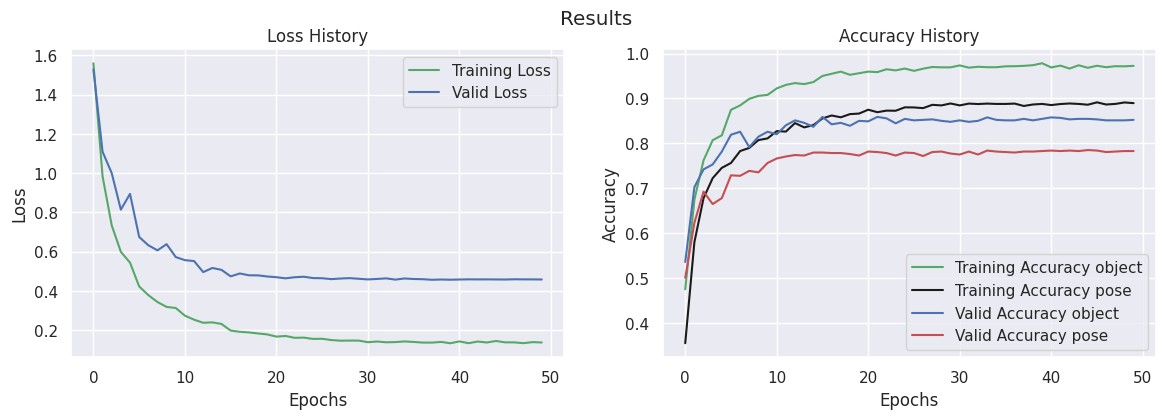

In [ ]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
      smoothed_val = w * last + (1 - w) * point
      smoothed.append(smoothed_val)
      ast = smoothed_val
          
    return smoothed

history3 = trainer3.getHistory()
trainer3.showResults()

best model was trained at epoch: 16
with a validation loss of: 0.47428238 and a validation accuracy of: 85.90308427810669


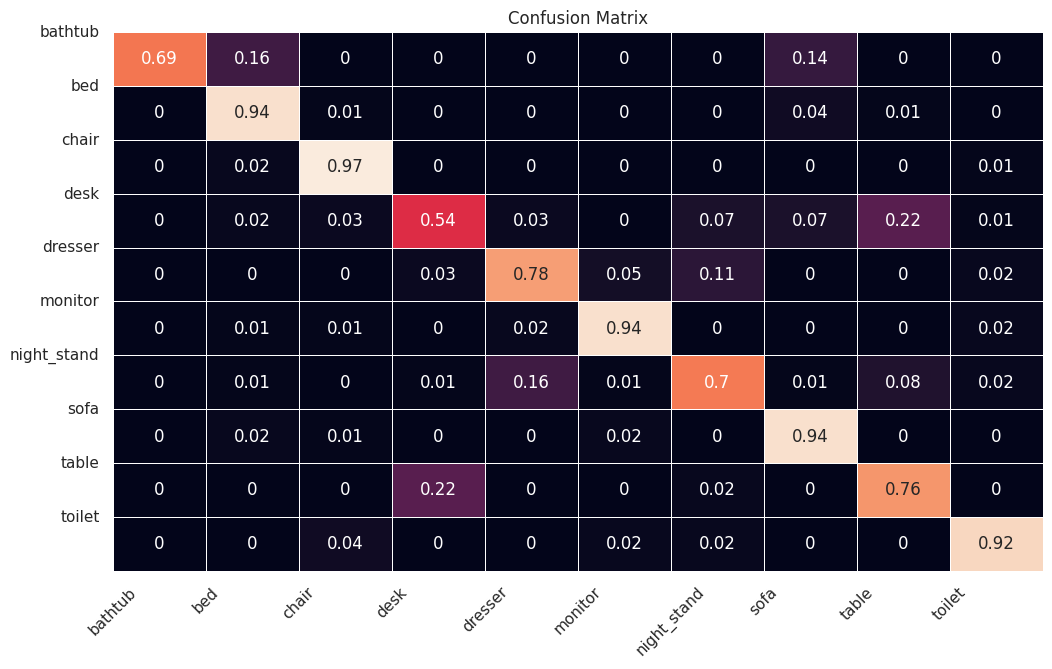

In [ ]:
trainer3.generateConfusionMatrix()

best model was trained at epoch: 16
with a validation loss of: 0.47428238 and a validation accuracy of: 85.90308427810669


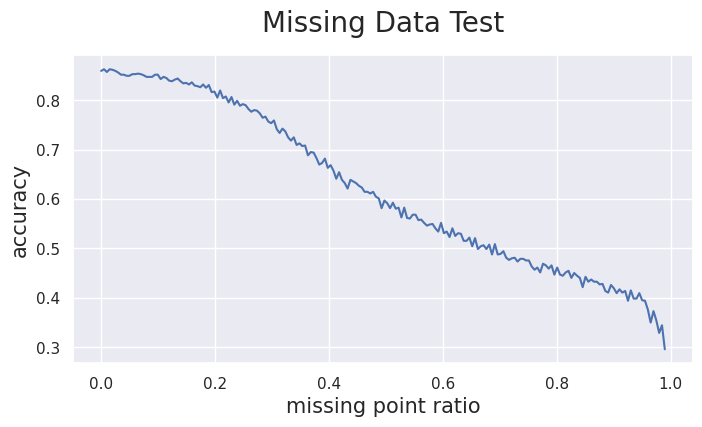

In [ ]:
trainer3.missing_data_test()

# Network model comparison

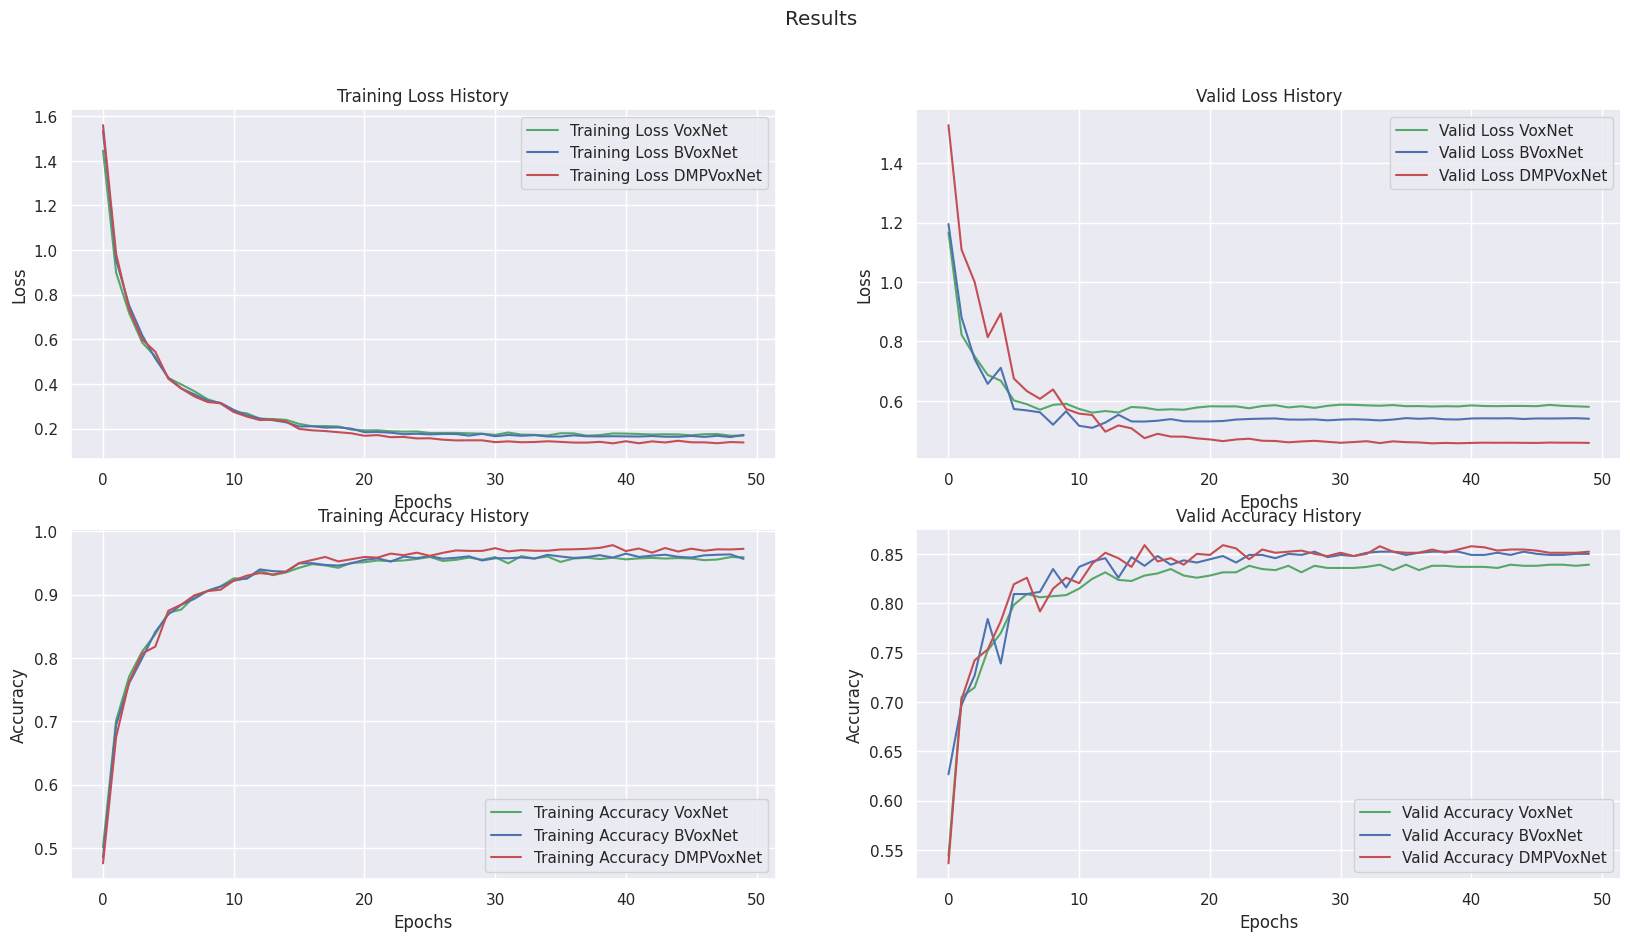

In [ ]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
      smoothed_val = w * last + (1 - w) * point
      smoothed.append(smoothed_val)
      ast = smoothed_val
          
    return smoothed

eps = range(0, len(history1["train_loss"].cpu()))
        
sns.set_theme()
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
fig.suptitle('Results')
        
ax[0,0].plot(eps, smooth(history1["train_loss"].cpu()), 'g', label='Training Loss VoxNet')
ax[0,0].plot(eps, smooth(history2["train_loss"].cpu()), 'b', label='Training Loss ORION')
ax[0,0].plot(eps, smooth(history3["train_loss"].cpu()), 'r', label='Training Loss DMPORION')
ax[0,0].set_title('Training Loss History')
ax[0,0].set(xlabel='Epochs', ylabel='Loss')
ax[0,0].legend()
        
ax[0,1].plot(eps, smooth(history1["valid_loss"].cpu()), 'g', label='Valid Loss VoxNet')
ax[0,1].plot(eps, smooth(history2["valid_loss"].cpu()), 'b', label='Valid Loss ORION')
ax[0,1].plot(eps, smooth(history3["valid_loss"].cpu()), 'r', label='Valid Loss DMPORION')
ax[0,1].set_title('Valid Loss History')
ax[0,1].set(xlabel='Epochs', ylabel='Loss')
ax[0,1].legend()

ax[1,0].plot(eps, smooth(history1["train_acc1"].cpu()), 'g', label='Training Accuracy VoxNet')
ax[1,0].plot(eps, smooth(history2["train_acc1"].cpu()), 'b', label='Training Accuracy ORION')
ax[1,0].plot(eps, smooth(history3["train_acc1"].cpu()), 'r', label='Training Accuracy DMPORION')
ax[1,0].set_title('Training Accuracy History')
ax[1,0].set(xlabel='Epochs', ylabel='Accuracy')
ax[1,0].legend()

ax[1,1].plot(eps, smooth(history1["valid_acc1"].cpu()), 'g', label='Valid Accuracy VoxNet')
ax[1,1].plot(eps, smooth(history2["valid_acc1"].cpu()), 'b', label='Valid Accuracy ORION')
ax[1,1].plot(eps, smooth(history3["valid_acc1"].cpu()), 'r', label='Valid Accuracy DMPORION')
ax[1,1].set_title('Valid Accuracy History')
ax[1,1].set(xlabel='Epochs', ylabel='Accuracy')
ax[1,1].legend()

# Data Augmentation



In [4]:
ROOT = '/content/ModelNet10/'
CLASSES = ['bathtub', 'bed', 'chair', 'desk', 'dresser', 'monitor', 'night_stand', 'sofa', 'table', 'toilet']
ROTATIONS = ['0', '45', '90', '135', '180', '225', '270', '315']

#rotations matrix
r45 = np.array([[math.sqrt(2)/2,-math.sqrt(2)/2,0], [math.sqrt(2)/2,math.sqrt(2)/2,0], [0,0,1]], np.float64)
r90 = np.array([[0,-1,0], [1,0,0], [0,0,1]], np.float64)
r135 = np.array([[-math.sqrt(2)/2,-math.sqrt(2)/2,0], [math.sqrt(2)/2,-math.sqrt(2)/2,0], [0,0,1]], np.float64)
r180 = np.array([[-1,0,0], [0,-1,0], [0,0,1]], np.float64)
r225 = np.array([[-math.sqrt(2)/2,math.sqrt(2)/2,0], [-math.sqrt(2)/2,-math.sqrt(2)/2,0], [0,0,1]], np.float64)
r270 = np.array([[0,1,0], [-1,0,0], [0,0,1]], np.float64)
r315 = np.array([[math.sqrt(2)/2,math.sqrt(2)/2,0], [-math.sqrt(2)/2,math.sqrt(2)/2,0], [0,0,1]], np.float64)

X_a = {'train': [], 'test': []}
Y_a = {'train': [], 'test': []}
Z_a = {'train': [], 'test': []}

for label1, cl in enumerate(CLASSES):
    for label2, rot in enumerate(ROTATIONS):
        split = 'train'
        examples_dir = os.path.join(ROOT, cl, split)
        for example in tqdm(os.listdir(examples_dir)):
            voxel_index = []
            if 'off' in example:
              mesh = o3d.io.read_triangle_mesh(examples_dir+'/'+example)
              if rot == '0':
                mesh = mesh
              elif rot == '45':
                mesh.rotate(r45)
              elif rot == '90':
                mesh.rotate(r90)
              elif rot == '135':
                mesh.rotate(r135)  
              elif rot == '180':
                mesh.rotate(r180)
              elif rot == '225':
                mesh.rotate(r225)
              elif rot == '270':
                mesh.rotate(r270)
              else:
                mesh.rotate(r315)
        
              mesh.scale(1 / np.max(mesh.get_max_bound() - mesh.get_min_bound()), center=mesh.get_center())
              voxel_grid = o3d.geometry.VoxelGrid.create_from_triangle_mesh(mesh, voxel_size=0.05)
                
            X_a[split].append(voxel_grid)
            Y_a[split].append(label1)
            Z_a[split].append(label2)

rot = 0
for label1, cl in enumerate(CLASSES):
    split = 'test'
    examples_dir = os.path.join(ROOT, cl, split)
    for example in tqdm(os.listdir(examples_dir)):
        voxel_index = []
        if 'off' in example:
          mesh = o3d.io.read_triangle_mesh(examples_dir+'/'+example)
          if (rot%8)==0:
            mesh = mesh
            rotat = 0
            rot +=1
          elif (rot%8)==1:
            mesh.rotate(r45)
            rotat = 1
            rot +=1
          elif (rot%8)==2:
            mesh.rotate(r90)
            rotat = 2
            rot +=1
          elif (rot%8)==3:
            mesh.rotate(r135) 
            rotat = 3 
            rot +=1
          elif (rot%8)==4:
            mesh.rotate(r180)
            rotat = 4
            rot +=1
          elif (rot%8)==5:
            mesh.rotate(r225)
            rotat = 5
            rot +=1
          elif (rot%8)==6:
            mesh.rotate(r270)
            rotat = 6
            rot +=1
          else:
            mesh.rotate(r315)
            rotat = 7
            rot +=1
          mesh.scale(1 / np.max(mesh.get_max_bound() - mesh.get_min_bound()), center=mesh.get_center())
          voxel_grid = o3d.geometry.VoxelGrid.create_from_triangle_mesh(mesh, voxel_size=0.05)
                
          X_a[split].append(voxel_grid)
          Y_a[split].append(label1)
          Z_a[split].append(rotat)


100%|██████████| 101/101 [00:04<00:00, 22.90it/s]


In [7]:
class Network_Dataset_a(Dataset):
    def __init__(self, train = True):
      if train:
          self.data = X_a['train']
          self.label1 = Y_a['train']
          self.label2 = Z_a['train']
      else:
          self.data = X_a['test']
          self.label1 = Y_a['test']
          self.label2 = Z_a['test']
        
                
    def __len__(self):
        return len(self.label1)

    def __preproc__(self, voxels):
        
        voxel_grid = voxels.get_voxels()
        vox_g = np.zeros((32, 32, 32), dtype=np.int32)
        for i in range (len(voxel_grid)):
          voxel_index = voxel_grid[i].grid_index
          vox_g[voxel_index[0],voxel_index[1],voxel_index[2]] = 1
        
        return vox_g.copy()

    def __getitem__(self, idx):
        label1 = self.label1[idx]
        label2 = self.label2[idx]
        voxels = self.data[idx]
        voxels = self.__preproc__(voxels)
        voxels = np.expand_dims(voxels, axis=0)
        voxels = torch.tensor(voxels).float()
        return voxels, label1, label2

In [10]:
class Network_Trainer_a():
  def __init__(self, hyperparameters):
      #Hypreparameters
      self.learning_rate = hyperparameters["learning_rate"]
      self.batch_size_train = hyperparameters["train_batch_size"]
      self.batch_size_test = hyperparameters["valid_batch_size"]
      self.data_size = hyperparameters["data_size"]
      self.sgd_momentum = hyperparameters["sgd_momentum"]
      self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
      self.epochs = hyperparameters["epochs"]
      self.name_model = hyperparameters["model"]
      self.best_acc = 0
      
      #Dataset
      self.initDataset()
      self.class_names = ["bathtub", "bed", "chair", "desk", "dresser", "monitor", "night_stand", "sofa", "table", "toilet"]
      self.rotation_names = ['0', '45', '90', '135', '180', '225', '270', '315']
      self.num_classes = len(self.class_names)
      self.num_rotations = len(self.rotation_names)

      #Model
      self.lr_scheduler_step = hyperparameters["lr_scheduler_step"]
      self.lr_scheduler_gamma = hyperparameters["lr_scheduler_gamma"]
      self.initModel()
  
  def initDataset(self):
      self.train_ds = Network_Dataset_a(train=True)
      self.test_ds = Network_Dataset_a(train=False)
      self.train_dataloader = DataLoader(dataset=self.train_ds, batch_size=self.batch_size_train, shuffle=True, drop_last=True)
      self.test_dataloader = DataLoader(dataset=self.test_ds, batch_size=self.batch_size_test)

  def initModel(self):
      if self.name_model == "VoxNet_a":
          self.model = VoxNet()
          os.mkdir('/content/'+str(self.name_model))
          print("model VoxNet was chosen")
      elif self.name_model == "ORION_a":
          self.model = ORION()
          os.mkdir('/content/'+str(self.name_model))
          print("model ORION was chosen")
      else:
        self.model = DMPORION()
        os.mkdir('/content/'+str(self.name_model))
        print('model DMPORION was choosen')
      self.device = "cuda" if torch.cuda.is_available() else "cpu"
      self.model.to(self.device)
      
      self.opt = SGD(self.model.parameters(), lr=self.learning_rate, momentum=self.sgd_momentum)
      self.loss_fn = nn.CrossEntropyLoss()
      self.lr_scheduler = torch.optim.lr_scheduler.StepLR(self.opt, step_size=self.lr_scheduler_step, gamma=self.lr_scheduler_gamma)
     
  def train(self):
      self.pred_conf, self.y_conf = [], []                                                           
      train_loss_history, valid_loss_history = [], []
      train_acc_history1, valid_acc_history1 = [], []
      train_acc_history2, valid_acc_history2 = [], []
      train_accuracy1 = Accuracy(task='multiclass', num_classes=self.num_classes)
      valid_accuracy1 = Accuracy(task='multiclass', num_classes=self.num_classes)
      train_accuracy2 = Accuracy(task='multiclass', num_classes=self.num_rotations)
      valid_accuracy2 = Accuracy(task='multiclass', num_classes=self.num_rotations)
      self.alpha = 2/3
    

      self.num_batch = len(self.train_ds) / self.batch_size_train
      print(self.num_batch)

      total_time = time.time()

      for epoch in range(self.epochs):
          t = time.time()

          #track training loss
          train_loss = []                                                         
          valid_loss = []

          #training phase
          self.model.train()
          iterator = tqdm(enumerate(self.train_dataloader, 0))
          for i, data in iterator:
              inputs, labels1, labels2 = data[0], data[1], data[2]
              inputs = inputs.to(self.device)
              labels1 = labels1.to(self.device)
              labels2 = labels2.to(self.device)

              self.opt.zero_grad()
              pred1, pred2 = self.model(inputs)  # torch.Size([256, 10])
              loss = self.alpha*self.loss_fn(pred1, labels1) + (1-self.alpha)*self.loss_fn(pred2, labels2)
              train_loss.append(loss.cpu().data)
              train_accuracy1.update(torch.argmax(pred1, 1).cpu(), labels1.cpu()) 
              train_accuracy2.update(torch.argmax(pred2, 1).cpu(), labels2.cpu()) 
            
              loss.backward()
              self.opt.step()
              iterator.set_description(f"Train loss: {loss.cpu().data}")
              
          self.lr_scheduler.step()
                      
          #test phase
          with torch.no_grad():
            self.model.eval()
            pred_test1 = []       
            pred_test2 = []  
            for j, sample in tqdm(enumerate(self.test_dataloader, 0)):    
                inputs_test, labels_test1, labels_test2 = sample[0], sample[1], sample[2]
                inputs_test = inputs_test.to(self.device)
                labels_test1 = labels_test1.to(self.device)
                labels_test2 = labels_test2.to(self.device)
                inputs_test = inputs_test.float()  
               
                pred_test1, pred_test2 = self.model(inputs_test)  # torch.Size([256, 10])
                loss_test = self.alpha*self.loss_fn(pred_test1, labels_test1) + (1-self.alpha)*self.loss_fn(pred_test2, labels_test2)
                valid_loss.append(loss_test.cpu().data)
                valid_accuracy1.update(torch.argmax(pred_test1, 1).cpu(), labels_test1.cpu()) 
                valid_accuracy2.update(torch.argmax(pred_test2, 1).cpu(), labels_test2.cpu()) 
                
                #correct_test = pred_choice_test.eq(labels_test.data).cpu().sum()
                self.pred_conf.append(torch.argmax(pred_test1, 1))
                self.y_conf.append(labels_test1)
      

          # total accuracy over all batches
          total_train_accuracy1 = train_accuracy1.compute()
          total_train_accuracy2 = train_accuracy2.compute()
          total_valid_accuracy1 = valid_accuracy1.compute()
          total_valid_accuracy2 = valid_accuracy2.compute()
          train_accuracy1.reset()
          valid_accuracy1.reset()
          train_accuracy2.reset()
          valid_accuracy2.reset()
            
          #track loss and acc for plotting
          train_loss_history.append(torch.mean(torch.tensor(train_loss)))
          valid_loss_history.append(torch.mean(torch.tensor(valid_loss)))
          train_acc_history1.append(total_train_accuracy1)
          train_acc_history2.append(total_train_accuracy2)
          valid_acc_history1.append(total_valid_accuracy1)
          valid_acc_history2.append(total_valid_accuracy2)
          
            
          elapsed_time_epoch = time.time() - t   
            
          tmp0 = "epoch:{:3d} /{:3d}".format(epoch+1, self.epochs)
          tmp1 = "time: {:.2f} seconds".format(elapsed_time_epoch)
          tmp2 = "train-loss: {:4.2f}, train-acc-object: {:.2%}, train-acc-pose: {:.2%}".format(train_loss_history[epoch], train_acc_history1[epoch].item(), train_acc_history2[epoch].item())
          tmp3 = "valid-loss: {:4.2f}, valid-acc-object: {:.2%}, train-acc-pose: {:.2%}\n".format(valid_loss_history[epoch], valid_acc_history1[epoch].item(), valid_acc_history2[epoch].item())
          print(tmp0, tmp1, tmp2, tmp3, sep="\n")


          ##save best model 
          if total_valid_accuracy1.numpy()>self.best_acc:
              self.best_acc = total_valid_accuracy1.numpy()
              torch.save({'epoch': epoch+1,
                          'model_state_dict': self.model.state_dict(),
                          'optimizer_state_dict': self.opt.state_dict(),
                          'loss': valid_loss_history[-1], 
                          'accuracy': total_valid_accuracy1},
	                        '/content/'+str(self.name_model)+'/best_model.pth')

          
          #save history
          self.history = {"train_loss": torch.tensor(train_loss_history), "train_acc1": torch.tensor(train_acc_history1), "train_acc2": torch.tensor(train_acc_history2), 
                          "valid_loss": torch.tensor(valid_loss_history), "valid_acc1": torch.tensor(valid_acc_history1), "valid_acc2": torch.tensor(valid_acc_history2)}
           
  def getHistory(self):
      return self.history

  def generateConfusionMatrix(self):
      ##load the model
      checkpoint = torch.load('/content/'+str(self.name_model)+'/best_model.pth')
      self.model.load_state_dict(checkpoint['model_state_dict'])
      self.opt.load_state_dict(checkpoint['optimizer_state_dict'])
      loss = checkpoint['loss']
      epoch = checkpoint['epoch']
      acc = checkpoint['accuracy']
      print('best model was trained at epoch: '+str(epoch))
      print('with a validation loss of: '+str(loss.numpy())+' and a validation accuracy of: '+str(acc.numpy()*100))
  
      ##compute confusion matrix
      self.model.eval()
      a = torch.cat(self.pred_conf).cpu()
      b = torch.cat(self.y_conf).cpu()
      confmat = ConfusionMatrix(task='multiclass', num_classes=10, normalize="true")
      self.conf_matrix = confmat(a, b)
      self.conf_matrix = torch.round(self.conf_matrix, decimals=2)

      fig=plt.figure(figsize = (12,7))
      sns.heatmap(self.conf_matrix, annot=True, fmt='g', linewidths=.4, cbar=False)
      tick_marks = np.arange(len(self.class_names))
      plt.xticks(tick_marks, self.class_names, rotation=45)
      plt.yticks(tick_marks, self.class_names, rotation=0)
      plt.title("Confusion Matrix")     

  def getPerClassAccuracy(self):
      per_class_accuracy = 100 * torch.diag(self.conf_matrix) / torch.sum(self.conf_matrix, 1)
      tmp = {}
      for i, x in enumerate(self.class_names):
        tmp[x] = per_class_accuracy[i].item()
      print(tmp)
    
  def showResults(self):
      eps = range(0, len(self.history["train_loss"].cpu()))
        
      sns.set_theme()
      fig, ax = plt.subplots(1, 2, figsize=(14, 4))
      fig.suptitle('Results')
        
      ax[0].plot(eps, smooth(self.history["train_loss"].cpu()), 'g', label='Training Loss')
      ax[0].plot(eps, smooth(self.history["valid_loss"].cpu()), 'b', label='Valid Loss')
      ax[0].set_title('Loss History')
      ax[0].set(xlabel='Epochs', ylabel='Loss')
      ax[0].legend()
        
      ax[1].plot(eps, smooth(self.history["train_acc1"].cpu()), 'g', label='Training Accuracy object')
      ax[1].plot(eps, smooth(self.history["train_acc2"].cpu()), 'k', label='Training Accuracy pose')
      ax[1].plot(eps, smooth(self.history["valid_acc1"].cpu()), 'b', label='Valid Accuracy object')
      ax[1].plot(eps, smooth(self.history["valid_acc2"].cpu()), 'r', label='Valid Accuracy pose')
      ax[1].set_title('Accuracy History')
      ax[1].set(xlabel='Epochs', ylabel='Accuracy')
      ax[1].legend()

  def draw_voxels(self):
      mesh = next(iter(self.train_dataloader))
      mesh = mesh[0][0][0]
        
      ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
      ax.voxels(mesh, edgecolor='k')
      plt.show()
        
  def test_on_missing_data(self, missing_rate=0.5):
      test_accuracy = Accuracy(task='multiclass', num_classes=10)

      ##load the model
      checkpoint = torch.load('/content/'+str(self.name_model)+'/best_model.pth')
      self.model.load_state_dict(checkpoint['model_state_dict'])
      self.opt.load_state_dict(checkpoint['optimizer_state_dict'])
      loss = checkpoint['loss']
      epoch = checkpoint['epoch']
      acc = checkpoint['accuracy']
  
      self.model.eval()
      for x, y, z in self.test_dataloader:
          x, y, z = x.to(self.device), y.to(self.device), z.to(self.device)
            
          idc = np.random.choice(32**3, size=(int(32**3*missing_rate)), replace=False)
          idc_x = idc%32
          idc_y = np.floor_divide(idc, 32)%32
          idc_z = np.floor_divide(idc, 32*32)%32
          x[:, :, idc_x, idc_y, idc_z] = 0
            
          pred = self.model(x)[0]
          test_accuracy.update(torch.argmax(pred, 1).cpu(), y.cpu())
            
      return test_accuracy.compute()
    
  def missing_data_test(self):
      acc = []
      delta = 200
      eps = np.linspace(0,0.99,delta)

      ##load the model
      checkpoint = torch.load('/content/'+str(self.name_model)+'/best_model.pth')
      self.model.load_state_dict(checkpoint['model_state_dict'])
      self.opt.load_state_dict(checkpoint['optimizer_state_dict'])
      loss = checkpoint['loss']
      epoch = checkpoint['epoch']
      accu = checkpoint['accuracy']
      print('best model was trained at epoch: '+str(epoch))
      print('with a validation loss of: '+str(loss.numpy())+' and a validation accuracy of: '+str(accu.numpy()*100))

      for x in eps:
          tmp = self.test_on_missing_data(x)
          acc.append(tmp)
            
            
      sns.set_theme()
      plt.figure(figsize=(8, 4))
      plt.plot(eps, smooth(acc))
      plt.title("Missing Data Test", size=20, y=1.05)
      plt.xlabel("missing point ratio", size=15)
      plt.ylabel("accuracy", size=15)
      plt.show()

In [15]:
training_hyperparameters = {
     "learning_rate": 0.001,
    "sgd_momentum": 0.9,
    "data_size": 32,
    "epochs": 50,
    "lr_scheduler_step": 10,
    "lr_scheduler_gamma": 0.5,
    "train_batch_size": 64,
    "valid_batch_size": 32,
    "model" : 'VoxNet_a'
}    

trainer4 = Network_Trainer_a(training_hyperparameters)
trainer4.train()

model VoxNet was chosen
499.25


Train loss: 0.8538787364959717: : 499it [01:39,  5.00it/s]
29it [00:02, 13.41it/s]


epoch:  1 / 50
time: 101.98 seconds
train-loss: 1.11, train-acc-object: 63.74%, train-acc-pose: 52.45%
valid-loss: 0.81, valid-acc-object: 70.93%, train-acc-pose: 64.43%



Train loss: 0.46111881732940674: : 499it [01:30,  5.53it/s]
29it [00:02, 14.21it/s]


epoch:  2 / 50
time: 92.24 seconds
train-loss: 0.67, train-acc-object: 79.27%, train-acc-pose: 68.35%
valid-loss: 0.61, valid-acc-object: 78.30%, train-acc-pose: 70.48%



Train loss: 0.7866047620773315: : 499it [01:30,  5.51it/s]
29it [00:02, 12.75it/s]


epoch:  3 / 50
time: 92.87 seconds
train-loss: 0.53, train-acc-object: 84.14%, train-acc-pose: 72.93%
valid-loss: 0.54, valid-acc-object: 81.94%, train-acc-pose: 72.91%



Train loss: 0.4227847456932068: : 499it [01:29,  5.59it/s]
29it [00:02,  9.82it/s]


epoch:  4 / 50
time: 92.25 seconds
train-loss: 0.47, train-acc-object: 86.41%, train-acc-pose: 75.22%
valid-loss: 0.49, valid-acc-object: 83.59%, train-acc-pose: 74.67%



Train loss: 0.4123246967792511: : 499it [01:29,  5.56it/s]
29it [00:02, 10.93it/s]


epoch:  5 / 50
time: 92.48 seconds
train-loss: 0.42, train-acc-object: 87.89%, train-acc-pose: 76.98%
valid-loss: 0.47, valid-acc-object: 83.37%, train-acc-pose: 74.23%



Train loss: 0.28306668996810913: : 499it [01:28,  5.61it/s]
29it [00:02, 13.92it/s]


epoch:  6 / 50
time: 91.10 seconds
train-loss: 0.39, train-acc-object: 89.07%, train-acc-pose: 77.79%
valid-loss: 0.46, valid-acc-object: 83.37%, train-acc-pose: 75.55%



Train loss: 0.3253799080848694: : 499it [01:28,  5.62it/s]
29it [00:02, 14.06it/s]


epoch:  7 / 50
time: 90.85 seconds
train-loss: 0.37, train-acc-object: 89.96%, train-acc-pose: 78.53%
valid-loss: 0.44, valid-acc-object: 85.13%, train-acc-pose: 75.88%



Train loss: 0.39759308099746704: : 499it [01:30,  5.54it/s]
29it [00:02, 13.91it/s]


epoch:  8 / 50
time: 92.20 seconds
train-loss: 0.35, train-acc-object: 90.66%, train-acc-pose: 79.26%
valid-loss: 0.43, valid-acc-object: 84.69%, train-acc-pose: 76.10%



Train loss: 0.2942124903202057: : 499it [01:28,  5.62it/s]
29it [00:02, 13.93it/s]


epoch:  9 / 50
time: 90.84 seconds
train-loss: 0.33, train-acc-object: 91.15%, train-acc-pose: 79.80%
valid-loss: 0.43, valid-acc-object: 83.81%, train-acc-pose: 76.87%



Train loss: 0.266723096370697: : 499it [01:27,  5.71it/s]
29it [00:03,  9.59it/s]


epoch: 10 / 50
time: 90.46 seconds
train-loss: 0.31, train-acc-object: 91.69%, train-acc-pose: 80.45%
valid-loss: 0.43, valid-acc-object: 84.25%, train-acc-pose: 77.86%



Train loss: 0.2858305275440216: : 499it [01:28,  5.62it/s]
29it [00:02, 13.83it/s]


epoch: 11 / 50
time: 90.97 seconds
train-loss: 0.30, train-acc-object: 92.56%, train-acc-pose: 81.24%
valid-loss: 0.41, valid-acc-object: 85.35%, train-acc-pose: 78.19%



Train loss: 0.32486969232559204: : 499it [01:34,  5.30it/s]
29it [00:03,  8.45it/s]


epoch: 12 / 50
time: 97.52 seconds
train-loss: 0.29, train-acc-object: 92.88%, train-acc-pose: 81.29%
valid-loss: 0.40, valid-acc-object: 86.56%, train-acc-pose: 79.07%



Train loss: 0.3515414297580719: : 499it [01:31,  5.45it/s]
29it [00:03,  8.61it/s]


epoch: 13 / 50
time: 94.96 seconds
train-loss: 0.28, train-acc-object: 92.94%, train-acc-pose: 81.37%
valid-loss: 0.39, valid-acc-object: 86.78%, train-acc-pose: 78.96%



Train loss: 0.2512979209423065: : 499it [01:34,  5.27it/s]
29it [00:02, 13.16it/s]


epoch: 14 / 50
time: 96.92 seconds
train-loss: 0.28, train-acc-object: 93.08%, train-acc-pose: 81.43%
valid-loss: 0.40, valid-acc-object: 86.34%, train-acc-pose: 79.52%



Train loss: 0.3160869777202606: : 499it [01:33,  5.36it/s]
29it [00:02, 13.17it/s]


epoch: 15 / 50
time: 95.33 seconds
train-loss: 0.27, train-acc-object: 93.41%, train-acc-pose: 81.98%
valid-loss: 0.39, valid-acc-object: 86.23%, train-acc-pose: 78.63%



Train loss: 0.24860148131847382: : 499it [01:37,  5.11it/s]
29it [00:02, 10.26it/s]


epoch: 16 / 50
time: 100.46 seconds
train-loss: 0.26, train-acc-object: 93.54%, train-acc-pose: 82.03%
valid-loss: 0.39, valid-acc-object: 85.68%, train-acc-pose: 79.85%



Train loss: 0.31784093379974365: : 499it [01:41,  4.92it/s]
29it [00:02, 12.52it/s]


epoch: 17 / 50
time: 103.84 seconds
train-loss: 0.26, train-acc-object: 93.45%, train-acc-pose: 81.73%
valid-loss: 0.38, valid-acc-object: 86.78%, train-acc-pose: 79.52%



Train loss: 0.31211063265800476: : 499it [01:42,  4.89it/s]
29it [00:02, 11.89it/s]


epoch: 18 / 50
time: 104.56 seconds
train-loss: 0.25, train-acc-object: 93.71%, train-acc-pose: 82.34%
valid-loss: 0.38, valid-acc-object: 87.00%, train-acc-pose: 80.40%



Train loss: 0.225058451294899: : 499it [01:38,  5.07it/s]
29it [00:03,  8.80it/s]


epoch: 19 / 50
time: 101.72 seconds
train-loss: 0.25, train-acc-object: 93.95%, train-acc-pose: 82.41%
valid-loss: 0.40, valid-acc-object: 86.56%, train-acc-pose: 79.96%



Train loss: 0.25838953256607056: : 499it [01:45,  4.75it/s]
29it [00:03,  9.45it/s]


epoch: 20 / 50
time: 108.10 seconds
train-loss: 0.25, train-acc-object: 94.05%, train-acc-pose: 82.42%
valid-loss: 0.39, valid-acc-object: 86.34%, train-acc-pose: 80.07%



Train loss: 0.2266310304403305: : 499it [01:42,  4.87it/s]
29it [00:02, 11.52it/s]


epoch: 21 / 50
time: 105.03 seconds
train-loss: 0.24, train-acc-object: 94.37%, train-acc-pose: 82.76%
valid-loss: 0.39, valid-acc-object: 85.90%, train-acc-pose: 79.85%



Train loss: 0.2972865700721741: : 499it [01:41,  4.89it/s]
29it [00:02, 11.82it/s]


epoch: 22 / 50
time: 104.46 seconds
train-loss: 0.24, train-acc-object: 94.37%, train-acc-pose: 82.82%
valid-loss: 0.39, valid-acc-object: 86.34%, train-acc-pose: 79.63%



Train loss: 0.2968807816505432: : 499it [01:47,  4.65it/s]
29it [00:02, 11.46it/s]


epoch: 23 / 50
time: 109.88 seconds
train-loss: 0.23, train-acc-object: 94.49%, train-acc-pose: 82.85%
valid-loss: 0.40, valid-acc-object: 85.57%, train-acc-pose: 80.18%



Train loss: 0.17291368544101715: : 499it [01:42,  4.87it/s]
29it [00:02, 11.99it/s]


epoch: 24 / 50
time: 104.94 seconds
train-loss: 0.23, train-acc-object: 94.66%, train-acc-pose: 82.93%
valid-loss: 0.39, valid-acc-object: 86.34%, train-acc-pose: 80.73%



Train loss: 0.20347732305526733: : 499it [01:42,  4.86it/s]
29it [00:02, 10.71it/s]


epoch: 25 / 50
time: 105.37 seconds
train-loss: 0.23, train-acc-object: 94.76%, train-acc-pose: 83.23%
valid-loss: 0.39, valid-acc-object: 86.56%, train-acc-pose: 79.96%



Train loss: 0.3036741316318512: : 499it [01:40,  4.94it/s]
29it [00:03,  8.90it/s]


epoch: 26 / 50
time: 104.23 seconds
train-loss: 0.23, train-acc-object: 94.81%, train-acc-pose: 83.27%
valid-loss: 0.39, valid-acc-object: 87.00%, train-acc-pose: 81.17%



Train loss: 0.1308506429195404: : 499it [01:40,  4.99it/s]
29it [00:02, 12.16it/s]


epoch: 27 / 50
time: 102.42 seconds
train-loss: 0.23, train-acc-object: 94.77%, train-acc-pose: 83.32%
valid-loss: 0.38, valid-acc-object: 86.67%, train-acc-pose: 80.29%



Train loss: 0.21980029344558716: : 499it [01:36,  5.14it/s]
29it [00:03,  9.57it/s]


epoch: 28 / 50
time: 100.04 seconds
train-loss: 0.22, train-acc-object: 94.93%, train-acc-pose: 83.29%
valid-loss: 0.39, valid-acc-object: 87.00%, train-acc-pose: 80.07%



Train loss: 0.23513120412826538: : 499it [01:40,  4.95it/s]
29it [00:02, 11.42it/s]


epoch: 29 / 50
time: 103.37 seconds
train-loss: 0.22, train-acc-object: 95.02%, train-acc-pose: 83.24%
valid-loss: 0.39, valid-acc-object: 86.45%, train-acc-pose: 79.74%



Train loss: 0.1814042627811432: : 499it [01:45,  4.74it/s]
29it [00:02, 11.63it/s]


epoch: 30 / 50
time: 107.75 seconds
train-loss: 0.22, train-acc-object: 95.06%, train-acc-pose: 83.70%
valid-loss: 0.39, valid-acc-object: 87.33%, train-acc-pose: 80.62%



Train loss: 0.1781618893146515: : 499it [01:48,  4.62it/s]
29it [00:02, 11.27it/s]


epoch: 31 / 50
time: 110.69 seconds
train-loss: 0.22, train-acc-object: 95.23%, train-acc-pose: 83.38%
valid-loss: 0.38, valid-acc-object: 87.33%, train-acc-pose: 79.74%



Train loss: 0.2207779586315155: : 499it [01:40,  4.95it/s]
29it [00:02, 11.34it/s]


epoch: 32 / 50
time: 103.42 seconds
train-loss: 0.22, train-acc-object: 95.31%, train-acc-pose: 83.59%
valid-loss: 0.38, valid-acc-object: 87.33%, train-acc-pose: 80.07%



Train loss: 0.19700437784194946: : 499it [01:45,  4.73it/s]
29it [00:02, 11.12it/s]


epoch: 33 / 50
time: 108.19 seconds
train-loss: 0.21, train-acc-object: 95.46%, train-acc-pose: 83.66%
valid-loss: 0.38, valid-acc-object: 86.89%, train-acc-pose: 80.18%



Train loss: 0.19711905717849731: : 499it [01:43,  4.83it/s]
29it [00:02, 10.36it/s]


epoch: 34 / 50
time: 106.11 seconds
train-loss: 0.22, train-acc-object: 95.08%, train-acc-pose: 83.96%
valid-loss: 0.38, valid-acc-object: 87.22%, train-acc-pose: 79.96%



Train loss: 0.20399624109268188: : 499it [01:39,  5.03it/s]
29it [00:02, 12.50it/s]


epoch: 35 / 50
time: 101.47 seconds
train-loss: 0.22, train-acc-object: 95.26%, train-acc-pose: 83.62%
valid-loss: 0.38, valid-acc-object: 87.33%, train-acc-pose: 80.07%



Train loss: 0.1712253987789154: : 499it [01:46,  4.69it/s]
29it [00:02, 10.94it/s]


epoch: 36 / 50
time: 109.11 seconds
train-loss: 0.21, train-acc-object: 95.45%, train-acc-pose: 83.67%
valid-loss: 0.38, valid-acc-object: 86.89%, train-acc-pose: 79.96%



Train loss: 0.1809798628091812: : 499it [01:44,  4.80it/s]
29it [00:02, 11.88it/s]


epoch: 37 / 50
time: 106.53 seconds
train-loss: 0.21, train-acc-object: 95.26%, train-acc-pose: 83.54%
valid-loss: 0.38, valid-acc-object: 87.11%, train-acc-pose: 80.95%



Train loss: 0.20265862345695496: : 499it [01:40,  4.96it/s]
29it [00:03,  9.11it/s]


epoch: 38 / 50
time: 103.89 seconds
train-loss: 0.21, train-acc-object: 95.35%, train-acc-pose: 83.72%
valid-loss: 0.38, valid-acc-object: 87.00%, train-acc-pose: 80.51%



Train loss: 0.20339712500572205: : 499it [01:40,  4.95it/s]
29it [00:02, 11.10it/s]


epoch: 39 / 50
time: 103.46 seconds
train-loss: 0.21, train-acc-object: 95.47%, train-acc-pose: 83.93%
valid-loss: 0.39, valid-acc-object: 86.78%, train-acc-pose: 80.07%



Train loss: 0.23746538162231445: : 499it [01:45,  4.74it/s]
29it [00:02, 11.38it/s]


epoch: 40 / 50
time: 107.89 seconds
train-loss: 0.21, train-acc-object: 95.33%, train-acc-pose: 83.82%
valid-loss: 0.38, valid-acc-object: 87.33%, train-acc-pose: 80.62%



Train loss: 0.2007521390914917: : 499it [01:44,  4.77it/s]
29it [00:02, 12.63it/s]


epoch: 41 / 50
time: 106.93 seconds
train-loss: 0.21, train-acc-object: 95.57%, train-acc-pose: 83.84%
valid-loss: 0.38, valid-acc-object: 86.89%, train-acc-pose: 80.51%



Train loss: 0.19171495735645294: : 499it [01:38,  5.07it/s]
29it [00:02, 10.65it/s]


epoch: 42 / 50
time: 101.15 seconds
train-loss: 0.21, train-acc-object: 95.47%, train-acc-pose: 83.80%
valid-loss: 0.38, valid-acc-object: 87.00%, train-acc-pose: 80.84%



Train loss: 0.17969539761543274: : 499it [01:42,  4.85it/s]
29it [00:02, 11.49it/s]


epoch: 43 / 50
time: 105.53 seconds
train-loss: 0.21, train-acc-object: 95.57%, train-acc-pose: 84.09%
valid-loss: 0.38, valid-acc-object: 87.00%, train-acc-pose: 80.62%



Train loss: 0.12383588403463364: : 499it [01:46,  4.66it/s]
29it [00:02, 11.53it/s]


epoch: 44 / 50
time: 109.52 seconds
train-loss: 0.21, train-acc-object: 95.44%, train-acc-pose: 83.91%
valid-loss: 0.38, valid-acc-object: 87.22%, train-acc-pose: 80.40%



Train loss: 0.2527214288711548: : 499it [01:42,  4.88it/s]
29it [00:02, 11.28it/s]


epoch: 45 / 50
time: 104.92 seconds
train-loss: 0.21, train-acc-object: 95.66%, train-acc-pose: 84.03%
valid-loss: 0.38, valid-acc-object: 87.11%, train-acc-pose: 80.07%



Train loss: 0.17331147193908691: : 499it [01:45,  4.73it/s]
29it [00:02, 12.17it/s]


epoch: 46 / 50
time: 107.85 seconds
train-loss: 0.21, train-acc-object: 95.39%, train-acc-pose: 83.86%
valid-loss: 0.38, valid-acc-object: 86.67%, train-acc-pose: 80.62%



Train loss: 0.3100678324699402: : 499it [01:39,  5.04it/s]
29it [00:03,  7.78it/s]


epoch: 47 / 50
time: 102.82 seconds
train-loss: 0.21, train-acc-object: 95.57%, train-acc-pose: 83.79%
valid-loss: 0.38, valid-acc-object: 87.33%, train-acc-pose: 80.51%



Train loss: 0.294888973236084: : 499it [01:43,  4.84it/s]
29it [00:02, 11.32it/s]


epoch: 48 / 50
time: 105.70 seconds
train-loss: 0.21, train-acc-object: 95.40%, train-acc-pose: 84.19%
valid-loss: 0.38, valid-acc-object: 87.11%, train-acc-pose: 80.62%



Train loss: 0.1853860467672348: : 499it [01:46,  4.69it/s]
29it [00:02, 10.01it/s]


epoch: 49 / 50
time: 109.41 seconds
train-loss: 0.21, train-acc-object: 95.48%, train-acc-pose: 83.96%
valid-loss: 0.38, valid-acc-object: 86.78%, train-acc-pose: 80.84%



Train loss: 0.17094004154205322: : 499it [01:45,  4.71it/s]
29it [00:03,  9.63it/s]

epoch: 50 / 50
time: 108.90 seconds
train-loss: 0.21, train-acc-object: 95.57%, train-acc-pose: 83.90%
valid-loss: 0.38, valid-acc-object: 86.89%, train-acc-pose: 80.62%



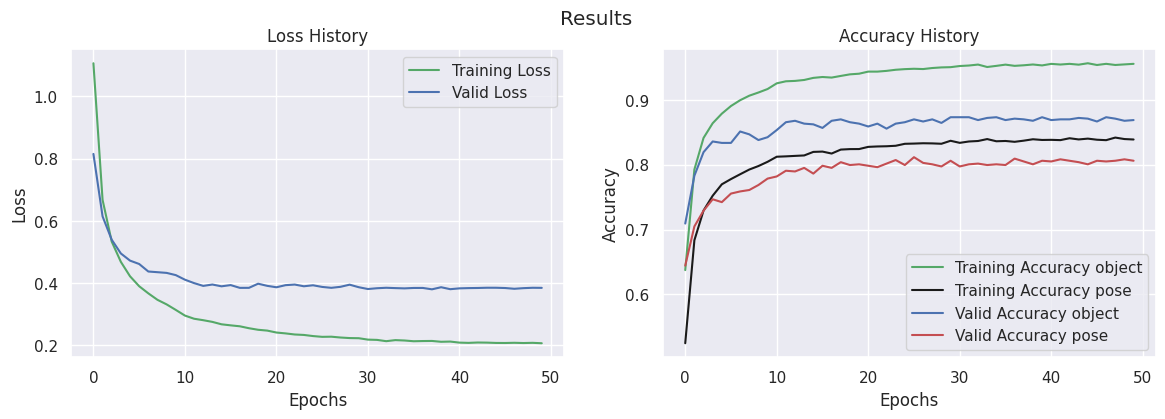

In [16]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
      smoothed_val = w * last + (1 - w) * point
      smoothed.append(smoothed_val)
      ast = smoothed_val
          
    return smoothed

history4 = trainer4.getHistory()
trainer4.showResults()

best model was trained at epoch: 30
with a validation loss of: 0.3864407 and a validation accuracy of: 87.33479976654053


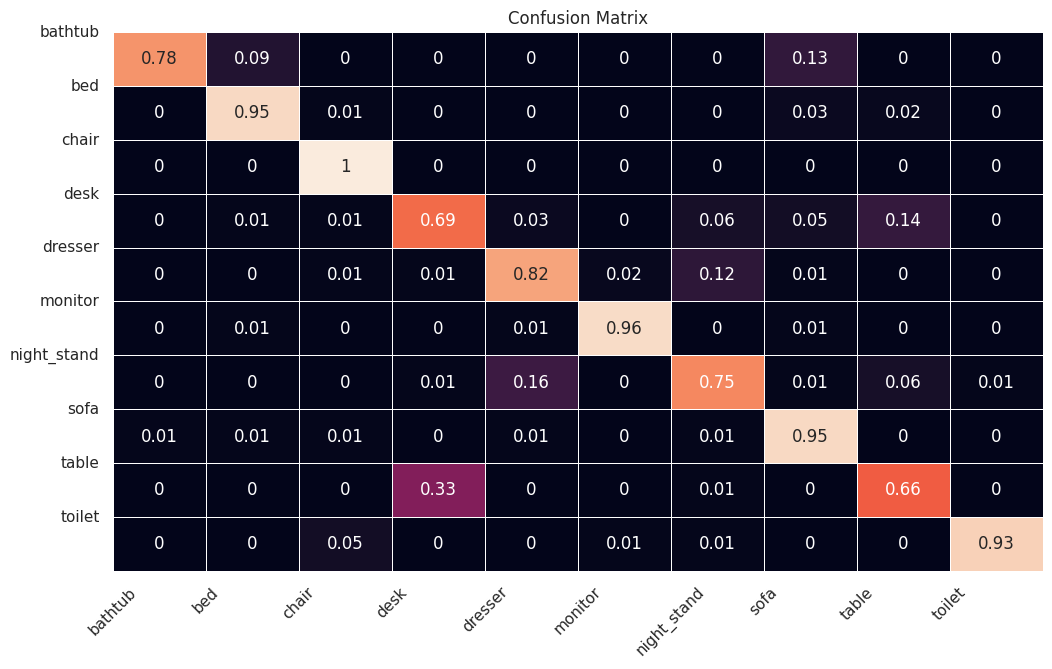

In [17]:
trainer4.generateConfusionMatrix()

best model was trained at epoch: 30
with a validation loss of: 0.3864407 and a validation accuracy of: 87.33479976654053


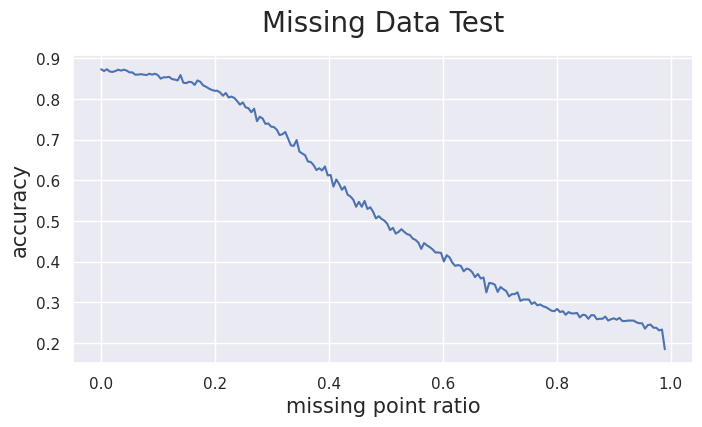

In [18]:
trainer4.missing_data_test()

In [19]:
training_hyperparameters = {
    "learning_rate": 0.001,
    "sgd_momentum": 0.9,
    "data_size": 32,
    "epochs": 50,
    "lr_scheduler_step": 10,
    "lr_scheduler_gamma": 0.5,
    "train_batch_size": 64,
    "valid_batch_size": 32,
    "model" : 'ORION_a'
}    

trainer5 = Network_Trainer_a(training_hyperparameters)
trainer5.train()

model ORION was chosen
499.25


Train loss: 0.9013410806655884: : 499it [02:28,  3.36it/s]
29it [00:03,  9.32it/s]


epoch:  1 / 50
time: 151.72 seconds
train-loss: 1.15, train-acc-object: 62.47%, train-acc-pose: 49.11%
valid-loss: 0.85, valid-acc-object: 71.81%, train-acc-pose: 63.88%



Train loss: 0.4940832257270813: : 499it [02:30,  3.32it/s]
29it [00:02, 11.34it/s]


epoch:  2 / 50
time: 153.02 seconds
train-loss: 0.66, train-acc-object: 80.37%, train-acc-pose: 66.64%
valid-loss: 0.62, valid-acc-object: 79.07%, train-acc-pose: 70.59%



Train loss: 0.607518196105957: : 499it [02:28,  3.37it/s]
29it [00:02, 10.61it/s]


epoch:  3 / 50
time: 150.96 seconds
train-loss: 0.53, train-acc-object: 84.63%, train-acc-pose: 71.98%
valid-loss: 0.55, valid-acc-object: 80.62%, train-acc-pose: 73.57%



Train loss: 0.42503899335861206: : 499it [02:32,  3.27it/s]
29it [00:03,  8.84it/s]


epoch:  4 / 50
time: 156.02 seconds
train-loss: 0.46, train-acc-object: 86.73%, train-acc-pose: 74.57%
valid-loss: 0.51, valid-acc-object: 82.38%, train-acc-pose: 73.90%



Train loss: 0.43930357694625854: : 499it [02:32,  3.26it/s]
29it [00:02, 10.78it/s]


epoch:  5 / 50
time: 155.66 seconds
train-loss: 0.41, train-acc-object: 88.30%, train-acc-pose: 76.33%
valid-loss: 0.48, valid-acc-object: 84.91%, train-acc-pose: 75.22%



Train loss: 0.3513116240501404: : 499it [02:35,  3.20it/s]
29it [00:02,  9.85it/s]


epoch:  6 / 50
time: 158.90 seconds
train-loss: 0.38, train-acc-object: 89.41%, train-acc-pose: 77.72%
valid-loss: 0.46, valid-acc-object: 85.13%, train-acc-pose: 76.76%



Train loss: 0.388679563999176: : 499it [02:35,  3.22it/s]
29it [00:03,  7.50it/s]


epoch:  7 / 50
time: 158.91 seconds
train-loss: 0.35, train-acc-object: 90.32%, train-acc-pose: 78.29%
valid-loss: 0.44, valid-acc-object: 85.24%, train-acc-pose: 77.20%



Train loss: 0.44732850790023804: : 499it [02:31,  3.29it/s]
29it [00:02, 11.37it/s]


epoch:  8 / 50
time: 154.18 seconds
train-loss: 0.33, train-acc-object: 91.01%, train-acc-pose: 79.54%
valid-loss: 0.43, valid-acc-object: 86.01%, train-acc-pose: 77.42%



Train loss: 0.27926045656204224: : 499it [02:31,  3.29it/s]
29it [00:03,  8.53it/s]


epoch:  9 / 50
time: 155.31 seconds
train-loss: 0.31, train-acc-object: 91.59%, train-acc-pose: 79.79%
valid-loss: 0.42, valid-acc-object: 84.58%, train-acc-pose: 78.41%



Train loss: 0.3598758578300476: : 499it [02:28,  3.36it/s]
29it [00:02, 11.41it/s]


epoch: 10 / 50
time: 151.01 seconds
train-loss: 0.30, train-acc-object: 92.08%, train-acc-pose: 80.61%
valid-loss: 0.42, valid-acc-object: 85.79%, train-acc-pose: 78.85%



Train loss: 0.22395341098308563: : 499it [02:28,  3.37it/s]
29it [00:02, 11.40it/s]


epoch: 11 / 50
time: 150.73 seconds
train-loss: 0.27, train-acc-object: 93.14%, train-acc-pose: 81.39%
valid-loss: 0.40, valid-acc-object: 87.11%, train-acc-pose: 79.19%



Train loss: 0.3231777548789978: : 499it [02:28,  3.36it/s]
29it [00:03,  8.50it/s]


epoch: 12 / 50
time: 151.99 seconds
train-loss: 0.26, train-acc-object: 93.41%, train-acc-pose: 81.42%
valid-loss: 0.39, valid-acc-object: 86.67%, train-acc-pose: 79.19%



Train loss: 0.24340388178825378: : 499it [02:27,  3.38it/s]
29it [00:02, 11.17it/s]


epoch: 13 / 50
time: 150.38 seconds
train-loss: 0.26, train-acc-object: 93.67%, train-acc-pose: 82.05%
valid-loss: 0.39, valid-acc-object: 86.67%, train-acc-pose: 80.73%



Train loss: 0.1992570161819458: : 499it [02:26,  3.41it/s]
29it [00:02, 11.61it/s]


epoch: 14 / 50
time: 149.01 seconds
train-loss: 0.25, train-acc-object: 93.98%, train-acc-pose: 82.05%
valid-loss: 0.39, valid-acc-object: 87.78%, train-acc-pose: 79.52%



Train loss: 0.21686285734176636: : 499it [02:27,  3.37it/s]
29it [00:03,  8.71it/s]


epoch: 15 / 50
time: 151.30 seconds
train-loss: 0.24, train-acc-object: 94.30%, train-acc-pose: 82.38%
valid-loss: 0.39, valid-acc-object: 87.00%, train-acc-pose: 79.96%



Train loss: 0.24882307648658752: : 499it [02:26,  3.41it/s]
29it [00:02,  9.75it/s]


epoch: 16 / 50
time: 149.53 seconds
train-loss: 0.24, train-acc-object: 94.21%, train-acc-pose: 82.36%
valid-loss: 0.39, valid-acc-object: 87.56%, train-acc-pose: 80.40%



Train loss: 0.21608108282089233: : 499it [02:27,  3.38it/s]
29it [00:02, 11.57it/s]


epoch: 17 / 50
time: 150.33 seconds
train-loss: 0.24, train-acc-object: 94.39%, train-acc-pose: 82.51%
valid-loss: 0.37, valid-acc-object: 87.33%, train-acc-pose: 81.17%



Train loss: 0.25788983702659607: : 499it [02:29,  3.35it/s]
29it [00:02, 11.53it/s]


epoch: 18 / 50
time: 151.66 seconds
train-loss: 0.23, train-acc-object: 94.51%, train-acc-pose: 82.87%
valid-loss: 0.39, valid-acc-object: 87.78%, train-acc-pose: 81.06%



Train loss: 0.11067183315753937: : 499it [02:27,  3.38it/s]
29it [00:03,  8.27it/s]


epoch: 19 / 50
time: 151.26 seconds
train-loss: 0.23, train-acc-object: 94.58%, train-acc-pose: 83.03%
valid-loss: 0.39, valid-acc-object: 87.89%, train-acc-pose: 81.50%



Train loss: 0.3121565580368042: : 499it [02:28,  3.36it/s]
29it [00:02, 11.31it/s]


epoch: 20 / 50
time: 151.02 seconds
train-loss: 0.22, train-acc-object: 95.03%, train-acc-pose: 83.25%
valid-loss: 0.37, valid-acc-object: 87.89%, train-acc-pose: 81.61%



Train loss: 0.1912871152162552: : 499it [02:27,  3.37it/s]
29it [00:02, 11.39it/s]


epoch: 21 / 50
time: 150.44 seconds
train-loss: 0.21, train-acc-object: 95.25%, train-acc-pose: 83.34%
valid-loss: 0.37, valid-acc-object: 88.00%, train-acc-pose: 80.62%



Train loss: 0.2435624897480011: : 499it [02:29,  3.34it/s]
29it [00:03,  9.60it/s]


epoch: 22 / 50
time: 152.32 seconds
train-loss: 0.21, train-acc-object: 95.28%, train-acc-pose: 83.49%
valid-loss: 0.38, valid-acc-object: 88.44%, train-acc-pose: 81.17%



Train loss: 0.369303822517395: : 499it [02:27,  3.39it/s]
29it [00:02, 11.14it/s]


epoch: 23 / 50
time: 149.79 seconds
train-loss: 0.21, train-acc-object: 95.41%, train-acc-pose: 83.39%
valid-loss: 0.37, valid-acc-object: 88.33%, train-acc-pose: 80.95%



Train loss: 0.20169174671173096: : 499it [02:27,  3.37it/s]
29it [00:02, 11.49it/s]


epoch: 24 / 50
time: 150.45 seconds
train-loss: 0.21, train-acc-object: 95.58%, train-acc-pose: 83.62%
valid-loss: 0.38, valid-acc-object: 87.44%, train-acc-pose: 81.61%



Train loss: 0.22072774171829224: : 499it [02:31,  3.30it/s]
29it [00:03,  9.38it/s]


epoch: 25 / 50
time: 154.14 seconds
train-loss: 0.20, train-acc-object: 95.46%, train-acc-pose: 83.86%
valid-loss: 0.37, valid-acc-object: 88.11%, train-acc-pose: 81.06%



Train loss: 0.32682615518569946: : 499it [02:29,  3.35it/s]
29it [00:02, 11.37it/s]


epoch: 26 / 50
time: 151.67 seconds
train-loss: 0.20, train-acc-object: 95.57%, train-acc-pose: 83.73%
valid-loss: 0.37, valid-acc-object: 88.22%, train-acc-pose: 82.05%



Train loss: 0.14855125546455383: : 499it [02:27,  3.38it/s]
29it [00:02, 11.44it/s]


epoch: 27 / 50
time: 150.10 seconds
train-loss: 0.20, train-acc-object: 95.46%, train-acc-pose: 84.01%
valid-loss: 0.38, valid-acc-object: 88.11%, train-acc-pose: 81.83%



Train loss: 0.2135874181985855: : 499it [02:28,  3.37it/s]
29it [00:02, 11.23it/s]


epoch: 28 / 50
time: 150.77 seconds
train-loss: 0.20, train-acc-object: 95.69%, train-acc-pose: 83.80%
valid-loss: 0.37, valid-acc-object: 88.66%, train-acc-pose: 81.17%



Train loss: 0.18590332567691803: : 499it [02:27,  3.38it/s]
29it [00:03,  7.58it/s]


epoch: 29 / 50
time: 151.26 seconds
train-loss: 0.20, train-acc-object: 95.75%, train-acc-pose: 84.13%
valid-loss: 0.38, valid-acc-object: 87.44%, train-acc-pose: 82.16%



Train loss: 0.1714245229959488: : 499it [02:27,  3.37it/s]
29it [00:02, 11.49it/s]


epoch: 30 / 50
time: 150.43 seconds
train-loss: 0.20, train-acc-object: 95.86%, train-acc-pose: 83.98%
valid-loss: 0.38, valid-acc-object: 87.67%, train-acc-pose: 81.61%



Train loss: 0.195089191198349: : 499it [02:28,  3.37it/s]
29it [00:02, 11.36it/s]


epoch: 31 / 50
time: 150.70 seconds
train-loss: 0.19, train-acc-object: 95.86%, train-acc-pose: 84.09%
valid-loss: 0.37, valid-acc-object: 88.66%, train-acc-pose: 81.50%



Train loss: 0.29724976420402527: : 499it [02:27,  3.39it/s]
29it [00:03,  9.31it/s]


epoch: 32 / 50
time: 150.30 seconds
train-loss: 0.19, train-acc-object: 96.12%, train-acc-pose: 84.17%
valid-loss: 0.37, valid-acc-object: 88.55%, train-acc-pose: 81.61%



Train loss: 0.17225520312786102: : 499it [02:28,  3.36it/s]
29it [00:02, 11.30it/s]


epoch: 33 / 50
time: 151.28 seconds
train-loss: 0.19, train-acc-object: 96.16%, train-acc-pose: 84.47%
valid-loss: 0.37, valid-acc-object: 88.55%, train-acc-pose: 81.39%



Train loss: 0.1333201378583908: : 499it [02:27,  3.38it/s]
29it [00:02, 11.29it/s]


epoch: 34 / 50
time: 150.26 seconds
train-loss: 0.19, train-acc-object: 96.20%, train-acc-pose: 84.43%
valid-loss: 0.37, valid-acc-object: 88.33%, train-acc-pose: 81.39%



Train loss: 0.2265179455280304: : 499it [02:28,  3.37it/s]
29it [00:03,  9.04it/s]


epoch: 35 / 50
time: 151.36 seconds
train-loss: 0.19, train-acc-object: 96.15%, train-acc-pose: 84.09%
valid-loss: 0.37, valid-acc-object: 88.22%, train-acc-pose: 80.95%



Train loss: 0.1801462471485138: : 499it [02:33,  3.26it/s]
29it [00:02, 10.17it/s]


epoch: 36 / 50
time: 156.12 seconds
train-loss: 0.19, train-acc-object: 96.14%, train-acc-pose: 84.26%
valid-loss: 0.37, valid-acc-object: 88.22%, train-acc-pose: 81.17%



Train loss: 0.219944566488266: : 499it [02:31,  3.29it/s]
29it [00:03,  7.59it/s]


epoch: 37 / 50
time: 155.42 seconds
train-loss: 0.19, train-acc-object: 96.30%, train-acc-pose: 84.43%
valid-loss: 0.37, valid-acc-object: 87.89%, train-acc-pose: 81.50%



Train loss: 0.1811978816986084: : 499it [02:27,  3.37it/s]
29it [00:02, 11.39it/s]


epoch: 38 / 50
time: 150.51 seconds
train-loss: 0.19, train-acc-object: 96.09%, train-acc-pose: 84.58%
valid-loss: 0.37, valid-acc-object: 88.44%, train-acc-pose: 81.72%



Train loss: 0.13179026544094086: : 499it [02:28,  3.36it/s]
29it [00:02, 11.29it/s]


epoch: 39 / 50
time: 151.12 seconds
train-loss: 0.19, train-acc-object: 96.14%, train-acc-pose: 84.22%
valid-loss: 0.38, valid-acc-object: 87.89%, train-acc-pose: 82.05%



Train loss: 0.17864087224006653: : 499it [02:28,  3.37it/s]
29it [00:02, 11.28it/s]


epoch: 40 / 50
time: 150.61 seconds
train-loss: 0.19, train-acc-object: 96.20%, train-acc-pose: 84.67%
valid-loss: 0.37, valid-acc-object: 88.33%, train-acc-pose: 81.28%



Train loss: 0.20181190967559814: : 499it [02:30,  3.32it/s]
29it [00:02, 11.17it/s]


epoch: 41 / 50
time: 152.93 seconds
train-loss: 0.18, train-acc-object: 96.27%, train-acc-pose: 84.46%
valid-loss: 0.38, valid-acc-object: 88.22%, train-acc-pose: 81.61%



Train loss: 0.13518306612968445: : 499it [02:28,  3.37it/s]
29it [00:02, 11.20it/s]


epoch: 42 / 50
time: 150.65 seconds
train-loss: 0.18, train-acc-object: 96.44%, train-acc-pose: 84.51%
valid-loss: 0.37, valid-acc-object: 88.66%, train-acc-pose: 81.94%



Train loss: 0.14694640040397644: : 499it [02:28,  3.35it/s]
29it [00:03,  7.51it/s]


epoch: 43 / 50
time: 152.81 seconds
train-loss: 0.18, train-acc-object: 96.43%, train-acc-pose: 84.54%
valid-loss: 0.37, valid-acc-object: 88.44%, train-acc-pose: 81.06%



Train loss: 0.15867570042610168: : 499it [02:28,  3.37it/s]
29it [00:02, 11.21it/s]


epoch: 44 / 50
time: 150.70 seconds
train-loss: 0.18, train-acc-object: 96.52%, train-acc-pose: 84.86%
valid-loss: 0.37, valid-acc-object: 88.66%, train-acc-pose: 81.94%



Train loss: 0.15413439273834229: : 499it [02:28,  3.35it/s]
29it [00:02, 11.31it/s]


epoch: 45 / 50
time: 151.35 seconds
train-loss: 0.18, train-acc-object: 96.36%, train-acc-pose: 84.37%
valid-loss: 0.37, valid-acc-object: 88.33%, train-acc-pose: 81.50%



Train loss: 0.17665790021419525: : 499it [02:31,  3.29it/s]
29it [00:02, 10.58it/s]


epoch: 46 / 50
time: 154.43 seconds
train-loss: 0.18, train-acc-object: 96.51%, train-acc-pose: 84.86%
valid-loss: 0.37, valid-acc-object: 88.77%, train-acc-pose: 81.72%



Train loss: 0.21171660721302032: : 499it [02:32,  3.28it/s]
29it [00:03,  7.67it/s]


epoch: 47 / 50
time: 156.04 seconds
train-loss: 0.18, train-acc-object: 96.38%, train-acc-pose: 84.77%
valid-loss: 0.37, valid-acc-object: 88.66%, train-acc-pose: 81.61%



Train loss: 0.20260724425315857: : 499it [02:33,  3.24it/s]
29it [00:02, 10.05it/s]


epoch: 48 / 50
time: 156.69 seconds
train-loss: 0.18, train-acc-object: 96.47%, train-acc-pose: 84.63%
valid-loss: 0.37, valid-acc-object: 88.33%, train-acc-pose: 81.72%



Train loss: 0.17508971691131592: : 499it [02:39,  3.12it/s]
29it [00:03,  8.86it/s]


epoch: 49 / 50
time: 163.21 seconds
train-loss: 0.18, train-acc-object: 96.41%, train-acc-pose: 84.54%
valid-loss: 0.37, valid-acc-object: 88.66%, train-acc-pose: 81.72%



Train loss: 0.28051748871803284: : 499it [02:38,  3.15it/s]
29it [00:03,  8.76it/s]

epoch: 50 / 50
time: 161.56 seconds
train-loss: 0.18, train-acc-object: 96.54%, train-acc-pose: 84.62%
valid-loss: 0.37, valid-acc-object: 88.77%, train-acc-pose: 81.72%



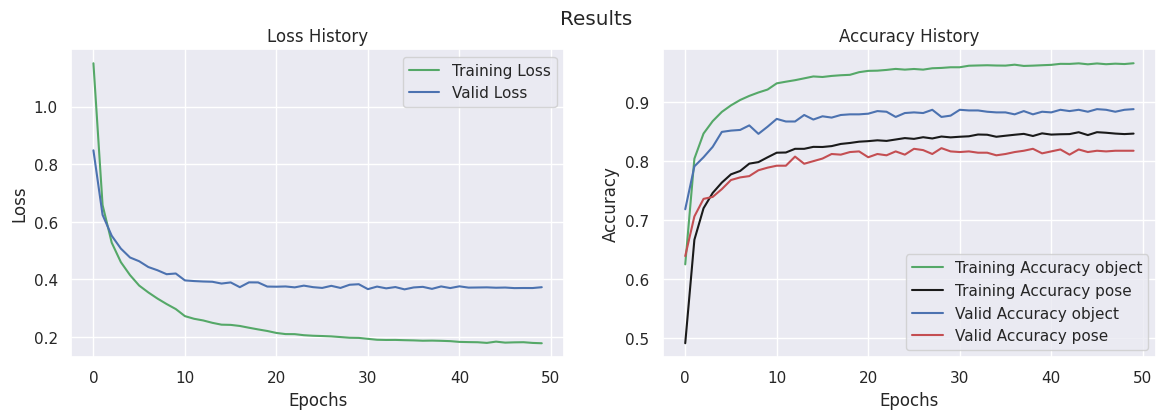

In [20]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
      smoothed_val = w * last + (1 - w) * point
      smoothed.append(smoothed_val)
      ast = smoothed_val
          
    return smoothed

history5 = trainer5.getHistory()
trainer5.showResults()

best model was trained at epoch: 46
with a validation loss of: 0.37158915 and a validation accuracy of: 88.76652121543884


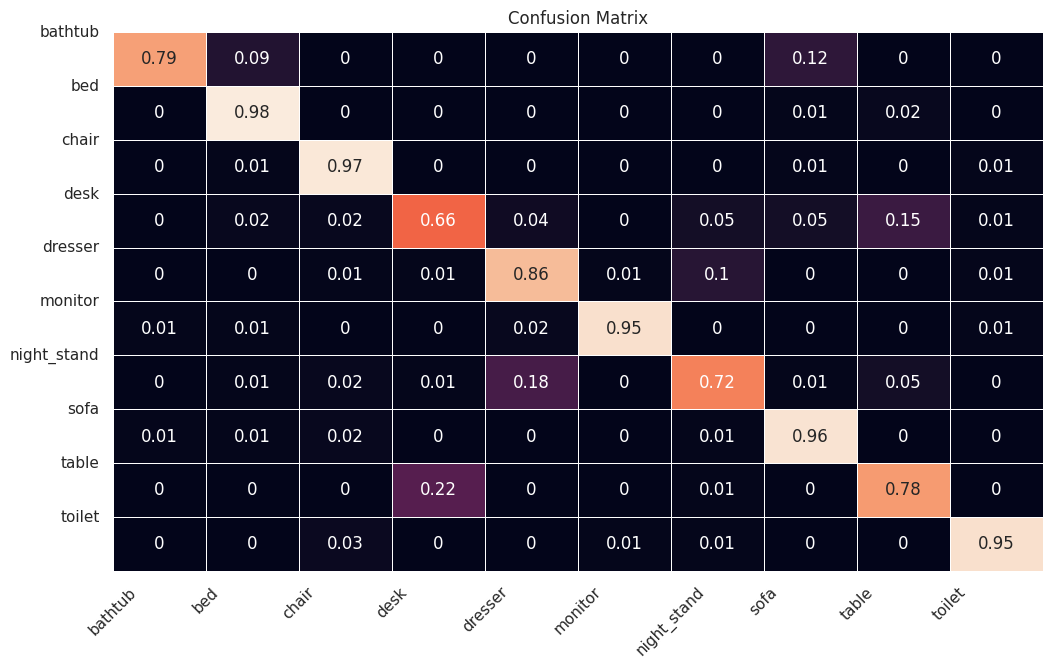

In [21]:
trainer5.generateConfusionMatrix()

best model was trained at epoch: 46
with a validation loss of: 0.37158915 and a validation accuracy of: 88.76652121543884


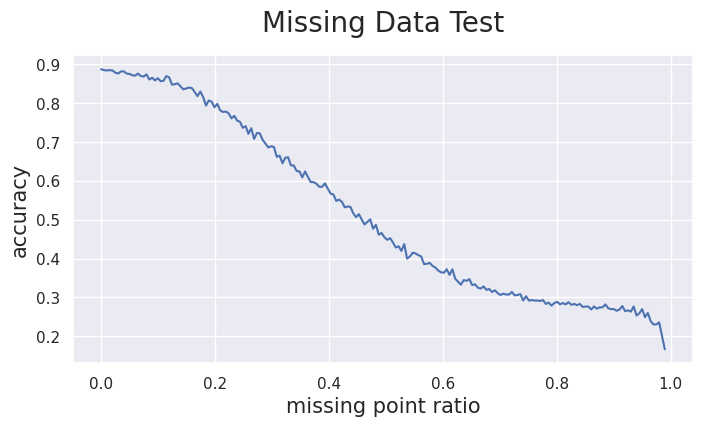

In [22]:
trainer5.missing_data_test()

In [23]:
training_hyperparameters = {
    "learning_rate": 0.001,
    "sgd_momentum": 0.9,
    "data_size": 32,
    "epochs": 50,
    "lr_scheduler_step": 10,
    "lr_scheduler_gamma": 0.5,
    "train_batch_size": 64,
    "valid_batch_size": 32,
    "model" : 'DMPORION_a'
}    

trainer6 = Network_Trainer_a(training_hyperparameters)
trainer6.train()

model DMPORION was choosen
499.25


Train loss: 0.6624617576599121: : 499it [04:07,  2.02it/s]
29it [00:03,  7.97it/s]


epoch:  1 / 50
time: 250.82 seconds
train-loss: 1.12, train-acc-object: 64.05%, train-acc-pose: 50.11%
valid-loss: 1.08, valid-acc-object: 75.44%, train-acc-pose: 63.99%



Train loss: 0.5584198832511902: : 499it [04:14,  1.96it/s]
29it [00:04,  6.76it/s]


epoch:  2 / 50
time: 258.48 seconds
train-loss: 0.60, train-acc-object: 81.48%, train-acc-pose: 70.69%
valid-loss: 0.85, valid-acc-object: 80.29%, train-acc-pose: 70.15%



Train loss: 0.41989049315452576: : 499it [04:10,  1.99it/s]
29it [00:03,  7.86it/s]


epoch:  3 / 50
time: 254.25 seconds
train-loss: 0.46, train-acc-object: 86.19%, train-acc-pose: 75.33%
valid-loss: 0.69, valid-acc-object: 83.92%, train-acc-pose: 72.91%



Train loss: 0.3400001525878906: : 499it [04:12,  1.98it/s]
29it [00:03,  7.98it/s]


epoch:  4 / 50
time: 256.10 seconds
train-loss: 0.39, train-acc-object: 88.92%, train-acc-pose: 76.99%
valid-loss: 0.65, valid-acc-object: 85.68%, train-acc-pose: 73.13%



Train loss: 0.30750030279159546: : 499it [04:15,  1.95it/s]
29it [00:04,  7.24it/s]


epoch:  5 / 50
time: 259.37 seconds
train-loss: 0.36, train-acc-object: 90.10%, train-acc-pose: 78.33%
valid-loss: 0.60, valid-acc-object: 85.90%, train-acc-pose: 75.55%



Train loss: 0.23993392288684845: : 499it [04:08,  2.00it/s]
29it [00:03,  7.83it/s]


epoch:  6 / 50
time: 252.66 seconds
train-loss: 0.32, train-acc-object: 91.24%, train-acc-pose: 79.56%
valid-loss: 0.57, valid-acc-object: 87.00%, train-acc-pose: 76.54%



Train loss: 0.279538631439209: : 499it [04:13,  1.97it/s]
29it [00:03,  7.42it/s]


epoch:  7 / 50
time: 257.28 seconds
train-loss: 0.30, train-acc-object: 91.80%, train-acc-pose: 80.10%
valid-loss: 0.53, valid-acc-object: 88.00%, train-acc-pose: 77.31%



Train loss: 0.24906492233276367: : 499it [04:13,  1.97it/s]
29it [00:04,  6.33it/s]


epoch:  8 / 50
time: 258.38 seconds
train-loss: 0.28, train-acc-object: 92.54%, train-acc-pose: 80.59%
valid-loss: 0.50, valid-acc-object: 83.37%, train-acc-pose: 77.09%



Train loss: 0.23807570338249207: : 499it [04:14,  1.96it/s]
29it [00:05,  5.41it/s]


epoch:  9 / 50
time: 259.60 seconds
train-loss: 0.27, train-acc-object: 93.28%, train-acc-pose: 81.01%
valid-loss: 0.47, valid-acc-object: 88.11%, train-acc-pose: 77.53%



Train loss: 0.18705040216445923: : 499it [04:15,  1.96it/s]
29it [00:05,  5.71it/s]


epoch: 10 / 50
time: 260.27 seconds
train-loss: 0.25, train-acc-object: 93.80%, train-acc-pose: 81.45%
valid-loss: 0.47, valid-acc-object: 89.32%, train-acc-pose: 77.31%



Train loss: 0.16255052387714386: : 499it [04:12,  1.98it/s]
29it [00:03,  7.29it/s]


epoch: 11 / 50
time: 256.12 seconds
train-loss: 0.23, train-acc-object: 94.70%, train-acc-pose: 82.49%
valid-loss: 0.43, valid-acc-object: 88.55%, train-acc-pose: 79.41%



Train loss: 0.21260876953601837: : 499it [04:13,  1.97it/s]
29it [00:03,  7.60it/s]


epoch: 12 / 50
time: 257.76 seconds
train-loss: 0.22, train-acc-object: 95.11%, train-acc-pose: 82.64%
valid-loss: 0.42, valid-acc-object: 89.10%, train-acc-pose: 77.86%



Train loss: 0.2960086166858673: : 499it [04:09,  2.00it/s]
29it [00:04,  6.11it/s]


epoch: 13 / 50
time: 254.14 seconds
train-loss: 0.21, train-acc-object: 95.25%, train-acc-pose: 82.90%
valid-loss: 0.42, valid-acc-object: 88.77%, train-acc-pose: 79.96%



Train loss: 0.18832242488861084: : 499it [04:04,  2.04it/s]
29it [00:03,  8.54it/s]


epoch: 14 / 50
time: 247.57 seconds
train-loss: 0.21, train-acc-object: 95.58%, train-acc-pose: 82.93%
valid-loss: 0.41, valid-acc-object: 88.11%, train-acc-pose: 77.97%



Train loss: 0.14002345502376556: : 499it [04:03,  2.05it/s]
29it [00:03,  8.31it/s]


epoch: 15 / 50
time: 246.85 seconds
train-loss: 0.20, train-acc-object: 95.67%, train-acc-pose: 83.10%
valid-loss: 0.40, valid-acc-object: 88.99%, train-acc-pose: 78.85%



Train loss: 0.14562219381332397: : 499it [04:05,  2.03it/s]
29it [00:03,  8.39it/s]


epoch: 16 / 50
time: 249.44 seconds
train-loss: 0.20, train-acc-object: 95.80%, train-acc-pose: 83.53%
valid-loss: 0.40, valid-acc-object: 89.87%, train-acc-pose: 78.19%



Train loss: 0.1676441878080368: : 499it [04:16,  1.94it/s]
29it [00:03,  7.54it/s]


epoch: 17 / 50
time: 260.85 seconds
train-loss: 0.19, train-acc-object: 95.98%, train-acc-pose: 83.56%
valid-loss: 0.39, valid-acc-object: 88.99%, train-acc-pose: 80.29%



Train loss: 0.17734426259994507: : 499it [04:16,  1.95it/s]
29it [00:03,  7.49it/s]


epoch: 18 / 50
time: 260.11 seconds
train-loss: 0.19, train-acc-object: 96.02%, train-acc-pose: 83.76%
valid-loss: 0.39, valid-acc-object: 89.21%, train-acc-pose: 79.41%



Train loss: 0.16975748538970947: : 499it [04:19,  1.92it/s]
29it [00:03,  7.43it/s]


epoch: 19 / 50
time: 263.83 seconds
train-loss: 0.19, train-acc-object: 96.20%, train-acc-pose: 83.91%
valid-loss: 0.39, valid-acc-object: 89.21%, train-acc-pose: 79.19%



Train loss: 0.1393612176179886: : 499it [04:14,  1.96it/s]
29it [00:03,  7.85it/s]


epoch: 20 / 50
time: 258.63 seconds
train-loss: 0.18, train-acc-object: 96.44%, train-acc-pose: 83.85%
valid-loss: 0.38, valid-acc-object: 90.64%, train-acc-pose: 81.06%



Train loss: 0.20632845163345337: : 499it [04:12,  1.97it/s]
29it [00:04,  5.97it/s]


epoch: 21 / 50
time: 257.62 seconds
train-loss: 0.17, train-acc-object: 96.79%, train-acc-pose: 84.41%
valid-loss: 0.36, valid-acc-object: 90.53%, train-acc-pose: 80.29%



Train loss: 0.2502079904079437: : 499it [04:16,  1.95it/s]
29it [00:05,  5.63it/s]


epoch: 22 / 50
time: 261.43 seconds
train-loss: 0.17, train-acc-object: 97.04%, train-acc-pose: 84.22%
valid-loss: 0.36, valid-acc-object: 89.98%, train-acc-pose: 80.51%



Train loss: 0.15786166489124298: : 499it [04:22,  1.90it/s]
29it [00:04,  7.23it/s]


epoch: 23 / 50
time: 266.21 seconds
train-loss: 0.17, train-acc-object: 96.94%, train-acc-pose: 84.28%
valid-loss: 0.36, valid-acc-object: 90.64%, train-acc-pose: 80.18%



Train loss: 0.1998482197523117: : 499it [04:14,  1.96it/s]
29it [00:05,  5.48it/s]


epoch: 24 / 50
time: 259.60 seconds
train-loss: 0.16, train-acc-object: 97.12%, train-acc-pose: 84.69%
valid-loss: 0.35, valid-acc-object: 90.09%, train-acc-pose: 80.95%



Train loss: 0.13639786839485168: : 499it [04:07,  2.02it/s]
29it [00:03,  8.34it/s]


epoch: 25 / 50
time: 250.56 seconds
train-loss: 0.16, train-acc-object: 97.03%, train-acc-pose: 84.68%
valid-loss: 0.35, valid-acc-object: 89.87%, train-acc-pose: 80.84%



Train loss: 0.14185217022895813: : 499it [04:01,  2.06it/s]
29it [00:03,  8.26it/s]


epoch: 26 / 50
time: 245.22 seconds
train-loss: 0.16, train-acc-object: 97.22%, train-acc-pose: 84.75%
valid-loss: 0.35, valid-acc-object: 90.31%, train-acc-pose: 81.28%



Train loss: 0.12619993090629578: : 499it [04:00,  2.07it/s]
29it [00:03,  8.77it/s]


epoch: 27 / 50
time: 243.83 seconds
train-loss: 0.16, train-acc-object: 97.17%, train-acc-pose: 84.94%
valid-loss: 0.35, valid-acc-object: 89.65%, train-acc-pose: 80.84%



Train loss: 0.17954377830028534: : 499it [04:03,  2.05it/s]
29it [00:04,  6.55it/s]


epoch: 28 / 50
time: 247.57 seconds
train-loss: 0.16, train-acc-object: 97.31%, train-acc-pose: 85.12%
valid-loss: 0.34, valid-acc-object: 90.75%, train-acc-pose: 80.40%



Train loss: 0.09034161269664764: : 499it [03:59,  2.08it/s]
29it [00:03,  8.52it/s]


epoch: 29 / 50
time: 242.91 seconds
train-loss: 0.16, train-acc-object: 97.19%, train-acc-pose: 84.99%
valid-loss: 0.35, valid-acc-object: 89.87%, train-acc-pose: 79.96%



Train loss: 0.15396803617477417: : 499it [03:59,  2.09it/s]
29it [00:03,  8.98it/s]


epoch: 30 / 50
time: 242.50 seconds
train-loss: 0.15, train-acc-object: 97.44%, train-acc-pose: 84.77%
valid-loss: 0.35, valid-acc-object: 90.20%, train-acc-pose: 80.29%



Train loss: 0.15851625800132751: : 499it [03:58,  2.09it/s]
29it [00:03,  8.07it/s]


epoch: 31 / 50
time: 242.09 seconds
train-loss: 0.15, train-acc-object: 97.63%, train-acc-pose: 85.07%
valid-loss: 0.35, valid-acc-object: 89.98%, train-acc-pose: 80.84%



Train loss: 0.1608213484287262: : 499it [03:59,  2.08it/s]
29it [00:03,  7.44it/s]


epoch: 32 / 50
time: 243.59 seconds
train-loss: 0.15, train-acc-object: 97.58%, train-acc-pose: 85.19%
valid-loss: 0.34, valid-acc-object: 90.31%, train-acc-pose: 80.07%



Train loss: 0.1366061568260193: : 499it [03:59,  2.09it/s]
29it [00:03,  8.21it/s]


epoch: 33 / 50
time: 242.73 seconds
train-loss: 0.15, train-acc-object: 97.61%, train-acc-pose: 85.29%
valid-loss: 0.34, valid-acc-object: 89.87%, train-acc-pose: 80.51%



Train loss: 0.08729762583971024: : 499it [03:57,  2.10it/s]
29it [00:03,  9.13it/s]


epoch: 34 / 50
time: 240.88 seconds
train-loss: 0.15, train-acc-object: 97.70%, train-acc-pose: 85.56%
valid-loss: 0.34, valid-acc-object: 89.54%, train-acc-pose: 79.63%



Train loss: 0.09977783262729645: : 499it [04:04,  2.04it/s]
29it [00:03,  8.22it/s]


epoch: 35 / 50
time: 248.34 seconds
train-loss: 0.15, train-acc-object: 97.56%, train-acc-pose: 85.30%
valid-loss: 0.34, valid-acc-object: 90.09%, train-acc-pose: 80.84%



Train loss: 0.14973650872707367: : 499it [04:02,  2.06it/s]
29it [00:03,  8.07it/s]


epoch: 36 / 50
time: 246.27 seconds
train-loss: 0.15, train-acc-object: 97.70%, train-acc-pose: 85.51%
valid-loss: 0.35, valid-acc-object: 90.20%, train-acc-pose: 80.84%



Train loss: 0.11269580572843552: : 499it [04:05,  2.03it/s]
29it [00:03,  8.14it/s]


epoch: 37 / 50
time: 249.50 seconds
train-loss: 0.15, train-acc-object: 97.56%, train-acc-pose: 85.30%
valid-loss: 0.34, valid-acc-object: 90.53%, train-acc-pose: 80.95%



Train loss: 0.10947160422801971: : 499it [04:00,  2.08it/s]
29it [00:03,  9.17it/s]


epoch: 38 / 50
time: 243.23 seconds
train-loss: 0.15, train-acc-object: 97.57%, train-acc-pose: 85.31%
valid-loss: 0.34, valid-acc-object: 90.09%, train-acc-pose: 80.62%



Train loss: 0.22397753596305847: : 499it [04:01,  2.06it/s]
29it [00:03,  7.33it/s]


epoch: 39 / 50
time: 245.87 seconds
train-loss: 0.15, train-acc-object: 97.71%, train-acc-pose: 85.25%
valid-loss: 0.34, valid-acc-object: 90.09%, train-acc-pose: 80.84%



Train loss: 0.13440446555614471: : 499it [04:09,  2.00it/s]
29it [00:03,  7.59it/s]


epoch: 40 / 50
time: 252.88 seconds
train-loss: 0.14, train-acc-object: 97.73%, train-acc-pose: 85.62%
valid-loss: 0.34, valid-acc-object: 90.75%, train-acc-pose: 80.51%



Train loss: 0.13558802008628845: : 499it [03:58,  2.09it/s]
29it [00:03,  8.18it/s]


epoch: 41 / 50
time: 242.42 seconds
train-loss: 0.14, train-acc-object: 97.93%, train-acc-pose: 85.75%
valid-loss: 0.33, valid-acc-object: 90.31%, train-acc-pose: 80.84%



Train loss: 0.11145886033773422: : 499it [03:51,  2.15it/s]
29it [00:03,  8.06it/s]


epoch: 42 / 50
time: 235.45 seconds
train-loss: 0.14, train-acc-object: 97.83%, train-acc-pose: 85.56%
valid-loss: 0.33, valid-acc-object: 90.53%, train-acc-pose: 81.06%



Train loss: 0.0853838175535202: : 499it [03:58,  2.09it/s]
29it [00:04,  7.13it/s]


epoch: 43 / 50
time: 242.69 seconds
train-loss: 0.14, train-acc-object: 97.88%, train-acc-pose: 85.51%
valid-loss: 0.33, valid-acc-object: 90.31%, train-acc-pose: 80.84%



Train loss: 0.11833079159259796: : 499it [04:11,  1.98it/s]
29it [00:03,  8.00it/s]


epoch: 44 / 50
time: 255.42 seconds
train-loss: 0.14, train-acc-object: 97.93%, train-acc-pose: 85.57%
valid-loss: 0.34, valid-acc-object: 89.87%, train-acc-pose: 82.16%



Train loss: 0.20638301968574524: : 499it [04:10,  1.99it/s]
29it [00:04,  6.25it/s]


epoch: 45 / 50
time: 254.86 seconds
train-loss: 0.14, train-acc-object: 97.99%, train-acc-pose: 85.60%
valid-loss: 0.33, valid-acc-object: 89.76%, train-acc-pose: 79.96%



Train loss: 0.09954270720481873: : 499it [04:09,  2.00it/s]
29it [00:03,  7.43it/s]


epoch: 46 / 50
time: 253.45 seconds
train-loss: 0.14, train-acc-object: 97.83%, train-acc-pose: 85.54%
valid-loss: 0.33, valid-acc-object: 89.98%, train-acc-pose: 81.06%



Train loss: 0.14176522195339203: : 499it [04:12,  1.97it/s]
29it [00:03,  7.80it/s]


epoch: 47 / 50
time: 256.63 seconds
train-loss: 0.14, train-acc-object: 97.96%, train-acc-pose: 85.48%
valid-loss: 0.33, valid-acc-object: 90.09%, train-acc-pose: 81.50%



Train loss: 0.13978783786296844: : 499it [04:09,  2.00it/s]
29it [00:05,  5.77it/s]


epoch: 48 / 50
time: 254.84 seconds
train-loss: 0.14, train-acc-object: 97.91%, train-acc-pose: 85.90%
valid-loss: 0.33, valid-acc-object: 90.42%, train-acc-pose: 81.61%



Train loss: 0.12079603970050812: : 499it [04:12,  1.98it/s]
29it [00:04,  5.92it/s]


epoch: 49 / 50
time: 257.39 seconds
train-loss: 0.14, train-acc-object: 97.90%, train-acc-pose: 85.82%
valid-loss: 0.33, valid-acc-object: 90.09%, train-acc-pose: 80.40%



Train loss: 0.14392375946044922: : 499it [04:10,  1.99it/s]
29it [00:03,  8.18it/s]

epoch: 50 / 50
time: 254.42 seconds
train-loss: 0.14, train-acc-object: 97.95%, train-acc-pose: 85.75%
valid-loss: 0.33, valid-acc-object: 90.31%, train-acc-pose: 81.28%



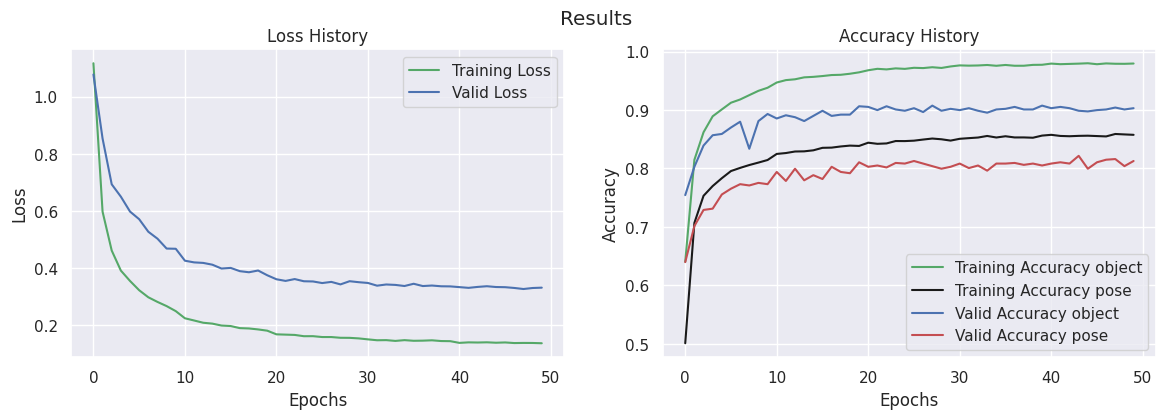

In [24]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
      smoothed_val = w * last + (1 - w) * point
      smoothed.append(smoothed_val)
      ast = smoothed_val
          
    return smoothed

history6 = trainer6.getHistory()
trainer6.showResults()

best model was trained at epoch: 28
with a validation loss of: 0.3434349 and a validation accuracy of: 90.7489001750946


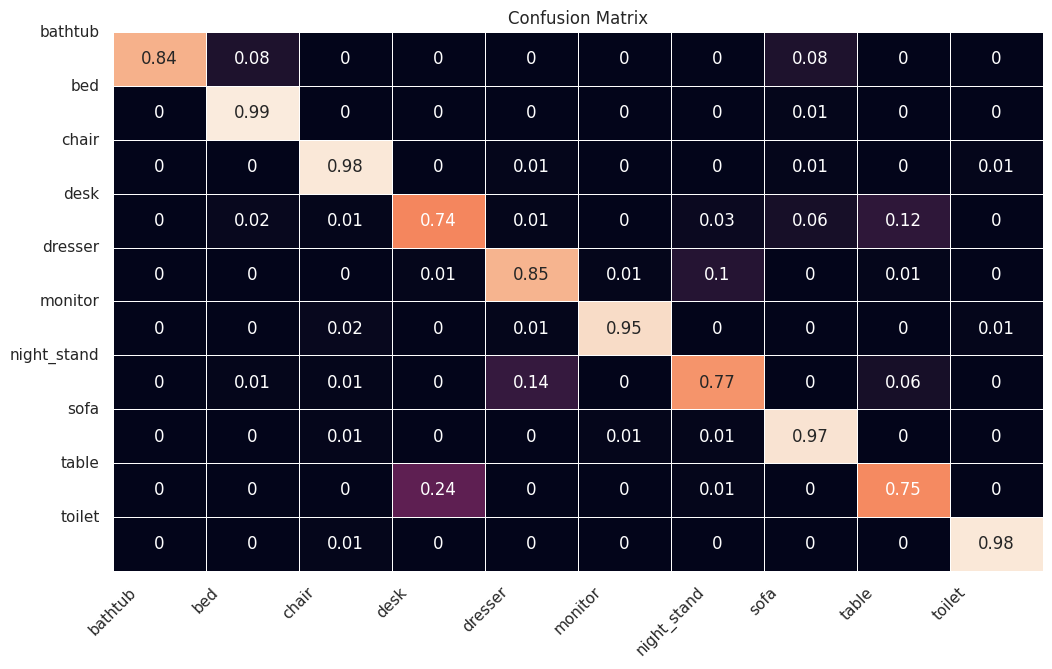

In [25]:
trainer6.generateConfusionMatrix()

best model was trained at epoch: 28
with a validation loss of: 0.3434349 and a validation accuracy of: 90.7489001750946


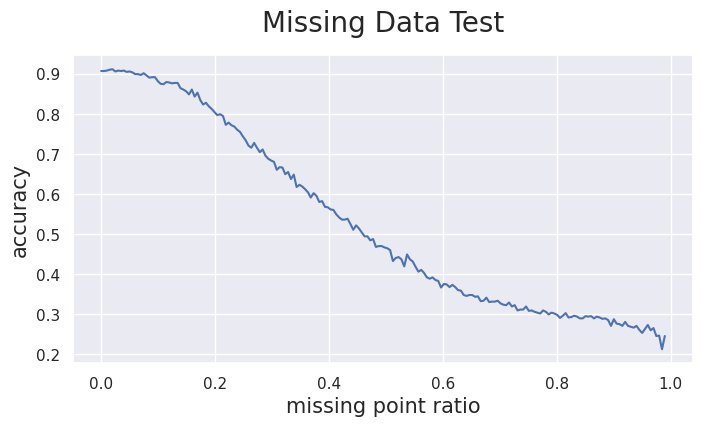

In [26]:
trainer6.missing_data_test()

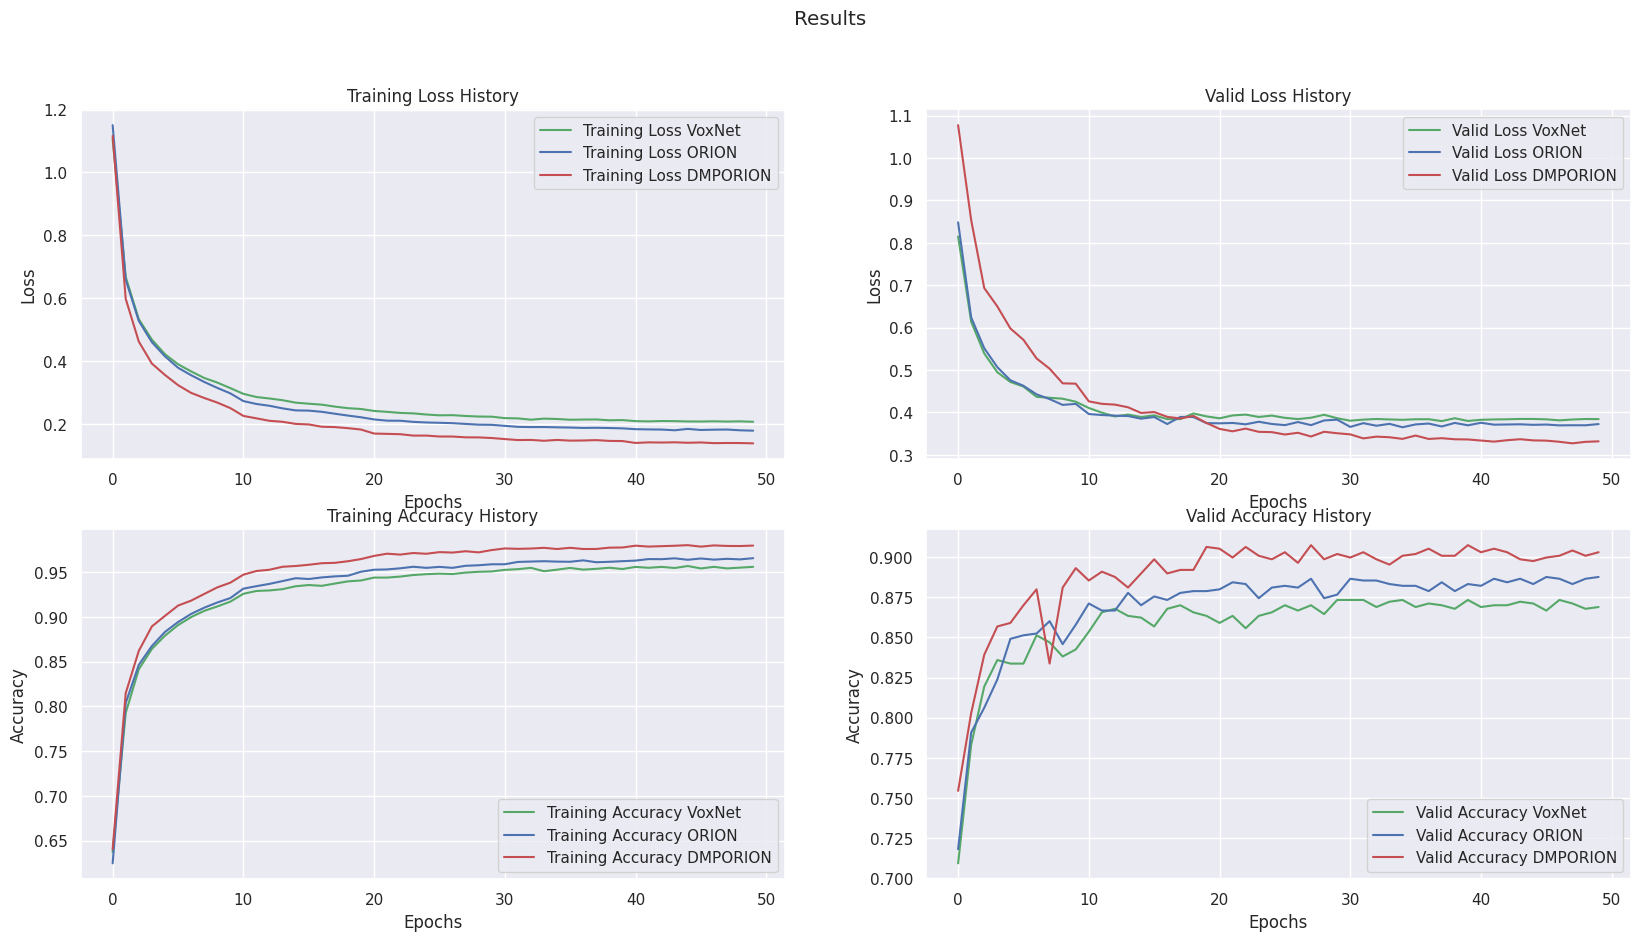

In [27]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
      smoothed_val = w * last + (1 - w) * point
      smoothed.append(smoothed_val)
      ast = smoothed_val
          
    return smoothed

eps = range(0, len(history4["train_loss"].cpu()))
        
sns.set_theme()
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
fig.suptitle('Results')
        
ax[0,0].plot(eps, smooth(history4["train_loss"].cpu()), 'g', label='Training Loss VoxNet')
ax[0,0].plot(eps, smooth(history5["train_loss"].cpu()), 'b', label='Training Loss ORION')
ax[0,0].plot(eps, smooth(history6["train_loss"].cpu()), 'r', label='Training Loss DMPORION')
ax[0,0].set_title('Training Loss History')
ax[0,0].set(xlabel='Epochs', ylabel='Loss')
ax[0,0].legend()
        
ax[0,1].plot(eps, smooth(history4["valid_loss"].cpu()), 'g', label='Valid Loss VoxNet')
ax[0,1].plot(eps, smooth(history5["valid_loss"].cpu()), 'b', label='Valid Loss ORION')
ax[0,1].plot(eps, smooth(history6["valid_loss"].cpu()), 'r', label='Valid Loss DMPORION')
ax[0,1].set_title('Valid Loss History')
ax[0,1].set(xlabel='Epochs', ylabel='Loss')
ax[0,1].legend()

ax[1,0].plot(eps, smooth(history4["train_acc1"].cpu()), 'g', label='Training Accuracy VoxNet')
ax[1,0].plot(eps, smooth(history5["train_acc1"].cpu()), 'b', label='Training Accuracy ORION')
ax[1,0].plot(eps, smooth(history6["train_acc1"].cpu()), 'r', label='Training Accuracy DMPORION')
ax[1,0].set_title('Training Accuracy History')
ax[1,0].set(xlabel='Epochs', ylabel='Accuracy')
ax[1,0].legend()

ax[1,1].plot(eps, smooth(history4["valid_acc1"].cpu()), 'g', label='Valid Accuracy VoxNet')
ax[1,1].plot(eps, smooth(history5["valid_acc1"].cpu()), 'b', label='Valid Accuracy ORION')
ax[1,1].plot(eps, smooth(history6["valid_acc1"].cpu()), 'r', label='Valid Accuracy DMPORION')
ax[1,1].set_title('Valid Accuracy History')
ax[1,1].set(xlabel='Epochs', ylabel='Accuracy')
ax[1,1].legend()

# PointNet

In [ ]:
import os
import random
import math

!pip install path.py;
from path import Path

path = Path("ModelNet10")

folders = [dir for dir in sorted(os.listdir(path)) if os.path.isdir(path/dir)]
classes = {folder: i for i, folder in enumerate(folders)};

def read_off(file):
    if 'OFF' != file.readline().strip():
        raise('Not a valid OFF header')
    n_verts, n_faces, __ = tuple([int(s) for s in file.readline().strip().split(' ')])
    verts = [[float(s) for s in file.readline().strip().split(' ')] for i_vert in range(n_verts)]
    faces = [[int(s) for s in file.readline().strip().split(' ')][1:] for i_face in range(n_faces)]
    return verts, faces

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
class PointSampler(object):
    def __init__(self, output_size):
        assert isinstance(output_size, int)
        self.output_size = output_size
    
    def triangle_area(self, pt1, pt2, pt3):
        side_a = np.linalg.norm(pt1 - pt2)
        side_b = np.linalg.norm(pt2 - pt3)
        side_c = np.linalg.norm(pt3 - pt1)
        s = 0.5 * ( side_a + side_b + side_c)
        return max(s * (s - side_a) * (s - side_b) * (s - side_c), 0)**0.5

    def sample_point(self, pt1, pt2, pt3):
        # barycentric coordinates on a triangle
        # https://mathworld.wolfram.com/BarycentricCoordinates.html
        s, t = sorted([random.random(), random.random()])
        f = lambda i: s * pt1[i] + (t-s)*pt2[i] + (1-t)*pt3[i]
        return (f(0), f(1), f(2))
        
    
    def __call__(self, mesh):
        verts, faces = mesh
        verts = np.array(verts)
        areas = np.zeros((len(faces)))

        for i in range(len(areas)):
            areas[i] = (self.triangle_area(verts[faces[i][0]], verts[faces[i][1]], verts[faces[i][2]]))
            
        sampled_faces = (random.choices(faces, weights=areas, cum_weights=None, k=self.output_size))
        
        sampled_points = np.zeros((self.output_size, 3))

        for i in range(len(sampled_faces)):
            sampled_points[i] = (self.sample_point(verts[sampled_faces[i][0]], verts[sampled_faces[i][1]], verts[sampled_faces[i][2]]))
        
        return sampled_points


class Normalize(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2
        
        norm_pointcloud = pointcloud - np.mean(pointcloud, axis=0) 
        norm_pointcloud /= np.max(np.linalg.norm(norm_pointcloud, axis=1))

        return  norm_pointcloud

class RandRotation_z(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        theta = random.random() * 2. * math.pi
        rot_matrix = np.array([[ math.cos(theta), -math.sin(theta),    0],
                               [ math.sin(theta),  math.cos(theta),    0],
                               [0,                             0,      1]])
        
        rot_pointcloud = rot_matrix.dot(pointcloud.T).T
        return  rot_pointcloud
    
class RandomNoise(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        noise = np.random.normal(0, 0.02, (pointcloud.shape))
    
        noisy_pointcloud = pointcloud + noise
        return  noisy_pointcloud

class ToTensor(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        return torch.from_numpy(pointcloud)

In [ ]:
def default_transforms():
    return transforms.Compose([PointSampler(1024),
                                Normalize(),
                                ToTensor()
                              ])

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
class PointCloudData(Dataset):
    def __init__(self, root_dir, valid=False, folder="train", transform=default_transforms()):
        self.root_dir = root_dir
        folders = [dir for dir in sorted(os.listdir(root_dir)) if os.path.isdir(root_dir/dir)]
        self.classes = {folder: i for i, folder in enumerate(folders)}
        self.transforms = transform if not valid else default_transforms()
        self.valid = valid
        self.files = []
        for category in self.classes.keys():
            new_dir = root_dir/Path(category)/folder
            for file in os.listdir(new_dir):
                if file.endswith('.off'):
                    sample = {}
                    sample['pcd_path'] = new_dir/file
                    sample['category'] = category
                    self.files.append(sample)

    def __len__(self):
        return len(self.files)

    def __preproc__(self, file):
        verts, faces = read_off(file)
        if self.transforms:
            pointcloud = self.transforms((verts, faces))
        return pointcloud

    def __getitem__(self, idx):
        pcd_path = self.files[idx]['pcd_path']
        category = self.files[idx]['category']
        with open(pcd_path, 'r') as f:
            pointcloud = self.__preproc__(f)
        return {'pointcloud': pointcloud, 'category': self.classes[category]}

In [ ]:
train_transforms = transforms.Compose([
                    PointSampler(1024),
                    Normalize(),
                    RandRotation_z(),
                    RandomNoise(),
                    ToTensor()
                    ])

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

class Tnet(nn.Module):
   def __init__(self, k=3):
      super().__init__()
      self.k=k
      self.conv1 = nn.Conv1d(k,64,1)
      self.conv2 = nn.Conv1d(64,128,1)
      self.conv3 = nn.Conv1d(128,1024,1)
      self.fc1 = nn.Linear(1024,512)
      self.fc2 = nn.Linear(512,256)
      self.fc3 = nn.Linear(256,k*k)

      self.bn1 = nn.BatchNorm1d(64)
      self.bn2 = nn.BatchNorm1d(128)
      self.bn3 = nn.BatchNorm1d(1024)
      self.bn4 = nn.BatchNorm1d(512)
      self.bn5 = nn.BatchNorm1d(256)
       

   def forward(self, input):
      # input.shape == (bs,n,3)
      bs = input.size(0)
      xb = F.relu(self.bn1(self.conv1(input)))
      xb = F.relu(self.bn2(self.conv2(xb)))
      xb = F.relu(self.bn3(self.conv3(xb)))
      pool = nn.MaxPool1d(xb.size(-1))(xb)
      flat = nn.Flatten(1)(pool)
      xb = F.relu(self.bn4(self.fc1(flat)))
      xb = F.relu(self.bn5(self.fc2(xb)))
      
      #initialize as identity
      init = torch.eye(self.k, requires_grad=True).repeat(bs,1,1)
      if xb.is_cuda:
        init=init.cuda()
      matrix = self.fc3(xb).view(-1,self.k,self.k) + init
      return matrix


class Transform(nn.Module):
   def __init__(self):
        super().__init__()
        self.input_transform = Tnet(k=3)
        self.feature_transform = Tnet(k=64)
        self.conv1 = nn.Conv1d(3,64,1)

        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)
       

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
       
   def forward(self, input):
        matrix3x3 = self.input_transform(input)
        # batch matrix multiplication
        xb = torch.bmm(torch.transpose(input,1,2), matrix3x3).transpose(1,2)

        xb = F.relu(self.bn1(self.conv1(xb)))

        matrix64x64 = self.feature_transform(xb)
        xb = torch.bmm(torch.transpose(xb,1,2), matrix64x64).transpose(1,2)

        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = self.bn3(self.conv3(xb))
        xb = nn.MaxPool1d(xb.size(-1))(xb)
        output = nn.Flatten(1)(xb)
        return output, matrix3x3, matrix64x64

class PointNet(nn.Module):
    def __init__(self, classes = 10):
        super().__init__()
        self.transform = Transform()
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, classes)
        

        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(p=0.3)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        xb, matrix3x3, matrix64x64 = self.transform(input)
        xb = F.relu(self.bn1(self.fc1(xb)))
        xb = F.relu(self.bn2(self.dropout(self.fc2(xb))))
        output = self.fc3(xb)
        return self.logsoftmax(output), matrix3x3, matrix64x64

In [ ]:
def pointnetloss(outputs, labels, m3x3, m64x64, alpha = 0.0001):
    criterion = torch.nn.NLLLoss()
    bs=outputs.size(0)
    id3x3 = torch.eye(3, requires_grad=True).repeat(bs,1,1)
    id64x64 = torch.eye(64, requires_grad=True).repeat(bs,1,1)
    if outputs.is_cuda:
        id3x3=id3x3.cuda()
        id64x64=id64x64.cuda()
    diff3x3 = id3x3-torch.bmm(m3x3,m3x3.transpose(1,2))
    diff64x64 = id64x64-torch.bmm(m64x64,m64x64.transpose(1,2))
    return criterion(outputs, labels) + alpha * (torch.norm(diff3x3)+torch.norm(diff64x64)) / float(bs)

In [ ]:
class PointNet_Trainer():
  def __init__(self, hyperparameters):
      #Hypreparameters
      self.learning_rate = hyperparameters["learning_rate"]
      self.batch_size_train = hyperparameters["train_batch_size"]
      self.batch_size_test = hyperparameters["valid_batch_size"]
      self.data_size = hyperparameters["data_size"]
      self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
      self.epochs = hyperparameters["epochs"]
      
      #Dataset
      self.initDataset()
      self.class_names = ["bathtub", "bed", "chair", "desk", "dresser", "monitor", "night_stand", "sofa", "table", "toilet"]
      self.num_classes = len(self.class_names)

      #Model
      self.initModel(hyperparameters)
  
  def initDataset(self):
      self.train_ds = PointCloudData(path, transform=train_transforms)
      self.test_ds = PointCloudData(path, valid=True, folder='test', transform=train_transforms)
      self.train_dataloader = DataLoader(dataset=self.train_ds, batch_size=self.batch_size_train, shuffle=True, drop_last=True)
      self.test_dataloader = DataLoader(dataset=self.test_ds, batch_size=self.batch_size_test)

  def initModel(self, hyperparameters):
      self.model = PointNet()
      print("model PointNet was chosen")
      self.device = "cuda" if torch.cuda.is_available() else "cpu"
      self.model.to(self.device)
      self.opt = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)

  def train(self):
      self.pred_conf, self.y_conf = [], []                                                           
      train_loss_history, valid_loss_history = [], []
      train_acc_history, valid_acc_history = [], []
      train_accuracy = Accuracy(task='multiclass', num_classes=10)
      valid_accuracy = Accuracy(task='multiclass', num_classes=10)

      self.num_batch = len(self.train_ds) / self.batch_size_train
      print(self.num_batch)

      total_time = time.time()

      for epoch in range(self.epochs):
          t = time.time()

          train_loss = []                                                         #track training loss
          valid_loss = []
          self.model.train()
          iterator = tqdm(enumerate(self.train_dataloader, 0))
          for i, data in iterator:
              inputs, labels = data['pointcloud'].to(self.device).float(), data['category'].to(self.device)

              self.opt.zero_grad()
              outputs, m3x3, m64x64 = self.model(inputs.transpose(1,2))  # torch.Size([256, 10])
              loss = pointnetloss(outputs, labels, m3x3, m64x64)
              train_loss.append(loss.cpu().data)
              train_accuracy.update(torch.argmax(outputs, 1).cpu(), labels.cpu()) 

              loss.backward()
              self.opt.step()
              iterator.set_description(f"Train loss: {loss.cpu().data}")
                      
          with torch.no_grad():
            self.model.eval()
            for j, sample in tqdm(enumerate(self.test_dataloader, 0)):    
                inputs_test, labels_test = sample['pointcloud'].to(self.device).float(), sample['category'].to(self.device)
                
                outputs_test, m3x3, m64x64  = self.model(inputs_test.transpose(1,2))
                loss_test = pointnetloss(outputs_test, labels_test, m3x3, m64x64)
                valid_loss.append(loss_test.cpu().data)
                valid_accuracy.update(torch.argmax(outputs_test, 1).cpu(), labels_test.cpu())
                pred_choice_test = outputs_test.data.max(1)[1]

                correct_test = pred_choice_test.eq(labels_test.data).cpu().sum()
                self.pred_conf.append(torch.argmax(outputs_test, 1))
                self.y_conf.append(labels_test)

          #compute confusion matrix
          a = torch.cat(self.pred_conf).cpu()
          b = torch.cat(self.y_conf).cpu()
          confmat = ConfusionMatrix(task='multiclass', num_classes=10, normalize="true")
          self.conf_matrix = confmat(a, b)
          self.conf_matrix = torch.round(self.conf_matrix, decimals=2)

          # total accuracy over all batches
          total_train_accuracy = train_accuracy.compute()
          total_valid_accuracy = valid_accuracy.compute()
          train_accuracy.reset()
          valid_accuracy.reset()
            
          #track loss and acc for plotting
          train_loss_history.append(torch.mean(torch.tensor(train_loss)))
          valid_loss_history.append(torch.mean(torch.tensor(valid_loss)))
          train_acc_history.append(total_train_accuracy)
          valid_acc_history.append(total_valid_accuracy)
            
          elapsed_time_epoch = time.time() - t   
            
          tmp0 = "epoch:{:3d} /{:3d}".format(epoch+1, self.epochs)
          tmp1 = "time: {:.2f} seconds".format(elapsed_time_epoch)
          tmp2 = "train-loss: {:4.2f}, train-acc: {:.2%}".format(train_loss_history[epoch], train_acc_history[epoch].item())
          tmp3 = "valid-loss: {:4.2f}, valid-acc: {:.2%}\n".format(valid_loss_history[epoch], valid_acc_history[epoch].item())
          print(tmp0, tmp1, tmp2, tmp3, sep="\n")
          
          #save history
          self.history = {"train_loss": torch.tensor(train_loss_history), "train_acc": torch.tensor(train_acc_history), 
                          "valid_loss": torch.tensor(valid_loss_history), "valid_acc": torch.tensor(valid_acc_history)}
           
  def getHistory(self):
      return self.history

  def generateConfusionMatrix(self):
      fig=plt.figure(figsize = (12,7))
      sns.heatmap(self.conf_matrix, annot=True, fmt='g', linewidths=.4, cbar=False)
      tick_marks = np.arange(len(self.class_names))
      plt.xticks(tick_marks, self.class_names, rotation=45)
      plt.yticks(tick_marks, self.class_names, rotation=0)
      plt.title("Confusion Matrix")     

  def getPerClassAccuracy(self):
      per_class_accuracy = 100 * torch.diag(self.conf_matrix) / torch.sum(self.conf_matrix, 1)
      tmp = {}
      for i, x in enumerate(self.class_names):
        tmp[x] = per_class_accuracy[i].item()
      print(tmp)
    
  def showResults(self):
      eps = range(0, len(self.history["train_loss"].cpu()))
        
      sns.set_theme()
      fig, ax = plt.subplots(1, 2, figsize=(14, 4))
      fig.suptitle('Results')
        
      ax[0].plot(eps, smooth(self.history["train_loss"].cpu()), 'g', label='Training Loss')
      ax[0].plot(eps, smooth(self.history["valid_loss"].cpu()), 'b', label='Valid Loss')
      ax[0].set_title('Loss History')
      ax[0].set(xlabel='Epochs', ylabel='Loss')
      ax[0].legend()
        
      ax[1].plot(eps, smooth(self.history["train_acc"].cpu()), 'g', label='Training Accuracy')
      ax[1].plot(eps, smooth(self.history["valid_acc"].cpu()), 'b', label='Valid Accuracy')
      ax[1].set_title('Loss History')
      ax[1].set(xlabel='Epochs', ylabel='Accuracy')
      ax[1].legend()
        
  def test_on_missing_data(self, missing_rate=0.5):
      test_accuracy = Accuracy(task='multiclass', num_classes=10)
        
      self.model.eval()
      for x, y in self.test_dataloader:
          x, y = x.to(self.device), y.to(self.device)
            
          idc = np.random.choice(32**3, size=(int(32**3*missing_rate)), replace=False)
          idc_x = idc%32
          idc_y = np.floor_divide(idc, 32)%32
          idc_z = np.floor_divide(idc, 32*32)%32
          x[:, :, idc_x, idc_y, idc_z] = 0
            
          pred = self.model(x)
          test_accuracy.update(torch.argmax(pred, 1).cpu(), y.cpu())
            
      return test_accuracy.compute()
    
  def missing_data_test(self):
      acc = []
      delta = 200
      eps = np.linspace(0,0.99,delta)
      for x in eps:
          tmp = self.test_on_missing_data(x)
          acc.append(tmp)
            
            
      sns.set_theme()
      plt.figure(figsize=(8, 4))
      plt.plot(eps, smooth(acc))
      plt.title("Missing Data Test", size=20, y=1.05)
      plt.xlabel("missing point ratio", size=15)
      plt.ylabel("accuracy", size=15)
      plt.show()

In [ ]:
training_hyperparameters = {
    "learning_rate": 0.001,
    "data_size": 32,
    "epochs": 20,
    "train_batch_size": 32,
    "valid_batch_size": 64,
}    

trainer7 = PointNet_Trainer(training_hyperparameters)
trainer7.train()

NameError: ignored

# Download and unzip the dataset ModelNet40



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q "/content/drive/MyDrive/ModelNet40.zip";

In [ ]:
!wget http://modelnet.cs.princeton.edu/ModelNet40.zip

--2023-05-19 08:16:39--  http://modelnet.cs.princeton.edu/ModelNet40.zip
Resolving modelnet.cs.princeton.edu (modelnet.cs.princeton.edu)... 128.112.136.74
Connecting to modelnet.cs.princeton.edu (modelnet.cs.princeton.edu)|128.112.136.74|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://modelnet.cs.princeton.edu/ModelNet40.zip [following]
--2023-05-19 08:16:40--  https://modelnet.cs.princeton.edu/ModelNet40.zip
Connecting to modelnet.cs.princeton.edu (modelnet.cs.princeton.edu)|128.112.136.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2039180837 (1.9G) [application/zip]
Saving to: ‘ModelNet40.zip’

ModelNet40.zip      100%[===================>]   1.90G  56.9MB/s    in 53s     

2023-05-19 08:17:32 (37.0 MB/s) - ‘ModelNet40.zip’ saved [2039180837/2039180837]



In [ ]:
!unzip -q ModelNet40.zip;

In [ ]:
ROOT = '/content/ModelNet40/'
CLASSES = ['airplane', 'bathtub', 'bed', 'bench', 'bookshelf', 'bottle', 'bowl', 'car', 'chair', 'cone',
           'cup', 'curtain', 'desk', 'door', 'dresser', 'flower_pot', 'glass_box', 'guitar', 'keyboard', 'lamp',
           'laptop', 'mantel', 'monitor', 'night_stand', 'person', 'piano', 'plant', 'radio', 'range_hood', 'sink',
           'sofa', 'stairs', 'stool', 'table', 'tent', 'toilet', 'tv_stand', 'vase', 'wardrobe', 'xbox']

ROTATIONS = ['0', '45', '90', '135', '180', '225', '270', '315']

#rotations matrix
r45 = np.array([[math.sqrt(2)/2,-math.sqrt(2)/2,0], [math.sqrt(2)/2,math.sqrt(2)/2,0], [0,0,1]], np.float64)
r90 = np.array([[0,-1,0], [1,0,0], [0,0,1]], np.float64)
r135 = np.array([[-math.sqrt(2)/2,-math.sqrt(2)/2,0], [math.sqrt(2)/2,-math.sqrt(2)/2,0], [0,0,1]], np.float64)
r180 = np.array([[-1,0,0], [0,-1,0], [0,0,1]], np.float64)
r225 = np.array([[-math.sqrt(2)/2,math.sqrt(2)/2,0], [-math.sqrt(2)/2,-math.sqrt(2)/2,0], [0,0,1]], np.float64)
r270 = np.array([[0,1,0], [-1,0,0], [0,0,1]], np.float64)
r315 = np.array([[math.sqrt(2)/2,math.sqrt(2)/2,0], [-math.sqrt(2)/2,math.sqrt(2)/2,0], [0,0,1]], np.float64)

X = {'train': [], 'test': []}
Y = {'train': [], 'test': []}
Z = {'train': [], 'test': []}

for label, cl in enumerate(CLASSES):
    for split in ['train', 'test']:
        examples_dir = os.path.join(ROOT, cl, split)
        for example in tqdm(os.listdir(examples_dir)):
          voxel_index = []
          rot = random.choice(ROTATIONS)
          if 'off' in example:
            mesh = o3d.io.read_triangle_mesh(examples_dir+'/'+example)
            if rot == '0':
              mesh = mesh
              rotat = 0
            elif rot == '45':
              mesh.rotate(r45)
              rotat = 1
            elif rot == '90':
              mesh.rotate(r90)
              rotat = 2
            elif rot == '135':
              mesh.rotate(r135) 
              rotat = 3 
            elif rot == '180':
              mesh.rotate(r180)
              rotat = 4
            elif rot == '225':
              mesh.rotate(r225)
              rotat = 5
            elif rot == '270':
              mesh.rotate(r270)
              rotat = 6
            else:
              mesh.rotate(r315)
              rotat = 7
            mesh.scale(1 / np.max(mesh.get_max_bound() - mesh.get_min_bound()), center=mesh.get_center())
            voxel_grid = o3d.geometry.VoxelGrid.create_from_triangle_mesh(mesh, voxel_size=0.05)
            
            X[split].append(voxel_grid)
            Y[split].append(label)
            Z[split].append(rotat)


 46%|████▌     | 238/515 [00:09<00:07, 38.16it/s]<ipython-input-5-c756dd08d0a1>:54: RuntimeWarning: divide by zero encountered in double_scalars
  mesh.scale(1 / np.max(mesh.get_max_bound() - mesh.get_min_bound()), center=mesh.get_center())
 48%|████▊     | 247/515 [00:09<00:05, 47.10it/s]

[Open3D WARNING] Read OFF failed: header keyword 'OFF1479 1440 0' not supported.


 66%|██████▋   | 342/515 [00:13<00:04, 35.35it/s]

[Open3D WARNING] Read OFF failed: header keyword 'OFF1806 1388 0' not supported.


 73%|███████▎  | 377/515 [00:13<00:02, 61.63it/s]

[Open3D WARNING] Read OFF failed: header keyword 'OFF3161 2820 0' not supported.


 88%|████████▊ | 454/515 [00:16<00:02, 25.93it/s]

[Open3D WARNING] Read OFF failed: header keyword 'OFF4780 6240 0' not supported.


 96%|█████████▌| 492/515 [00:17<00:00, 33.77it/s]

[Open3D WARNING] Read OFF failed: header keyword 'OFF18524 23092 0' not supported.


 39%|███▉      | 346/889 [00:14<00:15, 36.15it/s]

[Open3D WARNING] Read OFF failed: header keyword 'OFF4890 7376 0' not supported.


 42%|████▏     | 372/889 [00:15<00:14, 36.61it/s]

[Open3D WARNING] Read OFF failed: header keyword 'OFF18515 26870 0' not supported.


 46%|████▌     | 409/889 [00:16<00:10, 44.11it/s]

[Open3D WARNING] Read OFF failed: header keyword 'OFF2938 4636 0' not supported.


 83%|████████▎ | 734/889 [00:29<00:04, 31.06it/s]

[Open3D WARNING] Read OFF failed: header keyword 'OFF6586 5534 0' not supported.


100%|██████████| 86/86 [00:02<00:00, 41.91it/s]

[Open3D WARNING] Read OFF failed: header keyword 'OFF1' not supported.



100%|██████████| 20/20 [00:00<00:00, 30.02it/s]


#VoxNet with Modelnet40

In [ ]:
class Network_Dataset40(Dataset):
    def __init__(self, train = True):
      if train:
          self.data = X['train']
          self.label1 = Y['train']
          self.label2 = Z['train']
      else:
          self.data = X['test']
          self.label1 = Y['test']
          self.label2 = Z['test']
        
                
    def __len__(self):
        return len(self.label1)

    def __preproc__(self, voxels):
        
        voxel_grid = voxels.get_voxels()
        vox_g = np.zeros((32, 32, 32), dtype=np.int32)
        for i in range (len(voxel_grid)):
          voxel_index = voxel_grid[i].grid_index
          vox_g[voxel_index[0],voxel_index[1],voxel_index[2]] = 1
        
        return vox_g.copy()

    def __getitem__(self, idx):
        label1 = self.label1[idx]
        label2 = self.label2[idx]
        voxels = self.data[idx]
        voxels = self.__preproc__(voxels)
        voxels = np.expand_dims(voxels, axis=0)
        voxels = torch.tensor(voxels).float()
        return voxels, label1, label2

In [ ]:
class Network_Trainer40():
  def __init__(self, hyperparameters):
      #Hypreparameters
      self.learning_rate = hyperparameters["learning_rate"]
      self.batch_size_train = hyperparameters["train_batch_size"]
      self.batch_size_test = hyperparameters["valid_batch_size"]
      self.data_size = hyperparameters["data_size"]
      self.sgd_momentum = hyperparameters["sgd_momentum"]
      self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
      self.epochs = hyperparameters["epochs"]
      self.name_model = hyperparameters["model"]
      self.best_acc = 0
      self.alpha = 2/3
      
      #Dataset
      self.initDataset()
      self.class_names = ['airplane', 'bathtub', 'bed', 'bench', 'bookshelf', 'bottle', 'bowl', 'car', 'chair', 'cone',
                          'cup', 'curtain', 'desk', 'door', 'dresser', 'flower_pot', 'glass_box', 'guitar', 'keyboard', 'lamp',
                          'laptop', 'mantel', 'monitor', 'night_stand', 'person', 'piano', 'plant', 'radio', 'range_hood', 'sink',
                          'sofa', 'stairs', 'stool', 'table', 'tent', 'toilet', 'tv_stand', 'vase', 'wardrobe', 'xbox']

      self.rotation_names = ['0', '45', '90', '135', '180', '225', '270', '315']
      self.num_classes = len(self.class_names)
      self.num_rotations = len(self.rotation_names)

      #Model
      self.lr_scheduler_step = hyperparameters["lr_scheduler_step"]
      self.lr_scheduler_gamma = hyperparameters["lr_scheduler_gamma"]
      self.initModel()
  
  def initDataset(self):
      self.train_ds = Network_Dataset40(train=True)
      self.test_ds = Network_Dataset40(train=False)
      self.train_dataloader = DataLoader(dataset=self.train_ds, batch_size=self.batch_size_train, shuffle=True, drop_last=True)
      self.test_dataloader = DataLoader(dataset=self.test_ds, batch_size=self.batch_size_test)

  def initModel(self):
      if self.name_model == "VoxNet40":
          self.model = VoxNet40()
          os.mkdir('/content/'+str(self.name_model))
          print("model VoxNet40 was chosen")
      elif self.name_model == "ORION40":
          self.model = ORION40()
          os.mkdir('/content/'+str(self.name_model))
          print("model ORION40 was chosen")
      else:
        self.model = DMPORION40()
        os.mkdir('/content/'+str(self.name_model))
        print('model DMPORION40 was choosen')
      
      self.device = "cuda" if torch.cuda.is_available() else "cpu"
      self.model.to(self.device)
      
      self.opt = SGD(self.model.parameters(), lr=self.learning_rate, momentum=self.sgd_momentum)
      self.loss_fn = nn.CrossEntropyLoss()
      self.lr_scheduler = torch.optim.lr_scheduler.StepLR(self.opt, step_size=self.lr_scheduler_step, gamma=self.lr_scheduler_gamma)
     
  def train(self):
      self.pred_conf, self.y_conf = [], []                                                           
      train_loss_history, valid_loss_history = [], []
      train_acc_history1, valid_acc_history1 = [], []
      train_acc_history2, valid_acc_history2 = [], []
      train_accuracy1 = Accuracy(task='multiclass', num_classes=self.num_classes)
      valid_accuracy1 = Accuracy(task='multiclass', num_classes=self.num_classes)
      train_accuracy2 = Accuracy(task='multiclass', num_classes=self.num_rotations)
      valid_accuracy2 = Accuracy(task='multiclass', num_classes=self.num_rotations)

      self.num_batch = len(self.train_ds) / self.batch_size_train
      print(self.num_batch)

      total_time = time.time()

      for epoch in range(self.epochs):
          t = time.time()

          #track training and validation loss
          train_loss = []                                                        
          valid_loss = []

          #training phase
          self.model.train()
          iterator = tqdm(enumerate(self.train_dataloader, 0))
          for i, data in iterator:
              inputs, labels1, labels2 = data[0], data[1], data[2]
              inputs = inputs.to(self.device)
              labels1 = labels1.to(self.device)
              labels2 = labels2.to(self.device)

              self.opt.zero_grad()
              pred1, pred2 = self.model(inputs)  # torch.Size([256, 10])
              loss = self.alpha*self.loss_fn(pred1, labels1) + (1-self.alpha)*self.loss_fn(pred2, labels2)
              train_loss.append(loss.cpu().data)
              train_accuracy1.update(torch.argmax(pred1, 1).cpu(), labels1.cpu()) 
              train_accuracy2.update(torch.argmax(pred2, 1).cpu(), labels2.cpu()) 
            
              loss.backward()
              self.opt.step()
              iterator.set_description(f"Train loss: {loss.cpu().data}")
              
          self.lr_scheduler.step()

          #test phase             
          with torch.no_grad():
            self.model.eval()
            pred_test1 = []       
            pred_test2 = []  
            for j, sample in tqdm(enumerate(self.test_dataloader, 0)):    
                inputs_test, labels_test1, labels_test2 = sample[0], sample[1], sample[2]
                inputs_test = inputs_test.to(self.device)
                labels_test1 = labels_test1.to(self.device)
                labels_test2 = labels_test2.to(self.device)
                inputs_test = inputs_test.float()  
               
                pred_test1, pred_test2 = self.model(inputs_test)  
                loss_test = self.alpha*self.loss_fn(pred_test1, labels_test1) + (1-self.alpha)*self.loss_fn(pred_test2, labels_test2)
                valid_loss.append(loss_test.cpu().data)
                valid_accuracy1.update(torch.argmax(pred_test1, 1).cpu(), labels_test1.cpu()) 
                valid_accuracy2.update(torch.argmax(pred_test2, 1).cpu(), labels_test2.cpu()) 
                
                self.pred_conf.append(torch.argmax(pred_test1, 1))
                self.y_conf.append(labels_test1)
      

          #total accuracy over all batches
          total_train_accuracy1 = train_accuracy1.compute()
          total_train_accuracy2 = train_accuracy2.compute()
          total_valid_accuracy1 = valid_accuracy1.compute()
          total_valid_accuracy2 = valid_accuracy2.compute()
          train_accuracy1.reset()
          valid_accuracy1.reset()
          train_accuracy2.reset()
          valid_accuracy2.reset()
            
          #track loss and acc for plotting
          train_loss_history.append(torch.mean(torch.tensor(train_loss)))
          valid_loss_history.append(torch.mean(torch.tensor(valid_loss)))
          train_acc_history1.append(total_train_accuracy1)
          train_acc_history2.append(total_train_accuracy2)
          valid_acc_history1.append(total_valid_accuracy1)
          valid_acc_history2.append(total_valid_accuracy2)
          
            
          elapsed_time_epoch = time.time() - t   
            
          tmp0 = "epoch:{:3d} /{:3d}".format(epoch+1, self.epochs)
          tmp1 = "time: {:.2f} seconds".format(elapsed_time_epoch)
          tmp2 = "train-loss: {:4.2f}, train-acc-object: {:.2%}, train-acc-pose: {:.2%}".format(train_loss_history[epoch], train_acc_history1[epoch].item(), train_acc_history2[epoch].item())
          tmp3 = "valid-loss: {:4.2f}, valid-acc-object: {:.2%}, train-acc-pose: {:.2%}\n".format(valid_loss_history[epoch], valid_acc_history1[epoch].item(), valid_acc_history2[epoch].item())
          print(tmp0, tmp1, tmp2, tmp3, sep="\n")


          #save best model 
          if total_valid_accuracy1.numpy()>self.best_acc:
              self.best_acc = total_valid_accuracy1.numpy()
              torch.save({'epoch': epoch+1,
                          'model_state_dict': self.model.state_dict(),
                          'optimizer_state_dict': self.opt.state_dict(),
                          'loss': valid_loss_history[-1], 
                          'accuracy': total_valid_accuracy1},
	                        '/content/'+str(self.name_model)+'/best_model.pth')

          
          #save history
          self.history = {"train_loss": torch.tensor(train_loss_history), "train_acc1": torch.tensor(train_acc_history1), "train_acc2": torch.tensor(train_acc_history2), 
                          "valid_loss": torch.tensor(valid_loss_history), "valid_acc1": torch.tensor(valid_acc_history1), "valid_acc2": torch.tensor(valid_acc_history2)}
           
  def getHistory(self):
      return self.history

  def generateConfusionMatrix(self):
      #load the model
      checkpoint = torch.load('/content/'+str(self.name_model)+'/best_model.pth')
      self.model.load_state_dict(checkpoint['model_state_dict'])
      self.opt.load_state_dict(checkpoint['optimizer_state_dict'])
      loss = checkpoint['loss']
      epoch = checkpoint['epoch']
      acc = checkpoint['accuracy']
      print('best model was trained at epoch: '+str(epoch))
      print('with a validation loss of: '+str(loss.numpy())+' and a validation accuracy of: '+str(acc.numpy()*100))
  
      #compute confusion matrix
      self.model.eval()
      a = torch.cat(self.pred_conf).cpu()
      b = torch.cat(self.y_conf).cpu()
      confmat = ConfusionMatrix(task='multiclass', num_classes=self.num_classes, normalize="true")
      self.conf_matrix = confmat(a, b)
      self.conf_matrix = torch.round(self.conf_matrix, decimals=2)

      fig=plt.figure(figsize = (20,14))
      sns.heatmap(self.conf_matrix, annot=True, fmt='g', linewidths=.4, cbar=False)
      tick_marks = np.arange(len(self.class_names))
      plt.xticks(tick_marks, self.class_names, rotation=45)
      plt.yticks(tick_marks, self.class_names, rotation=0)
      plt.title("Confusion Matrix")     

  def getPerClassAccuracy(self):
      per_class_accuracy = 100 * torch.diag(self.conf_matrix) / torch.sum(self.conf_matrix, 1)
      tmp = {}
      for i, x in enumerate(self.class_names):
        tmp[x] = per_class_accuracy[i].item()
      print(tmp)
    
  def showResults(self):
      eps = range(0, len(self.history["train_loss"].cpu()))
        
      sns.set_theme()
      fig, ax = plt.subplots(1, 2, figsize=(14, 4))
      fig.suptitle('Results')
        
      ax[0].plot(eps, smooth(self.history["train_loss"].cpu()), 'g', label='Training Loss')
      ax[0].plot(eps, smooth(self.history["valid_loss"].cpu()), 'b', label='Valid Loss')
      ax[0].set_title('Loss History')
      ax[0].set(xlabel='Epochs', ylabel='Loss')
      ax[0].legend()
        
      ax[1].plot(eps, smooth(self.history["train_acc1"].cpu()), 'g', label='Training Accuracy object')
      ax[1].plot(eps, smooth(self.history["train_acc2"].cpu()), 'k', label='Training Accuracy pose')
      ax[1].plot(eps, smooth(self.history["valid_acc1"].cpu()), 'b', label='Valid Accuracy object')
      ax[1].plot(eps, smooth(self.history["valid_acc2"].cpu()), 'r', label='Valid Accuracy pose')
      ax[1].set_title('Accuracy History')
      ax[1].set(xlabel='Epochs', ylabel='Accuracy')
      ax[1].legend()

  def draw_voxels(self):
      mesh = next(iter(self.train_dataloader))
      mesh = mesh[0][0][0]
        
      ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
      ax.voxels(mesh, edgecolor='k')
      plt.show()
        
  def test_on_missing_data(self, missing_rate=0.5):
      test_accuracy = Accuracy(task='multiclass', num_classes=40)

      ##load the model
      checkpoint = torch.load('/content/'+str(self.name_model)+'/best_model.pth')
      self.model.load_state_dict(checkpoint['model_state_dict'])
      self.opt.load_state_dict(checkpoint['optimizer_state_dict'])
      loss = checkpoint['loss']
      epoch = checkpoint['epoch']
      acc = checkpoint['accuracy']
  
      self.model.eval()
      for x, y, z in self.test_dataloader:
          x, y, z = x.to(self.device), y.to(self.device), z.to(self.device)
            
          idc = np.random.choice(32**3, size=(int(32**3*missing_rate)), replace=False)
          idc_x = idc%32
          idc_y = np.floor_divide(idc, 32)%32
          idc_z = np.floor_divide(idc, 32*32)%32
          x[:, :, idc_x, idc_y, idc_z] = 0
            
          pred = self.model(x)[0]
          test_accuracy.update(torch.argmax(pred, 1).cpu(), y.cpu())
            
      return test_accuracy.compute()
    
  def missing_data_test(self):
      acc = []
      delta = 200
      eps = np.linspace(0,0.99,delta)

      #load the model
      checkpoint = torch.load('/content/'+str(self.name_model)+'/best_model.pth')
      self.model.load_state_dict(checkpoint['model_state_dict'])
      self.opt.load_state_dict(checkpoint['optimizer_state_dict'])
      loss = checkpoint['loss']
      epoch = checkpoint['epoch']
      accu = checkpoint['accuracy']
      print('best model was trained at epoch: '+str(epoch))
      print('with a validation loss of: '+str(loss.numpy())+' and a validation accuracy of: '+str(accu.numpy()*100))

      for x in eps:
          tmp = self.test_on_missing_data(x)
          acc.append(tmp)
            
            
      sns.set_theme()
      plt.figure(figsize=(8, 4))
      plt.plot(eps, smooth(acc))
      plt.title("Missing Data Test", size=20, y=1.05)
      plt.xlabel("missing point ratio", size=15)
      plt.ylabel("accuracy", size=15)
      plt.show()

In [ ]:
class VoxNet40(nn.Module):
    def __init__(self):
        super(VoxNet40, self).__init__()
        n_classes = 40
        n_rotations = 8
        input_shape = (32,32,32)
        self.feat = torch.nn.Sequential(OrderedDict([
            ('conv3d_1', torch.nn.Conv3d(in_channels=1, out_channels=32, kernel_size=5, stride=2)),
            ('batch1', torch.nn.BatchNorm3d(32)),
            ('relu1', torch.nn.ReLU()),
            ('drop1', torch.nn.Dropout(p=0.2)),
            ('conv3d_2', torch.nn.Conv3d(in_channels=32, out_channels=32, kernel_size=3, stride=1)),
            ('batch1', torch.nn.BatchNorm3d(32)),
            ('relu2', torch.nn.ReLU()),
            ('pool1', torch.nn.MaxPool3d(kernel_size=2, stride=2)),
            ('drop2', torch.nn.Dropout(p=0.3))
        ]))
        
        x = self.feat(torch.autograd.Variable(torch.rand((1, 1) + input_shape)))
        dim_feat = 1
        for n in x.size()[1:]:
            dim_feat *= n

        self.mlp = torch.nn.Sequential(OrderedDict([
            ('fc1', torch.nn.Linear(dim_feat, 128)),
            ('relu1', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.4)),
            ('fc2', torch.nn.Linear(128, n_classes))
        ]))

        self.mlp2 = torch.nn.Sequential(OrderedDict([
            ('fc1', torch.nn.Linear(dim_feat, 128)),
            ('relu1', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.4)),
            ('fc2', torch.nn.Linear(128, n_rotations))
        ]))

        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.feat(x)
        x = x.view(x.size(0), -1)
        x1 = self.mlp(x)
        x2 = self.mlp2(x)
        return self.logsoftmax(x1), self.logsoftmax(x2)

In [ ]:
training_hyperparameters = {
    "learning_rate": 0.001,
    "sgd_momentum": 0.9,
    "data_size": 32,
    "epochs": 50,
    "lr_scheduler_step": 40,
    "lr_scheduler_gamma": 0.5,
    "train_batch_size": 64,
    "valid_batch_size": 32,
    "model" : 'VoxNet40'
}    

trainer8 = Network_Trainer40(training_hyperparameters)
trainer8.train()

model VoxNet40 was chosen
143.75


0it [00:00, ?it/s]


RuntimeError: ignored

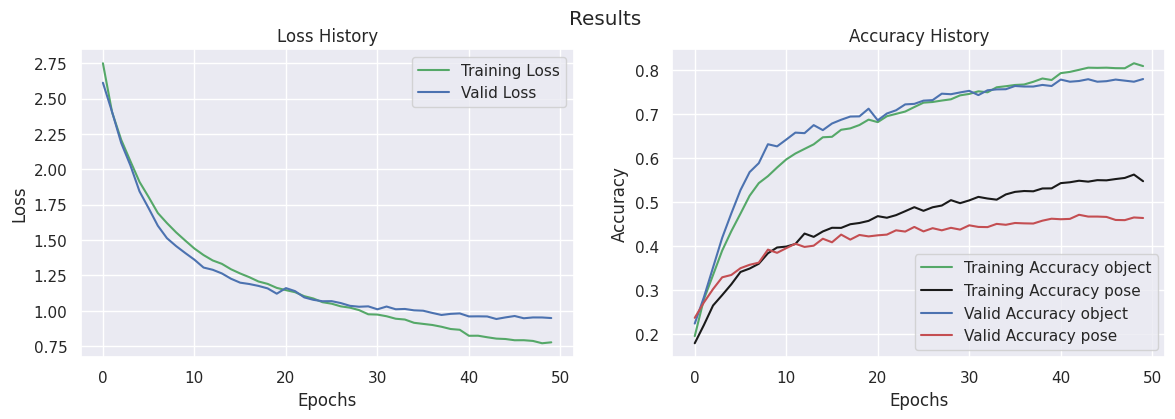

In [ ]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
      smoothed_val = w * last + (1 - w) * point
      smoothed.append(smoothed_val)
      ast = smoothed_val
          
    return smoothed

history8 = trainer8.getHistory()
trainer8.showResults()

best model was trained at epoch: 50
with a validation loss of: 0.9490501 and a validation accuracy of: 77.91311144828796


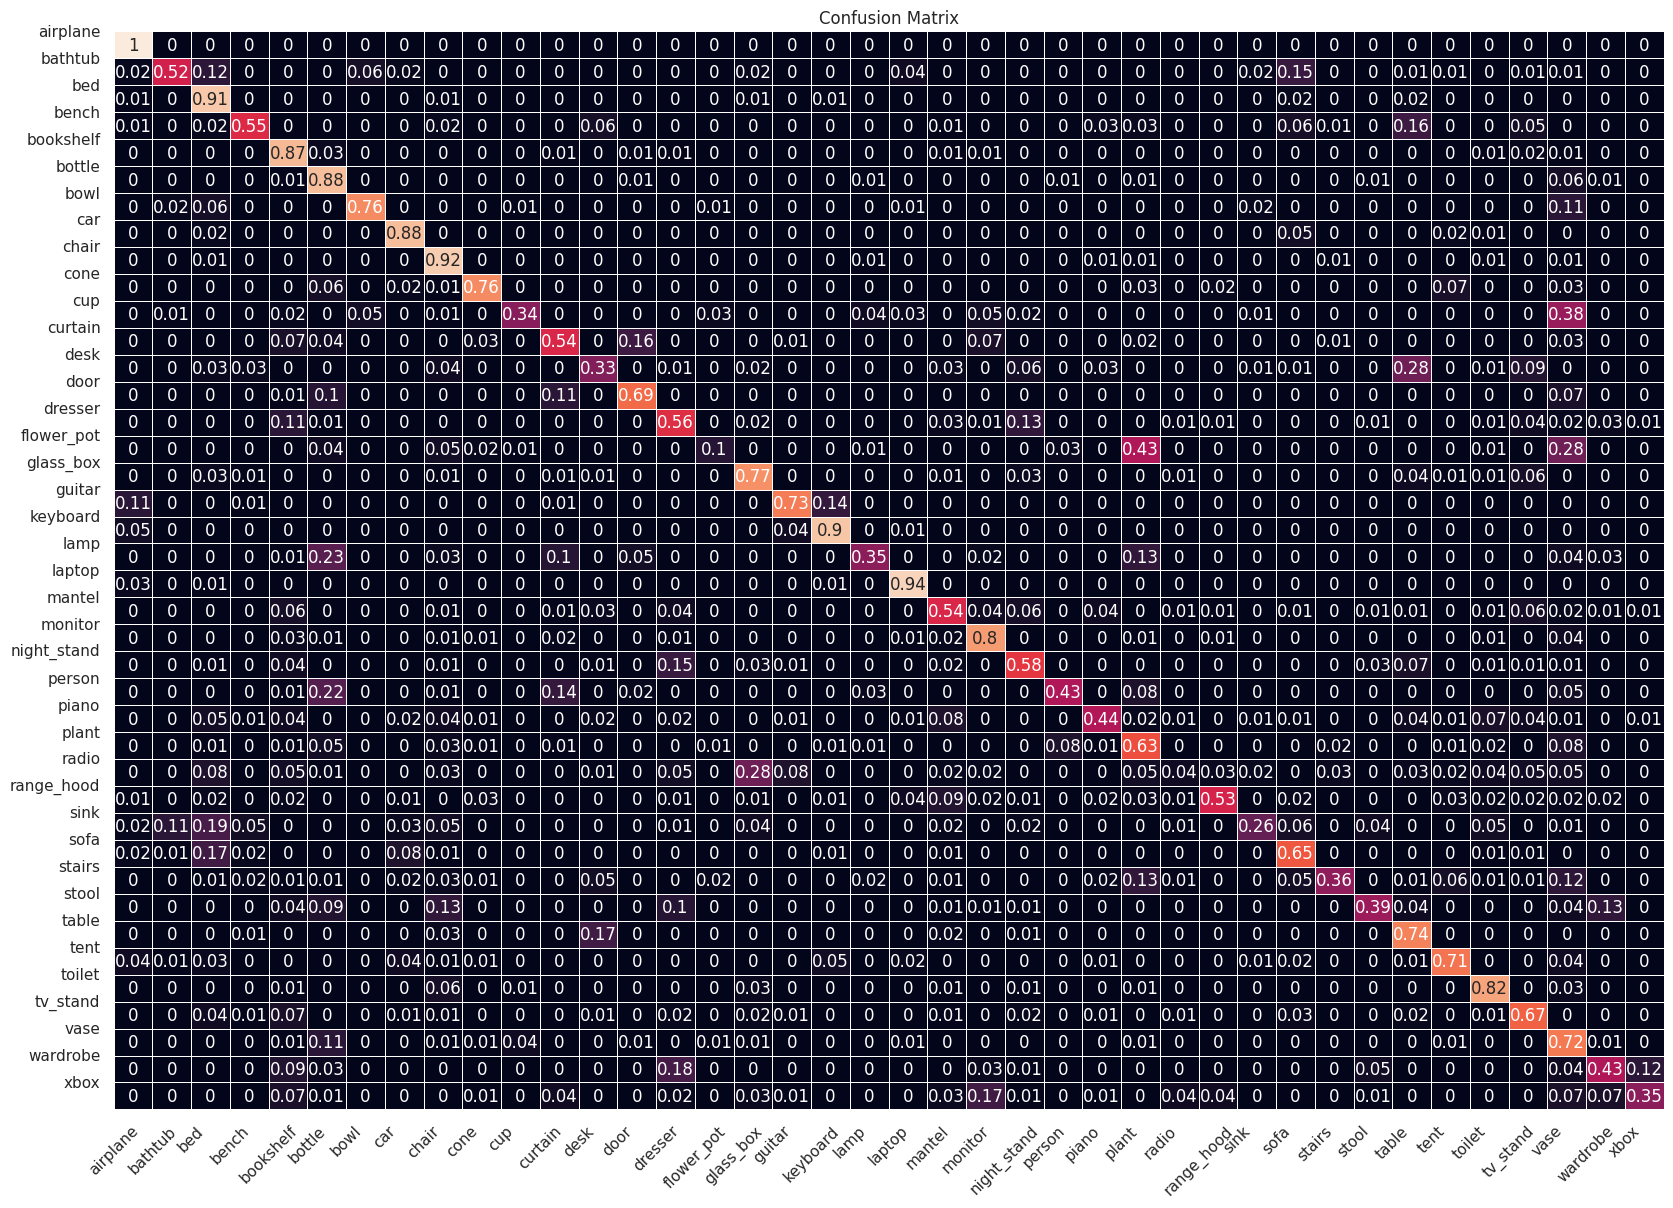

In [ ]:
trainer8.generateConfusionMatrix()

In [ ]:
class ORION40(nn.Module):
    def __init__(self):
        super(ORION40, self).__init__()
        n_classes = 40
        n_rotations = 8
        input_shape = (32,32,32)
        self.feat = torch.nn.Sequential(OrderedDict([
            ('conv3d_1', torch.nn.Conv3d(in_channels=1, out_channels=32, kernel_size=3, stride=2)),
            ('batch1', torch.nn.BatchNorm3d(32)),
            ('relu1', torch.nn.ReLU()),
            ('drop1', torch.nn.Dropout(p=0.2)),
            ('conv3d_2', torch.nn.Conv3d(in_channels=32, out_channels=64, kernel_size=3, stride=1)),
            ('batch2', torch.nn.BatchNorm3d(64)),
            ('relu2', torch.nn.ReLU()),
            ('drop2', torch.nn.Dropout(p=0.3)),
            ('conv3d_3', torch.nn.Conv3d(in_channels=64, out_channels=128, kernel_size=3, stride=1)),
            ('batch3', torch.nn.BatchNorm3d(128)),
            ('relu3', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.3)),
            ('conv3d_4', torch.nn.Conv3d(in_channels=128, out_channels=256, kernel_size=3, stride=1)),
            ('relu4', torch.nn.ReLU()),
            ('pool1', torch.nn.MaxPool3d(kernel_size=2, stride=2)),
            ('drop4', torch.nn.Dropout(p=0.3))            
        ]))
        
        x = self.feat(torch.autograd.Variable(torch.rand((1, 1) + input_shape)))
        dim_feat = 1
        for n in x.size()[1:]:
            dim_feat *= n

        self.mlp = torch.nn.Sequential(OrderedDict([
            ('fc1', torch.nn.Linear(dim_feat, 128)),
            ('relu1', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.4)),
            ('fc2', torch.nn.Linear(128, n_classes))
        ]))

        self.mlp2 = torch.nn.Sequential(OrderedDict([
            ('fc1', torch.nn.Linear(dim_feat, 128)),
            ('relu1', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.4)),
            ('fc2', torch.nn.Linear(128, n_rotations))
        ]))

        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.feat(x)
        x = x.view(x.size(0), -1)
        x1 = self.mlp(x)
        x2 = self.mlp2(x)
        return self.logsoftmax(x1), self.logsoftmax(x2)

In [ ]:
training_hyperparameters = {
    "learning_rate": 0.001,
    "sgd_momentum": 0.9,
    "data_size": 32,
    "epochs": 50,
    "lr_scheduler_step": 40,
    "lr_scheduler_gamma": 0.5,
    "train_batch_size": 64,
    "valid_batch_size": 32,
    "model" : 'ORION40'
}    

trainer9 = Network_Trainer40(training_hyperparameters)
trainer9.train()

model ORION40 was chosen
143.75


0it [00:00, ?it/s]


RuntimeError: ignored

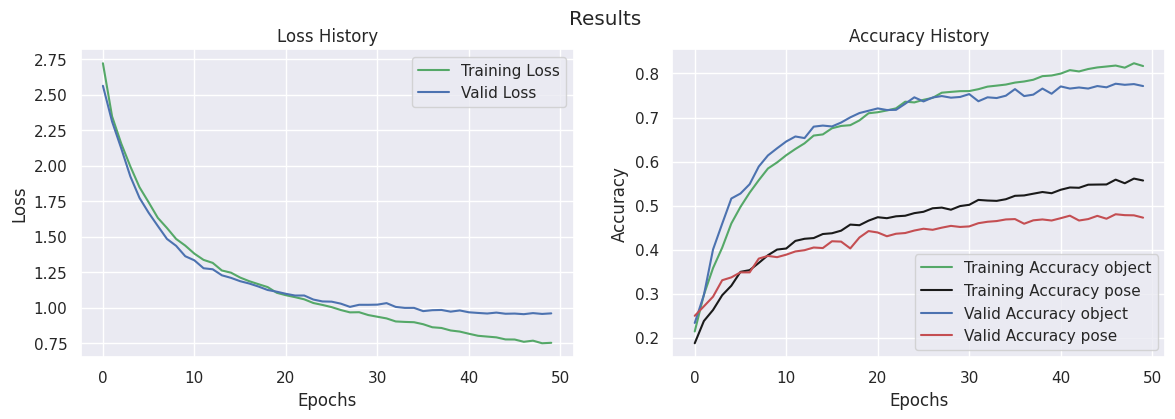

In [ ]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
      smoothed_val = w * last + (1 - w) * point
      smoothed.append(smoothed_val)
      ast = smoothed_val
          
    return smoothed

history9 = trainer8.getHistory()
trainer9.showResults()

best model was trained at epoch: 47
with a validation loss of: 0.9532116 and a validation accuracy of: 77.66950726509094


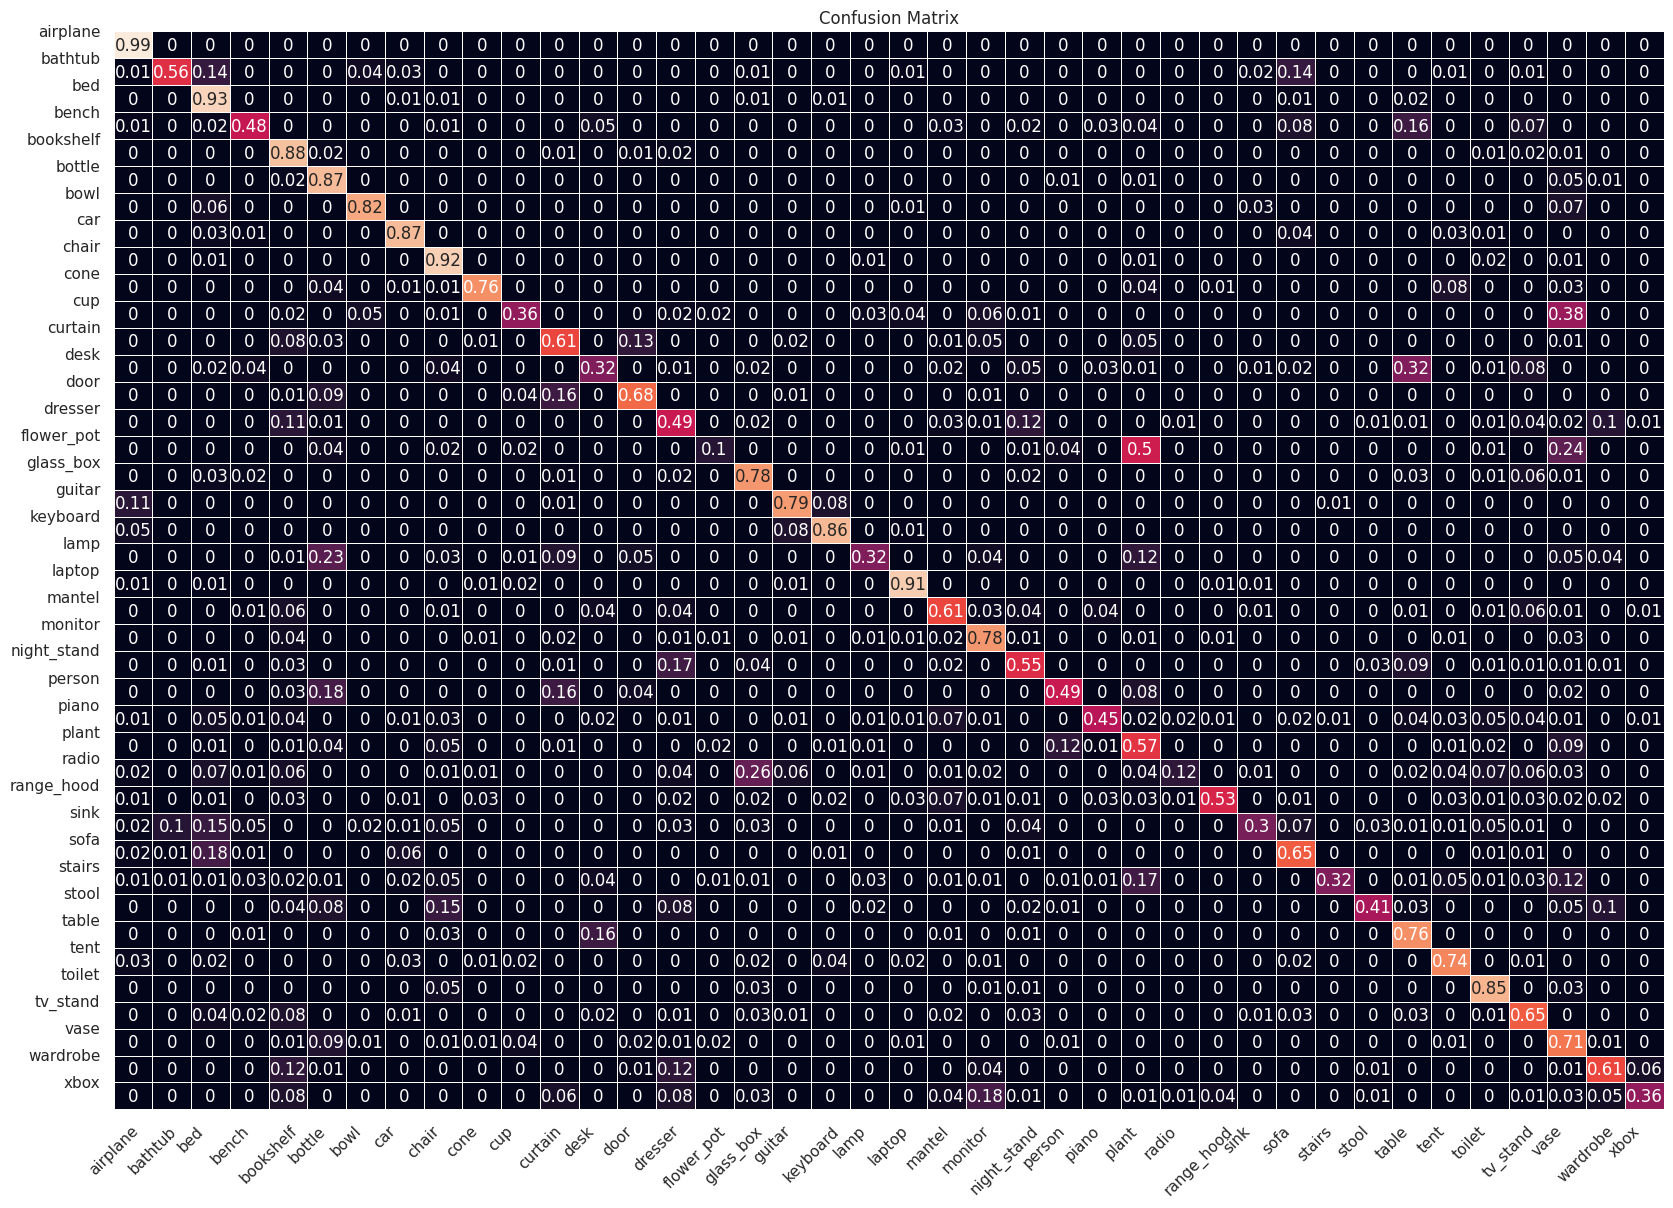

In [ ]:
trainer9.generateConfusionMatrix()

In [ ]:
class DMPORION40(nn.Module):
    def __init__(self):
        super(DMPORION40, self).__init__()
        n_classes = 40
        n_rotations = 8
        input_shape = (32,32,32)
        self.feat = torch.nn.Sequential(OrderedDict([
            ('conv3d_1', torch.nn.Conv3d(in_channels=1, out_channels=32, kernel_size=3, stride=1)),
            ('batch1', torch.nn.BatchNorm3d(32)),
            ('relu1', torch.nn.ReLU()),
            ('drop1', torch.nn.Dropout(p=0.2)),
            ('conv3d_2', torch.nn.Conv3d(in_channels=32, out_channels=64, kernel_size=3, stride=1)),
            ('relu2', torch.nn.ReLU()),
            ('drop2', torch.nn.Dropout(p=0.2)),
            ('pool2', torch.nn.MaxPool3d(2)),
            ('conv3d_3', torch.nn.Conv3d(in_channels=64, out_channels=128, kernel_size=3, stride=1)),
            ('relu3', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.3)),
            ('pool3', torch.nn.MaxPool3d(2)),
            ('conv3d_4', torch.nn.Conv3d(in_channels=128, out_channels=256,kernel_size=3, stride=1)),
            ('relu4', torch.nn.ReLU()),
            ('drop4', torch.nn.Dropout(p=0.4)),
            ('pool4', torch.nn.MaxPool3d(2))
        ]))
        
        x = self.feat(torch.autograd.Variable(torch.rand((1, 1) + input_shape)))
        dim_feat = 1
        for n in x.size()[1:]:
            dim_feat *= n

        self.mlp = torch.nn.Sequential(OrderedDict([
            ('fc1', torch.nn.Linear(dim_feat, 128)),
            ('relu1', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.4)),
            ('fc2', torch.nn.Linear(128, n_classes))
        ]))

        self.mlp2 = torch.nn.Sequential(OrderedDict([
            ('fc1', torch.nn.Linear(dim_feat, 128)),
            ('relu1', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.4)),
            ('fc2', torch.nn.Linear(128, n_rotations))
        ]))

        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.feat(x)
        x = x.view(x.size(0), -1)
        x1 = self.mlp(x)
        x2 = self.mlp2(x)
        return self.logsoftmax(x1), self.logsoftmax(x2)

In [ ]:
training_hyperparameters = {
    "learning_rate": 0.001,
    "sgd_momentum": 0.9,
    "data_size": 32,
    "epochs": 50,
    "lr_scheduler_step": 40,
    "lr_scheduler_gamma": 0.5,
    "train_batch_size": 64,
    "valid_batch_size": 32,
    "model" : 'DMPORION40'
}    

trainer10 = Network_Trainer40(training_hyperparameters)
trainer10.train()

model DMPORION40 was choosen
143.75


Train loss: 2.6890981197357178: : 143it [01:07,  2.11it/s]
77it [00:07,  9.80it/s]


epoch:  1 / 50
time: 75.57 seconds
train-loss: 2.85, train-acc-object: 16.78%, train-acc-pose: 17.19%
valid-loss: 2.87, valid-acc-object: 21.48%, train-acc-pose: 23.59%



Train loss: 2.2436306476593018: : 143it [01:08,  2.10it/s]
77it [00:08,  9.35it/s]


epoch:  2 / 50
time: 76.39 seconds
train-loss: 2.41, train-acc-object: 29.53%, train-acc-pose: 23.00%
valid-loss: 2.63, valid-acc-object: 31.51%, train-acc-pose: 27.49%



Train loss: 1.9910424947738647: : 143it [01:08,  2.08it/s]
77it [00:15,  4.84it/s]


epoch:  3 / 50
time: 84.68 seconds
train-loss: 2.12, train-acc-object: 37.16%, train-acc-pose: 28.43%
valid-loss: 2.46, valid-acc-object: 40.48%, train-acc-pose: 32.52%



Train loss: 1.9927526712417603: : 143it [01:22,  1.74it/s]
77it [00:07, 10.37it/s]


epoch:  4 / 50
time: 89.73 seconds
train-loss: 1.92, train-acc-object: 43.43%, train-acc-pose: 32.78%
valid-loss: 2.27, valid-acc-object: 47.87%, train-acc-pose: 34.63%



Train loss: 1.6921076774597168: : 143it [01:16,  1.88it/s]
77it [00:09,  8.43it/s]


epoch:  5 / 50
time: 85.24 seconds
train-loss: 1.74, train-acc-object: 49.28%, train-acc-pose: 35.65%
valid-loss: 2.10, valid-acc-object: 52.38%, train-acc-pose: 36.83%



Train loss: 1.4965784549713135: : 143it [01:08,  2.10it/s]
77it [00:07,  9.65it/s]


epoch:  6 / 50
time: 76.15 seconds
train-loss: 1.63, train-acc-object: 52.95%, train-acc-pose: 37.60%
valid-loss: 2.09, valid-acc-object: 55.26%, train-acc-pose: 37.52%



Train loss: 1.3494644165039062: : 143it [01:09,  2.06it/s]
77it [00:08,  9.59it/s]


epoch:  7 / 50
time: 77.40 seconds
train-loss: 1.52, train-acc-object: 56.80%, train-acc-pose: 39.24%
valid-loss: 1.94, valid-acc-object: 58.71%, train-acc-pose: 40.11%



Train loss: 1.7248060703277588: : 143it [01:08,  2.08it/s]
77it [00:09,  8.37it/s]


epoch:  8 / 50
time: 78.06 seconds
train-loss: 1.44, train-acc-object: 58.58%, train-acc-pose: 41.03%
valid-loss: 1.85, valid-acc-object: 61.06%, train-acc-pose: 40.64%



Train loss: 1.3805996179580688: : 143it [01:07,  2.11it/s]
77it [00:08,  8.79it/s]


epoch:  9 / 50
time: 76.40 seconds
train-loss: 1.37, train-acc-object: 61.21%, train-acc-pose: 42.33%
valid-loss: 1.79, valid-acc-object: 61.27%, train-acc-pose: 40.40%



Train loss: 1.1942205429077148: : 143it [01:08,  2.09it/s]
77it [00:07, 10.19it/s]


epoch: 10 / 50
time: 75.87 seconds
train-loss: 1.30, train-acc-object: 62.97%, train-acc-pose: 43.06%
valid-loss: 1.71, valid-acc-object: 64.39%, train-acc-pose: 42.35%



Train loss: 1.186718225479126: : 143it [01:08,  2.09it/s]
77it [00:08,  9.13it/s]


epoch: 11 / 50
time: 76.75 seconds
train-loss: 1.24, train-acc-object: 65.75%, train-acc-pose: 43.72%
valid-loss: 1.68, valid-acc-object: 65.08%, train-acc-pose: 42.55%



Train loss: 1.2366912364959717: : 143it [01:07,  2.11it/s]
77it [00:09,  8.30it/s]


epoch: 12 / 50
time: 77.21 seconds
train-loss: 1.21, train-acc-object: 66.77%, train-acc-pose: 44.05%
valid-loss: 1.67, valid-acc-object: 69.87%, train-acc-pose: 44.09%



Train loss: 1.159885287284851: : 143it [01:08,  2.10it/s]
77it [00:08,  8.95it/s]


epoch: 13 / 50
time: 76.67 seconds
train-loss: 1.16, train-acc-object: 69.19%, train-acc-pose: 45.50%
valid-loss: 1.57, valid-acc-object: 69.75%, train-acc-pose: 42.14%



Train loss: 1.0847455263137817: : 143it [01:08,  2.09it/s]
77it [00:07,  9.91it/s]


epoch: 14 / 50
time: 76.09 seconds
train-loss: 1.13, train-acc-object: 69.61%, train-acc-pose: 45.99%
valid-loss: 1.56, valid-acc-object: 70.36%, train-acc-pose: 43.52%



Train loss: 1.2459051609039307: : 143it [01:08,  2.09it/s]
77it [00:09,  8.35it/s]


epoch: 15 / 50
time: 77.80 seconds
train-loss: 1.11, train-acc-object: 70.42%, train-acc-pose: 46.30%
valid-loss: 1.53, valid-acc-object: 71.74%, train-acc-pose: 44.38%



Train loss: 1.1558219194412231: : 143it [01:08,  2.10it/s]
77it [00:09,  8.26it/s]


epoch: 16 / 50
time: 77.37 seconds
train-loss: 1.08, train-acc-object: 71.47%, train-acc-pose: 46.92%
valid-loss: 1.50, valid-acc-object: 70.12%, train-acc-pose: 43.44%



Train loss: 1.1123013496398926: : 143it [01:08,  2.08it/s]
77it [00:08,  9.55it/s]


epoch: 17 / 50
time: 76.90 seconds
train-loss: 1.06, train-acc-object: 71.98%, train-acc-pose: 47.28%
valid-loss: 1.49, valid-acc-object: 72.76%, train-acc-pose: 46.12%



Train loss: 1.0301696062088013: : 143it [01:08,  2.08it/s]
77it [00:09,  8.33it/s]


epoch: 18 / 50
time: 77.95 seconds
train-loss: 1.03, train-acc-object: 72.62%, train-acc-pose: 47.64%
valid-loss: 1.46, valid-acc-object: 73.04%, train-acc-pose: 45.15%



Train loss: 0.9588795900344849: : 143it [01:08,  2.10it/s]
77it [00:09,  8.10it/s]


epoch: 19 / 50
time: 77.67 seconds
train-loss: 1.00, train-acc-object: 74.03%, train-acc-pose: 47.77%
valid-loss: 1.41, valid-acc-object: 71.90%, train-acc-pose: 45.23%



Train loss: 1.1966620683670044: : 143it [01:08,  2.08it/s]
77it [00:08,  9.58it/s]


epoch: 20 / 50
time: 76.71 seconds
train-loss: 0.98, train-acc-object: 74.24%, train-acc-pose: 48.31%
valid-loss: 1.38, valid-acc-object: 74.14%, train-acc-pose: 45.39%



Train loss: 1.0536420345306396: : 143it [01:08,  2.08it/s]
77it [00:08,  8.57it/s]


epoch: 21 / 50
time: 77.90 seconds
train-loss: 0.96, train-acc-object: 75.39%, train-acc-pose: 48.27%
valid-loss: 1.37, valid-acc-object: 74.06%, train-acc-pose: 46.00%



Train loss: 0.952149510383606: : 143it [01:08,  2.08it/s]
77it [00:09,  8.05it/s]


epoch: 22 / 50
time: 78.38 seconds
train-loss: 0.93, train-acc-object: 76.89%, train-acc-pose: 49.20%
valid-loss: 1.36, valid-acc-object: 74.06%, train-acc-pose: 46.24%



Train loss: 0.8657674789428711: : 132it [01:03,  2.18it/s]

In [ ]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
      smoothed_val = w * last + (1 - w) * point
      smoothed.append(smoothed_val)
      ast = smoothed_val
          
    return smoothed

history10 = trainer8.getHistory()
trainer10.showResults()

In [ ]:
trainer10.generateConfusionMatrix()

In [ ]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
      smoothed_val = w * last + (1 - w) * point
      smoothed.append(smoothed_val)
      ast = smoothed_val
          
    return smoothed

eps = range(0, len(history8["train_loss"].cpu()))
        
sns.set_theme()
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
fig.suptitle('Results')
        
ax[0,0].plot(eps, smooth(history8["train_loss"].cpu()), 'g', label='Training Loss VoxNet40')
ax[0,0].plot(eps, smooth(history9["train_loss"].cpu()), 'b', label='Training Loss ORION40')
ax[0,0].plot(eps, smooth(history10["train_loss"].cpu()), 'r', label='Training Loss DMPORION40')
ax[0,0].set_title('Training Loss History')
ax[0,0].set(xlabel='Epochs', ylabel='Loss')
ax[0,0].legend()
        
ax[0,1].plot(eps, smooth(history8["valid_loss"].cpu()), 'g', label='Valid Loss VoxNet40')
ax[0,1].plot(eps, smooth(history9["valid_loss"].cpu()), 'b', label='Valid Loss ORION40')
ax[0,1].plot(eps, smooth(history10["valid_loss"].cpu()), 'r', label='Valid Loss DMPORION40')
ax[0,1].set_title('Valid Loss History')
ax[0,1].set(xlabel='Epochs', ylabel='Loss')
ax[0,1].legend()

ax[1,0].plot(eps, smooth(history8["train_acc1"].cpu()), 'g', label='Training Accuracy VoxNet40')
ax[1,0].plot(eps, smooth(history9["train_acc1"].cpu()), 'b', label='Training Accuracy ORION40')
ax[1,0].plot(eps, smooth(history10["train_acc1"].cpu()), 'r', label='Training Accuracy DMPORION40')
ax[1,0].set_title('Training Accuracy History')
ax[1,0].set(xlabel='Epochs', ylabel='Accuracy')
ax[1,0].legend()

ax[1,1].plot(eps, smooth(history8["valid_acc1"].cpu()), 'g', label='Valid Accuracy VoxNet40')
ax[1,1].plot(eps, smooth(history9["valid_acc1"].cpu()), 'b', label='Valid Accuracy ORION40')
ax[1,1].plot(eps, smooth(history10["valid_acc1"].cpu()), 'r', label='Valid Accuracy DMPORION40')
ax[1,1].set_title('Valid Accuracy History')
ax[1,1].set(xlabel='Epochs', ylabel='Accuracy')
ax[1,1].legend()